# Set up notebook and dependancies

In [1]:
from spiketurnpike_postanalysis.Extract_ephys_from_struct import ExtractEphysData
import pandas as pd
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import mannwhitneyu, kruskal, shapiro, ttest_ind
from scipy import stats

import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [137]:
class DataFrameManager:
    def __init__(self, eed_object):
        self.eed = eed_object
        self.dataframes = {}  # Dictionary to hold multiple DataFrames
        self.detailed_dataframes = {}
        
    def create_dataframe(self, columns, df_name):
        data = []
        # Assuming the eed object has a structure similar to what you described
        for groupname, recordings in self.eed.all_data.items():
            for recordingname, cells in recordings.items():
                for cid, metrics in cells.items():
                    row = {'groupname': groupname, 'recordingname': recordingname, 'cid': cid}
                    
                    spike_times = metrics.get('SpikeTimes_all', []) # Get the spike times for the cell 
                    if len(spike_times) < 50:
                        row['SpikeCutoff'] = True # Check if the number of spikes is less than 500, if so, set the SpikeCutoff to True
                    else:
                        row['SpikeCutoff'] = False # Check if the number of spikes is less than 500, if not set the SpikeCutoff to False
                    # get the spike latency for the cell but only the fourth index as this is the max stim value
                    spike_latency = metrics.get('FirstSpikeLatency', None)
                    
                    # check if the fourth index is less than 50 
                    if spike_latency is not None and spike_latency[3] < 50:
                        row['FirstSpikeissmallerthan50'] = True
                    else:
                        row['FirstSpikeissmallerthan50'] = False
                    
                    for column in columns:
                        value = metrics.get(column, None)
                        if column == 'ISI_violations_percent' and value is not None and value < 1.5:
                            if metrics.get('IsSingleUnit', None) == 0.0:
                                print(f"Changing IsSingleUnit to 1.0 for group: {groupname}, recording: {recordingname}, cid: {cid}")
                        row[column] = value
                    data.append(row)
        
        new_df = pd.DataFrame(data)
        if df_name in self.dataframes:
            self.dataframes[df_name] = pd.concat([self.dataframes[df_name], new_df], ignore_index=True)
        else:
            self.dataframes[df_name] = new_df

    def append_data(self, df_name, new_data):
        if df_name in self.dataframes:
            self.dataframes[df_name] = pd.concat([self.dataframes[df_name], new_data], ignore_index=True)
        else:
            self.dataframes[df_name] = new_data
            
    def get_filtered_data(self, df_name, is_single_unit=None, cell_type=None, stim_responsivity=None, groupname=None):
        """
        Retrieve filtered data from the specified DataFrame based on IsSingleUnit, Cell_Type, 
        and StimResponsivity with the option to not filter on any of these by passing None.

        Parameters:
        df_name (str): Name of the DataFrame to filter.
        is_single_unit (float or None): If 1.0, filter for single units, if 0.0, filter for non-single units, 
                                        if None, do not filter by this criterion.
        cell_type (str or None): Filter for 'FS' or 'RS' cell types. If None, no filtering by cell type.
        stim_responsivity (float or None): Value to filter by in the StimResponsivity column. Can be 1.0, 0.0, or -1.0.
                                           If None, no filtering by StimResponsivity.

        Returns:
        pandas.DataFrame: The filtered DataFrame.
        """
        if df_name not in self.dataframes:
            print(f"No DataFrame found with the name '{df_name}'.")
            return None

        # Start with the full DataFrame
        filtered_df = self.dataframes[df_name]

        # Filter by cell type if provided
        if cell_type:
            filtered_df = filtered_df[filtered_df['Cell_Type'] == cell_type]

        # Filter by IsSingleUnit if not None
        if is_single_unit is not None:
            filtered_df = filtered_df[filtered_df['IsSingleUnit'] == is_single_unit]

        # Filter by StimResponsivity if not None
        if stim_responsivity is not None:
            filtered_df = filtered_df[filtered_df['StimResponsivity'] == stim_responsivity]
        if groupname is not None:
            filtered_df = filtered_df[filtered_df['groupname'] == groupname]

        return filtered_df
   
    def create_psth_dataframe(self):
        """
        Creates and stores a DataFrame for each stimulation type using the 'SpikeTrains_for_PSTHs' and 'PSTHs_raw' columns from the base PSTH DataFrame. 
        Each DataFrame is stored as an attribute of the DataFrameManager under a name that corresponds to the stimulation type.

        Details:
            'SpikeTrains_for_PSTHs' is expected to be a pandas Series where each entry is a list of arrays.
            Each array in the list corresponds to spike train data for one of the four distinct stimulations, with dimensions (n_trials, n_time_points), 
            where 'n_trials' varies per stimulation and 'n_time_points' is consistent (usually the length of the trial in ms).

            'PSTHs_raw' is expected to be a pandas Series where each entry is a numpy ndarray with dimensions (4, n_time_points), 
            where the first dimension corresponds to the four stimulation types and 'n_time_points' matches the second dimension of the arrays in 'SpikeTrains_for_PSTHs'.

        Processes:
            - A base DataFrame is created with necessary columns.
            - For each stimulation label (e.g., 'Zero', 'Low', 'Mid', 'Max'), a new DataFrame is created.
            - Each new DataFrame includes adjusted 'SpikeTrains_for_PSTHs' and 'PSTHs_raw' columns to isolate the data corresponding to the respective stimulation type.
            - Each DataFrame is stored in the class dictionary, keyed by the name 'psth_dataframe_' followed by the stimulation label.
        """
        # Create the base dataframe for PSTH analysis
        self.create_dataframe(['Cell_Type', 'LaminarLabel','IsSingleUnit', 'StimResponsivity', 'SpikeTrains_for_PSTHs', 'PSTHs_raw', 'ModulationIndex'], 'psth_dataframe')

        # Extracting trial tags
        stim_labels = self.eed.trialTagsLabels['trialTagsLabels']  # ['Zero', 'Low', 'Mid', 'Max']

        # Process each label
        for index, label in enumerate(stim_labels):
            # Retrieve spike trains and PSTHs for each label and create a new DataFrame
            df_name = f'psth_dataframe_{label}'
            self.dataframes[df_name] = self.dataframes['psth_dataframe'].copy()
            self.dataframes[df_name]['SpikeTrains_for_PSTHs'] = self.dataframes['psth_dataframe']['SpikeTrains_for_PSTHs'].apply(lambda x: x[index])
            self.dataframes[df_name]['PSTHs_raw'] = self.dataframes['psth_dataframe']['PSTHs_raw'].apply(lambda x: x[index])

    def create_psth_dataframe_opto(self, modulation_type=None):
        """
        Creates and stores a DataFrame for optogenetic stimulation using the 'SpikeTrains_for_PSTHs' and 'PSTHs_raw' columns from the base PSTH DataFrame. 
        The DataFrame is stored as an attribute of the DataFrameManager under a name that corresponds to the optogenetic stimulation type.

        Details:
            'SpikeTrains_for_PSTHs' is expected to be a pandas Series where each entry is an array of spike train data for the optogenetic stimulation,
            with dimensions (n_trials, n_time_points), where 'n_trials' is the number of trials and 'n_time_points' is consistent (usually the length of the trial in ms).

            'PSTHs_raw' is expected to be a pandas Series where each entry is a numpy ndarray with dimensions (n_time_points),
            where 'n_time_points' is consistent and should be 1500, corresponding to the time points of the optogenetic stimulation.

        Processes:
            - A base DataFrame is created with necessary columns.
            - Retrieve trial tags specific for optogenetic stimulation.
            - For each label (expected to be one for optogenetic stimulation), a new DataFrame is created.
            - Adjusted 'SpikeTrains_for_PSTHs' and 'PSTHs_raw' columns are created to isolate the data corresponding to the optogenetic stimulation.
            - The DataFrame is stored in the class dictionary, keyed by the name 'psth_dataframe_' followed by the stimulation label.
        """
        # Create the base dataframe for PSTH analysis
        #self.create_dataframe(['Cell_Type', 'LaminarLabel', 'IsSingleUnit', 'StimResponsivity', 'SpikeTrains_for_PSTHs', 'PSTHs_raw'], 'psth_dataframe')        
        self.create_dataframe_2(['Cell_Type', 'IsSingleUnit', 'StimResponsivity', 'SpikeTrains_for_PSTHs', 'PSTHs_raw', 'ModulationIndex', 'ModulationLabel'], 'psth_dataframe', modulation_type=modulation_type)


        # Extracting trial tags
        stim_labels = self.eed.trialTagsLabels['trialTagsLabels']  # This should only contain the optogenetic stimulation label

        # Process each label (typically only one for optogenetic stimulation)
        for index, label in enumerate(stim_labels):
            # Create a new DataFrame for optogenetic stimulation
            df_name = f'psth_dataframe_{label}'
            self.dataframes[df_name] = self.dataframes['psth_dataframe'].copy()
            self.dataframes[df_name]['SpikeTrains_for_PSTHs'] = self.dataframes['psth_dataframe']['SpikeTrains_for_PSTHs'].apply(lambda x: x[index])
            # Keep the same number of time points (1500) for the PSTH data
            self.dataframes[df_name]['PSTHs_raw'] = self.dataframes['psth_dataframe']['PSTHs_raw'].apply(lambda x: x[:, index] if x.ndim > 1 else x)
            
    def plot_psth(self, stim_label, cell_type=None, is_single_unit=None, stim_responsivity=None, groupname=None):
        """
        Plots the PSTH for a given stimulation type, with optional filtering on cell type, single unit status, and stimulus responsivity.
        Uses the 'relative_time_ms' from the ExtractEphysData object to correctly label the time axis.

        Args:
            stim_label (str): The label of the stimulation type to plot (e.g., 'Zero', 'Low', 'Mid', 'Max').
            cell_type (str, optional): Filter for specific cell types (e.g., 'FS', 'RS'). Default is None, which means no filtering by cell type.
            is_single_unit (float, optional): Filter for single units (1.0) or multi-units (0.0). None means no filtering.
            stim_responsivity (float, optional): Filter by stimulus responsivity (1.0, 0.0, -1.0). None means no filtering.

        Processes:
            - Retrieves the corresponding DataFrame for the specified stimulation.
            - Applies additional filtering based on the provided arguments.
            - Averages the PSTH data across all remaining units and plots the result using the relative time axis.
        """
        # Retrieve the DataFrame for the specified stimulation
        df_name = f'psth_dataframe_{stim_label}'
        if df_name not in self.dataframes:
            print(f"No data available for the stimulation: {stim_label}")
            return

        df = self.dataframes[df_name]

        # Apply filtering based on the optional parameters
        if cell_type is not None:
            df = df[df['Cell_Type'] == cell_type]
        if is_single_unit is not None:
            df = df[df['IsSingleUnit'] == is_single_unit]
        if stim_responsivity is not None:
            df = df[df['StimResponsivity'] == stim_responsivity]
        if groupname is not None:
            df = df[df['groupname'] == groupname]

        # Check if there is any data left after filtering
        if df.empty:
            print("No data matches the specified filters.")
            return

        # Get relative time array for x-axis
        time_array = self.eed.relative_time_ms['relative_time_ms']

        # Aggregate the PSTH data
        aggregated_psth = df['PSTHs_raw'].apply(pd.Series).mean(axis=0)

        # Plotting the aggregated PSTH
        plt.figure(figsize=(10, 5))
        plt.plot(time_array, aggregated_psth, label=f'PSTH for {stim_label}')
        plt.title(f'PSTH for {stim_label} - {cell_type or "All Types"}, SingleUnit: {is_single_unit}, Responsivity: {stim_responsivity}')
        plt.xlabel('Time (ms)')
        plt.ylabel('Average Spike Rate')
        plt.legend()
        plt.show()
    
    def create_time_mask(self, time_array, time_range):
        """
        Creates a mask for the time array based on the specified time range.
        
        Args:
            time_array (np.array): The array of time points.
            time_range (tuple): The start and end time for the mask (in ms).
            
        Returns:
            time_mask (np.array): Boolean array where True indicates the time points within the specified range.
        """
        if time_range:
            time_mask = (time_array >= time_range[0]) & (time_array <= time_range[1])
        else:
            time_mask = slice(None)
        return time_mask

    def filter_data(self, stim_label, cell_type=None, is_single_unit=None, stim_responsivity=None, groupname=None, modulation_label=None, recordingname=None):
        df_name = f'psth_dataframe_{stim_label}'
        if df_name not in self.dataframes:
            print(f"No data available for the stimulation: {stim_label}")
            return pd.DataFrame()

        df = self.dataframes[df_name]
        
        #filter based on SPIKE CUTOFF BEING FALSE
        df = df[df['SpikeCutoff'] == False]
        

        # Apply filtering based on the optional parameters
        if cell_type is not None:
            df = df[df['Cell_Type'] == cell_type]
        if is_single_unit is not None:
            df = df[df['IsSingleUnit'] == is_single_unit]
        if stim_responsivity is not None:
            df = df[df['StimResponsivity'] == stim_responsivity]
        if groupname is not None:
            df = df[df['groupname'] == groupname]
        if recordingname is not None:
            df = df[df['recordingname'] == recordingname]
        
        if modulation_label is not None:
            # Validate the modulation label input
            if modulation_label not in ['positive', 'negative', 'none']:
                raise ValueError("Modulation label must be one of 'positive', 'negative', or 'none'.")
            
            # Apply modulation label filtering
            if modulation_label == 'positive' or modulation_label == 'negative':
                df = df[df['ModulationLabel'] == modulation_label]
            elif modulation_label == 'none':
                df = df[df['ModulationLabel'].isnull()]
        
        return df

    def plot_individual_psths(self, stim_label, cell_type=None, is_single_unit=None, stim_responsivity=None, groupname=None, modulation_label=None, time_range=None):
        df = self.filter_data(stim_label, cell_type, is_single_unit, stim_responsivity, groupname, modulation_label)
        
        # Print the number of units that match the filter
        print(f"Number of units that match the filter: {df.shape[0]}")

        if df.empty:
            print("No data matches the specified filters.")
            return

        # Get relative time array for x-axis
        time_array = self.eed.relative_time_ms['relative_time_ms']
        
        # Create time mask and adjust time array
        time_mask = self.create_time_mask(time_array, time_range)
        time_array = time_array[time_mask]

        plt.figure(figsize=(10, 5))

        for index, row in df.iterrows():
            individual_psth = row['PSTHs_raw']
            # Apply time mask to individual PSTH
            individual_psth = np.array(individual_psth)[time_mask]
            # Apply a smoothing window
            window = np.ones(3) / 3  # 3ms window of smoothing


            
            individual_psth = np.convolve(individual_psth, window, mode='same')
            plt.plot(time_array, individual_psth, label=f'Unit {index}')

        plt.title(f'Individual PSTHs for {stim_label} - {cell_type or "All Types"}, SingleUnit: {is_single_unit}, Responsivity: {stim_responsivity}, Modulation: {modulation_label}')
        plt.xlabel('Time (ms)')
        plt.ylabel('Spike Rate')
        plt.legend().set_visible(False)
        plt.show()
        
    def compare_groups(self, group1, group2, stim_label, cell_type=None, is_single_unit=None, stim_responsivity=None, modulation_label=None, firstspike_latency=None):
        """
        Compares PSTH data between two specified groups for a given stimulation.
        This method is called within the plot_psth_comparison method which is called within the main function plot_all_stimulations. 
        

        Args:
            group1 (str): The first group name for comparison.
            group2 (str): The second group name for comparison.
            stim_label (str): The label of the stimulation type (e.g., 'Zero', 'Low', 'Mid', 'Max').
            cell_type (str, optional): Specific cell type to filter by.
            is_single_unit (float, optional): Filter for single units (1.0) or multi-units (0.0).
            stim_responsivity (float, optional): Filter by stimulus responsivity.
            modulation_label (str, optional): Filter by modulation label ('positive', 'negative', 'none').
            firstspike_latency (bool, optional): Filter by first spike latency in the FirstSpikeissmallerthan50 column.

        Returns:
            A tuple containing two pandas Series (or DataFrames) representing the filtered data for each group.
        """
        df_name = f'psth_dataframe_{stim_label}'
        if df_name not in self.dataframes:
            print(f"No data available for the stimulation: {stim_label}")
            return None, None

        base_df = self.dataframes[df_name]
        
        #Filter based on Spike Cutoff BEING FALSE
        base_df = base_df[base_df['SpikeCutoff'] == False]
        

        # Create a query string based on the provided filters
        query_str = f"(groupname == '{group1}')"
        if cell_type is not None:
            query_str += f" & (Cell_Type == '{cell_type}')"
        if is_single_unit is not None:
            query_str += f" & (IsSingleUnit == {is_single_unit})"
        if stim_responsivity is not None:
            query_str += f" & (StimResponsivity == {stim_responsivity})"
        
        if modulation_label is not None:
            # Validate the modulation label input
            if modulation_label not in ['positive', 'negative', 'none']:
                raise ValueError("Modulation label must be one of 'positive', 'negative', or 'none'.")
            
            # Apply modulation label filtering
            if modulation_label == 'positive' or modulation_label == 'negative':
                query_str += f" & (ModulationLabel == '{modulation_label}')"
            elif modulation_label == 'none':
                query_str += " & (ModulationLabel.isnull())"
        
        
        
        if firstspike_latency is True:
            query_str += " & (FirstSpikeissmallerthan50 == True)"
        if firstspike_latency is False:
            query_str += " & (FirstSpikeissmallerthan50 == False)"
        
        print(f"Query for group1: {query_str}")
        filtered_df1 = base_df.query(query_str)
        print(f"Filtered df1: {filtered_df1.shape}")
        
        # Adjust the query for the second group
        query_str = query_str.replace(f"groupname == '{group1}'", f"groupname == '{group2}'")
        print(f"Query for group2: {query_str}")
        filtered_df2 = base_df.query(query_str)
        print(f"Filtered df2: {filtered_df2.shape}")
        
        return filtered_df1, filtered_df2
        
    def plot_all_stimulations(self, group1, group2, cell_type=None, is_single_unit=None, stim_responsivity=None, time_range=None, plot_mode='mean', smoothing_window=None):
        """
        Plots a 1x4 subplot of PSTH comparisons for all stimulation types.
        1. Grabs the trial tags labels from the ExtractEphysData object to determine the stimulation types
        and create labels for the subplots.
        2. Calls the plot_psth_comparison method for each stimulation type and plots them in a single figure.
        
        Args:
            group1 (str): First group name.
            group2 (str): Second group name.
            cell_type (str): 'FS' or 'RS'
            is_single_unit (float, optional): Single unit filter.
            stim_responsivity (float, optional): Stimulus responsivity filter.
            time_range (tuple, optional): Tuple specifying the start and end of the time range (e.g., (-100, 200)).
            plot_mode (str, optional): Plotting mode ('mean', 'traces', 'sem').
        """
        
        
        stim_labels = self.eed.trialTagsLabels['trialTagsLabels']  # ['Zero', 'Low', 'Mid', 'Max']
        fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

        for i, stim_label in enumerate(stim_labels):
            self.plot_psth_comparison(group1, group2, stim_label, axs[i], cell_type=cell_type, is_single_unit=is_single_unit, stim_responsivity=stim_responsivity, time_range=time_range, plot_mode=plot_mode, smoothing_window=smoothing_window)
            axs[i].set_title(stim_label)

        plt.tight_layout()
        plt.show()

    def plot_psth_comparison(self, group1, group2, stim_label, 
                             ax=None, cell_type=None, is_single_unit=None, stim_responsivity=None, firstspike_latency=None, modulation_label=None,
                             time_range=None, plot_mode='mean', smoothing_window=None):
        """
        called within plot_all_stimulations which is called within the main function plot_all_stimulations
        
        uses the compare_groups method to get the data for the two groups and the specified stimulation type 
        and fetches the two DataFrames for the groups
        
        Plots a PSTH comparison on the provided axes object or creates a new figure if not provided.
        Optionally overlays the stimulator signal as a thin black line.

        Args:
            group1 (str): First group name.
            group2 (str): Second group name.
            stim_label (str): Stimulation label.
            ax (matplotlib.axes.Axes, optional): Axes object to plot on.
            cell_type (str, optional): Cell type to filter.
            is_single_unit (float, optional): Single unit filter.
            stim_responsivity (float, optional): Stimulus responsivity filter.
            firstspike_latency (bool, optional): Filter by first spike latency in the FirstSpikeissmallerthan50 column.
            time_range (tuple, optional): Tuple specifying the start and end of the time range (e.g., (-100, 200)).
            plot_mode (str, optional): Plotting mode ('mean', 'traces', 'sem').
            smoothing_window (int, optional): Size of the smoothing window; if None, no smoothing is applied.
            groups_to_plot (str, optional): Specifies which group(s) to plot ('both', 'group1', 'group2').
        """
        # Define colors
        group_colors = {
            'No_CTZ': '#797979',
            'CTZ': '#5a00c2'}
        # Fetch data
        df1, df2 = self.compare_groups(group1, group2, stim_label, cell_type, is_single_unit, stim_responsivity, firstspike_latency, modulation_label)
        if df1.empty or df2.empty:
            print("One of the groups has no data after filtering.")
            return
        if df1.empty or df2.empty:
            print("One of the groups has no data after filtering.")
            return
        

        # Get the time array and adjust for the specified time range
        time_array = self.eed.relative_time_ms['relative_time_ms']
        if time_range:
            time_mask = (time_array >= time_range[0]) & (time_array <= time_range[1])
            time_array = time_array[time_mask]
        else:
            time_mask = slice(None)

        # Check if we need to create a new figure
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 5))
        
        # DataFrame to store all traces ###new addition to the code
        all_traces_df = pd.DataFrame()
        
        # Process and plot data
        for df, group in zip([df1, df2], [group1, group2]):
            data = df['PSTHs_raw'].apply(lambda x: np.array(x)[time_mask])
            if smoothing_window:
                window = np.ones(smoothing_window) / smoothing_window
                data = data.apply(lambda x: np.convolve(x, window, mode='same'))
                
            mean_psth = data.apply(pd.Series).mean(axis=0)
            
            # Store each trace in the DataFrame ## new addition to the code 
            # Store each trace in the DataFrame with additional metadata
            group_traces_df = pd.DataFrame(data.tolist(), columns=time_array)
            group_traces_df['Group'] = group
            group_traces_df['Stimulation'] = stim_label
            group_traces_df['Cell_Type'] = cell_type
            group_traces_df['IsSingleUnit'] = is_single_unit
            group_traces_df['StimResponsivity'] = stim_responsivity
            group_traces_df['FirstSpikeissmallerthan50'] = firstspike_latency
            all_traces_df = pd.concat([all_traces_df, group_traces_df])

            
            if plot_mode == 'sem':
                sem = data.apply(pd.Series).sem(axis=0)

            # Plot individual traces or mean with SEM
            if plot_mode == 'traces':
                for trace in data:
                    ax.plot(time_array, trace, color=group_colors[group]+'33', alpha=0.2)  # Lighter traces
            
            elif plot_mode == 'sem':
                ax.fill_between(time_array, mean_psth - sem, mean_psth + sem, color=group_colors[group], alpha=0.2)  # SEM shading

            ax.plot(time_array, mean_psth, label=f'{group}', color=group_colors[group])  # Mean trace

        # Set plot attributes
        ax.set_title(f'PSTH Comparison of {stim_label} between {group1} and {group2}')
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Average Spike Rate')
        ax.legend()

        # Only show the plot if an axes object was not provided
        if ax is None:
            plt.tight_layout()
            plt.show()
        
        # Return the DataFrame containing all traces
        return all_traces_df
    
    def plot_psth_comparison_grouprecordings(self, group1, group2, stim_label, 
                                            ax=None, cell_type=None, is_single_unit=None, stim_responsivity=None, 
                                            time_range=None, plot_mode='mean', smoothing_window=None, group_by_recordings=False):
        """
        Plots a PSTH comparison on the provided axes object or creates a new figure if not provided.
        Optionally overlays the stimulator signal as a thin black line.
        Optionally groups data by recordings before calculating mean PSTHs.

        Args:
            group1 (str): First group name.
            group2 (str): Second group name.
            stim_label (str): Stimulation label.
            ax (matplotlib.axes.Axes, optional): Axes object to plot on.
            cell_type (str, optional): Cell type to filter.
            is_single_unit (float, optional): Single unit filter.
            stim_responsivity (float, optional): Stimulus responsivity filter.
            time_range (tuple, optional): Tuple specifying the start and end of the time range (e.g., (-100, 200)).
            plot_mode (str, optional): Plotting mode ('mean', 'traces', 'sem').
            smoothing_window (int, optional): Size of the smoothing window; if None, no smoothing is applied.
            group_by_recordings (bool, optional): If True, calculates the mean PSTHs at the recording level.
        """
        # Define colors
        group_colors = {
            'No_CTZ': '#797979',
            'CTZ': '#5a00c2'
        }
        
        # Fetch data
        df1, df2 = self.compare_groups(group1, group2, stim_label, cell_type, is_single_unit, stim_responsivity)
        if df1.empty or df2.empty:
            print("One of the groups has no data after filtering.")
            return

        # Get the time array and adjust for the specified time range
        time_array = self.eed.relative_time_ms['relative_time_ms']
        if time_range:
            time_mask = (time_array >= time_range[0]) & (time_array <= time_range[1])
            time_array = time_array[time_mask]
        else:
            time_mask = slice(None)

        # Check if we need to create a new figure
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 5))

        # Helper function to process data
        def process_data(df, group):
            if group_by_recordings:
                grouped = df.groupby('recordingname')
                grouped_data = grouped['PSTHs_raw'].apply(lambda x: np.mean([np.array(i)[time_mask] for i in x], axis=0))
            else:
                grouped_data = df['PSTHs_raw'].apply(lambda x: np.array(x)[time_mask])

            if smoothing_window:
                window = np.ones(smoothing_window) / smoothing_window
                grouped_data = grouped_data.apply(lambda x: np.convolve(x, window, mode='same'))
            
            return grouped_data

        # Process and plot data
        for df, group in zip([df1, df2], [group1, group2]):
            data = process_data(df, group)
            mean_psth = data.apply(pd.Series).mean(axis=0)
            
            if plot_mode == 'sem':
                sem = data.apply(pd.Series).sem(axis=0)

            # Plot individual traces or mean with SEM
            if plot_mode == 'traces':
                for trace in data:
                    ax.plot(time_array, trace, color=group_colors[group]+'33', alpha=0.2)  # Lighter traces
            
            elif plot_mode == 'sem':
                ax.fill_between(time_array, mean_psth - sem, mean_psth + sem, color=group_colors[group], alpha=0.2)  # SEM shading

            ax.plot(time_array, mean_psth, label=f'{group}', color=group_colors[group])  # Mean trace

        # Set plot attributes
        ax.set_title(f'PSTH Comparison of {stim_label} between {group1} and {group2}')
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Average Spike Rate')
        ax.legend()

        # Only show the plot if an axes object was not provided
        if ax is None:
            plt.tight_layout()
            plt.show()
        return data 

    def extract_stim_signals(self):
        """
        Extracts and formats the stimulation signals for each relevant stimulation type and synthesizes a flat line for the 'Zero' stimulation.
        """
        stim_voltages = self.eed.StimVoltageTraces_ms['StimVoltageTraces_ms']
        stim_labels = self.eed.trialTagsLabels['trialTagsLabels']  # ['Zero', 'Low', 'Mid', 'Max']

        aligned_signals = {}
        full_length = len(self.eed.relative_time_ms['relative_time_ms'])
        stim_start_index = 500
        stim_end_index = 1000

        # Determine the global maximum voltage to set a unified y-axis for the stimulation signals
        max_voltage = np.max(stim_voltages)

        # Extract and pad signals
        for index, label in enumerate(stim_labels):
            if label in ['Low', 'Mid', 'Max']:
                signal_column_index = ['Low', 'Mid', 'Max'].index(label)
                signal = stim_voltages[:, signal_column_index]

                pre_padding = np.zeros(stim_start_index)
                post_padding = np.zeros(full_length - stim_end_index)
                padded_signal = np.concatenate((pre_padding, signal, post_padding))

                aligned_signals[label] = padded_signal[:1500]

            elif label == 'Zero':
                # Create a flat line using the minimum voltage from 'Low'
                min_voltage = np.min(stim_voltages[:, 0])
                flat_signal = np.full(full_length, min_voltage)
                aligned_signals[label] = flat_signal[:1500]

        return aligned_signals, max_voltage
    
    def extract_stim_signals_opto(self):
        """
        Extracts and formats the stimulation signals for the optogenetic stimulation type. 
        Since there is only one stimulation type and the array is 1D, the method simplifies handling of the array.
        """
        stim_voltages = self.eed.StimVoltageTraces_ms['StimVoltageTrace_ms'] #Trace not Traces for opto
        stim_labels = self.eed.trialTagsLabels['trialTagsLabels']  # This should contain only the optogenetic stimulation label.

        aligned_signals = {}
        full_length = len(self.eed.relative_time_ms['relative_time_ms'])
        stim_start_index = 500
        stim_end_index = 1000

        # Determine the global maximum voltage to set a unified y-axis for the stimulation signals
        max_voltage = np.max(stim_voltages)

        # Extract and pad the signal for the optogenetic stimulation
        for label in stim_labels:
            signal = stim_voltages  # Directly use the 1D array as there's only one type of stimulation

            pre_padding = np.zeros(stim_start_index)
            post_padding = np.zeros(full_length - stim_end_index)
            padded_signal = np.concatenate((pre_padding, signal, post_padding))

            aligned_signals[label] = padded_signal[:1500]

        return aligned_signals, max_voltage

    def plot_psth_with_stim(self, group1, group2, stim_label, ax=None, max_voltage=None, cell_type=None, is_single_unit=None, stim_responsivity=None, 
                            time_range=None, plot_mode='mean', smoothing_window=None, firstspike_latency=None):
        """
        Plots a PSTH comparison on the provided axes object or creates a new figure if not provided,
        and overlays the stimulation signal on a secondary y-axis.

        The other parameters function as in the original plot_psth_comparison method.
        """
        # Fetch the base data
        #df1, df2 = self.compare_groups(group1, group2, stim_label, cell_type, is_single_unit, stim_responsivity)
        
        # Add debug statement to check input parameters and data
        print(f"Plotting PSTH for groups: {group1}, {group2} with stimulation: {stim_label}")
        

        # Get the time array and adjust for the specified time range
        time_array = self.eed.relative_time_ms['relative_time_ms']
        if time_range:
            time_mask = (time_array >= time_range[0]) & (time_array <= time_range[1])
            time_array = time_array[time_mask]
        else:
            time_mask = slice(None)

        # Check if we need to create a new figure
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 5))
            created_fig = True
        else:
            created_fig = False

        # Plot PSTH data as before
        traces_df = self.plot_psth_comparison(group1, group2, stim_label, ax=ax, cell_type=cell_type, is_single_unit=is_single_unit, stim_responsivity=stim_responsivity, time_range=time_range, plot_mode=plot_mode, smoothing_window=smoothing_window, firstspike_latency=firstspike_latency)
        
        ax2 = ax.twinx()
        stim_signals, _ = self.extract_stim_signals()
        if stim_label in stim_signals:
            stim_signal = stim_signals[stim_label]  # Assuming full signal is handled correctly
            stim_signal = stim_signal[:1500]
            if time_range:
                stim_signal = stim_signal[time_mask]  # Apply time mask if time range is specified
            ax2.plot(time_array, stim_signal, 'r-', label='Stim Signal', alpha=0.5)
            ax2.set_ylabel('Stimulation Voltage (uV)', color='r')
            ax2.legend(loc='upper right')
            ax2.set_ylim(0, max_voltage)  # Set consistent y-axis scale

        # Only show the plot if an axes object was not provided
        if created_fig:
            plt.tight_layout()
            plt.show()
        
        return traces_df
    
    def plot_psth_with_stim_opto(self, group1, group2, stim_label, ax=None, max_voltage=None, cell_type=None, is_single_unit=None, stim_responsivity=None, time_range=None, plot_mode='mean', smoothing_window=None):
        """
        Plots a PSTH comparison on the provided axes object or creates a new figure if not provided,
        and overlays the stimulation signal on a secondary y-axis.

        The other parameters function as in the original plot_psth_comparison method.
        """
        # Fetch the base data
        df1, df2 = self.compare_groups(group1, group2, stim_label, cell_type, is_single_unit, stim_responsivity)

        # Get the time array and adjust for the specified time range
        time_array = self.eed.relative_time_ms['relative_time_ms']
        if time_range:
            time_mask = (time_array >= time_range[0]) & (time_array <= time_range[1])
            time_array = time_array[time_mask]
        else:
            time_mask = slice(None)

        # Check if we need to create a new figure
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 5))
            created_fig = True
        else:
            created_fig = False

        # Plot PSTH data as before
        self.plot_psth_comparison(group1, group2, stim_label, ax=ax, cell_type=cell_type, is_single_unit=is_single_unit, stim_responsivity=stim_responsivity, time_range=time_range, plot_mode=plot_mode, smoothing_window=smoothing_window)
        ax2 = ax.twinx()
        stim_signals, _ = self.extract_stim_signals_opto()
        if stim_label in stim_signals:
            stim_signal = stim_signals[stim_label]  # Assuming full signal is handled correctly
            stim_signal = stim_signal[:1500]
            if time_range:
                stim_signal = stim_signal[time_mask]  # Apply time mask if time range is specified
            ax2.plot(time_array, stim_signal, 'r-', label='Stim Signal', alpha=0.5)
            ax2.set_ylabel('LED Stimulation Voltage (uV)', color='r')
            ax2.legend(loc='upper right')
            ax2.set_ylim(0, max_voltage)  # Set consistent y-axis scale

        # Only show the plot if an axes object was not provided
        if created_fig:
            plt.tight_layout()
            plt.show()

    def plot_all_stimulations_with_stim(self, group1, group2, cell_type=None, is_single_unit=None, stim_responsivity=None, time_range=None, plot_mode='mean', smoothing_window=None, directory=None, file_name=None, firstspike_latency=None):
        
        stim_labels = self.eed.trialTagsLabels['trialTagsLabels']  # ['Zero', 'Low', 'Mid', 'Max']
        fig, axs = plt.subplots(1, len(stim_labels), figsize=(20, 5), sharey=True)

        # Retrieve stimulation signals to determine the maximum voltage
        stim_signals, max_voltage = self.extract_stim_signals()

        all_traces_df = pd.DataFrame()
        
        for i, stim_label in enumerate(stim_labels):
            traces_df = self.plot_psth_with_stim(group1, group2, stim_label, axs[i], max_voltage=max_voltage, cell_type=cell_type, is_single_unit=is_single_unit, stim_responsivity=stim_responsivity, time_range=time_range, plot_mode=plot_mode, smoothing_window=smoothing_window, firstspike_latency=firstspike_latency)
            traces_df['Stimulation'] = stim_label  # Ensure the correct stim label is assigned
            all_traces_df = pd.concat([all_traces_df, traces_df], ignore_index=True)
            axs[i].set_title(stim_label)
            
        # Create directory if it does not exist
        os.makedirs(directory, exist_ok=True)
        
        # Save the figure as an SVG file in the specified directory
        file_path = os.path.join(directory, f'{file_name}.svg')
        fig.savefig(file_path, format='svg')

        plt.tight_layout()
        plt.show()
        
        return all_traces_df
    
    def calculate_basic_stats(self, group1, group2, stim_label=None, baseline_range=(-100, 1), stim_range=(0, 50), cell_type=None, is_single_unit=None, stim_responsivity=None, smoothing_window=None, modulation_label=None, firstspike_latency=None):
        """
        Calculates basic statistics for baseline and stimulation windows for two groups across all or a specific stimulation type and stores the detailed data used for these calculations.

        Args:
            group1 (str): First group name.
            group2 (str): Second group name.
            stim_label (str or None): Specific stimulation label to analyze, or None to analyze all.
            baseline_range (tuple): Time range for baseline window.
            stim_range (tuple): Time range for stimulation window.
            cell_type (str, optional): Filter for specific cell types.
            is_single_unit (float, optional): Filter for single units.
            stim_responsivity (float, optional): Filter by stimulus responsivity.
            smoothing_window (int, optional): Size of the smoothing window.
            modulation_label (str, optional): Filter by modulation label ('positive', 'negative', 'none').
            firstspike_latency (bool, optional): Filter by first spike latency in the FirstSpikeissmallerthan50 column.

        Returns:
            pandas.DataFrame: A DataFrame containing means and standard deviations for the specified windows.
        """
        stim_labels = self.eed.trialTagsLabels['trialTagsLabels']  # ['Zero', 'Low', 'Mid', 'Max']
        if stim_label:
            stim_labels = [stim_label]  # If specific stim_label is provided, use that

        results = []

        for stim in stim_labels:
            df1, df2 = self.compare_groups(group1, group2, stim, cell_type, is_single_unit, 
                                           stim_responsivity, modulation_label, firstspike_latency)

            # Function to calculate stats and add to DataFrame
            def calculate_and_store_stats(df, time_range, window_label):
                if df is None or df.empty:
                    return df

                time_array = self.eed.relative_time_ms['relative_time_ms']
                time_mask = (time_array >= time_range[0]) & (time_array <= time_range[1])
                
                # Apply the time mask and store the result in a new column safely
                df.loc[:, 'masked_data'] = df['PSTHs_raw'].apply(lambda x: np.array(x)[time_mask])

                if smoothing_window:
                    window = np.ones(smoothing_window) / smoothing_window
                    df.loc[:, 'smoothed_data'] = df['masked_data'].apply(lambda x: np.convolve(x, window, mode='same'))
                else:
                    df.loc[:, 'smoothed_data'] = df['masked_data']

                # Calculate mean and standard deviation and store them in new columns
                df.loc[:, f'mean_{window_label}'] = df['smoothed_data'].apply(np.max)
                df.loc[:, f'std_{window_label}'] = df['smoothed_data'].apply(np.std)

                return df


            # Calculate and store stats in the DataFrames
            df1 = calculate_and_store_stats(df1, baseline_range, 'baseline')
            df1 = calculate_and_store_stats(df1, stim_range, 'stimulation')
            df2 = calculate_and_store_stats(df2, baseline_range, 'baseline')
            df2 = calculate_and_store_stats(df2, stim_range, 'stimulation')

            self.detailed_dataframes[(group1, stim)] = df1
            self.detailed_dataframes[(group2, stim)] = df2

            # Extract group-level results to return
            baseline_stats_group1 = {'mean': df1['mean_baseline'].max(), 'std': df1['std_baseline'].max()}
            stim_stats_group1 = {'mean': df1['mean_stimulation'].max(), 'std': df1['std_stimulation'].max()}
            baseline_stats_group2 = {'mean': df2['mean_baseline'].max(), 'std': df2['std_baseline'].max()}
            stim_stats_group2 = {'mean': df2['mean_stimulation'].max(), 'std': df2['std_stimulation'].max()}

            results.extend([
                {'Group': group1, 'Stimulation': stim, 'Window': 'Baseline', 'Mean': baseline_stats_group1['mean'], 'Std': baseline_stats_group1['std']},
                {'Group': group1, 'Stimulation': stim, 'Window': 'Stimulation', 'Mean': stim_stats_group1['mean'], 'Std': stim_stats_group1['std']},
                {'Group': group2, 'Stimulation': stim, 'Window': 'Baseline', 'Mean': baseline_stats_group2['mean'], 'Std': baseline_stats_group2['std']},
                {'Group': group2, 'Stimulation': stim, 'Window': 'Stimulation', 'Mean': stim_stats_group2['mean'], 'Std': stim_stats_group2['std']}
            ])

        return pd.DataFrame(results)
    
    def prepare_for_boxplot(self):
        """
        Organizes data into a DataFrame suitable for plotting boxplots. It extracts the 'mean_stimulation'
        values from detailed DataFrames, including labels for stimulation type and group.

        Returns:
            pandas.DataFrame: A DataFrame with columns for 'mean_stimulation', 'Stimulation', and 'Group'.
        """
        boxplot_data = []

        # Iterate over each stored DataFrame key (group and stimulation)
        for (group, stim), df in self.detailed_dataframes.items():
            if not df.empty:  # Corrected check for an empty DataFrame
                # Extract 'mean_stimulation' and corresponding labels
                for index, row in df.iterrows():
                    boxplot_data.append({
                        'mean_stimulation': row['mean_stimulation'],
                        'Stimulation': stim,
                        'Group': group, 
                        'ModulationLabel': row['ModulationLabel'], 
                        'FirstSpikeissmallerthan50': row['FirstSpikeissmallerthan50']
                    })

        # Convert list of data to DataFrame
        boxplot_df = pd.DataFrame(boxplot_data)

        return boxplot_df
    
    def plot_box_and_strip(self, groups=None, stimulations=None, show_outliers=True, hue_order=None, directory=None, file_name=None, ylim=None, modulation_label=None, firstspike_latency=None):
        """
        Plots boxplots and stripplots for specified groups and stimulations, with color adjustments made directly in the plotting calls.

        Args:
            groups (list of str, optional): List of groups to include in the plot.
            stimulations (list of str, optional): List of stimulations to include in the plot.
            show_outliers (bool, optional): Whether to show outliers.
            hue_order (list, optional): Order of the hue levels.
        """
        # Define color mapping for groups
        group_colors = {
            'No_CTZ': '#797979',
            'CTZ': '#5a00c2'
        }

        # Generate lighter versions for the box face color
        lightened_colors = {k: v + '33' for k, v in group_colors.items()}

        # Boxplot customization
        boxprops = {'edgecolor': 'k', 'linewidth': 2}
        whiskerprops = {'color': 'k', 'linewidth': 2}
        boxplot_kwargs = {
            'boxprops': boxprops,
            'medianprops': whiskerprops,
            'whiskerprops': whiskerprops,
            'capprops': {'linewidth': 0},  # Hide the caps
            'showfliers': show_outliers,
            'palette': group_colors,
            'hue_order': hue_order,
            'width': 0.75
        }

        # Stripplot customization
        stripplot_kwargs = {
            'linewidth': 0.6,
            'size': 6,
            'alpha': 0.7,
            'jitter': True,
            'dodge': True,
            'marker': 'o' if show_outliers else 'd',
            'palette': lightened_colors,
            'hue_order': hue_order
        }

        # Prepare data for boxplot
        boxplot_df = self.prepare_for_boxplot()

        # Filter by specified groups and stimulations
        if groups:
            boxplot_df = boxplot_df[boxplot_df['Group'].isin(groups)]
        if stimulations:
            boxplot_df = boxplot_df[boxplot_df['Stimulation'].isin(stimulations)]
        if modulation_label:
            boxplot_df = boxplot_df[boxplot_df['ModulationLabel'] == modulation_label]
        if firstspike_latency is True: #if firstspike_latency is True, then the latency is smaller than 50
            boxplot_df = boxplot_df[boxplot_df['FirstSpikeissmallerthan50'] == firstspike_latency]
        if firstspike_latency is False: #if firstspike_latency is False, then the latency is greater than 50
            boxplot_df = boxplot_df[boxplot_df['FirstSpikeissmallerthan50'] != True]
        if firstspike_latency is None: 
            boxplot_df = boxplot_df

        # Plotting
        plt.figure(figsize=(6, 6))
        ax = sns.boxplot(data=boxplot_df, x='Stimulation', y='mean_stimulation', hue='Group', **boxplot_kwargs)

        # Manually set the facecolor for boxplot
        for i, artist in enumerate(ax.artists):
            col = lightened_colors[ax.get_legend_handles_labels()[1][i // len(stimulations)]]
            artist.set_facecolor(col)

        # Add stripplot on top of boxplot for raw data visualization
        sns.stripplot(data=boxplot_df, x='Stimulation', y='mean_stimulation', hue='Group', **stripplot_kwargs)
        
        #control the upper and lower limits of the y-axis
        if ylim is not None:
            plt.ylim(ylim)

        # Enhance the plot
        plt.title('Comparison of Mean Stimulation Across Groups and Stimulations')
        plt.ylabel('Mean Stimulation')
        plt.xlabel('Stimulation Type')
        ax.legend(title='Group')
        
        # Prompt user for directory and file name if not provided
        if directory is None:
            directory = input("Please enter the directory to save the plot: ")
        if file_name is None:
            file_name = input("Please enter the file name to save the plot: ")

        # Create directory if it does not exist
        os.makedirs(directory, exist_ok=True)

        # Save the figure as an SVG file in the specified directory
        file_path = os.path.join(directory, f'{file_name}.svg')
        plt.savefig(file_path, format='svg')

        plt.show()
        
        return boxplot_df # Return the DataFrame for further analysis
        

    def plot_mean_and_sem_lineplot(self, groups=None, stimulations=None, show_outliers=True, hue_order=None, directory=None, file_name=None, ylim=None, modulation_label=None, firstspike_latency=None, file_format='svg'):
        """
        Plots mean and SEM bars for specified groups and stimulations, with color adjustments.

        Args:
            groups (list of str, optional): List of groups to include in the plot.
            stimulations (list of str, optional): List of stimulations to include in the plot.
            show_outliers (bool, optional): Whether to show outliers.
            hue_order (list, optional): Order of the hue levels.
            directory (str, optional): Directory to save the plot.
            file_name (str, optional): File name to save the plot.
            ylim (tuple, optional): Y-axis limits for the plot.
            modulation_label (str, optional): Label to filter modulation.
            firstspike_latency (bool, optional): Whether to filter by first spike latency.
            file_format (str, optional): Format to save the plot ('svg' or 'png'). Default is 'svg'.
        """
        # Validate the file format
        if file_format not in ['svg', 'png']:
            raise ValueError("file_format must be either 'svg' or 'png'")

        # Define color mapping for groups
        group_colors = {
            'No_CTZ': '#797979',
            'CTZ': '#5a00c2'
        }

        # Define the order of stimulations
        stim_order = ['Zero', 'Low', 'Mid', 'Max']

        # Prepare data for plotting
        boxplot_df = self.prepare_for_boxplot()

        # Filter by specified groups and stimulations
        if groups:
            boxplot_df = boxplot_df[boxplot_df['Group'].isin(groups)]
        if stimulations:
            boxplot_df = boxplot_df[boxplot_df['Stimulation'].isin(stimulations)]
        if modulation_label:
            boxplot_df = boxplot_df[boxplot_df['ModulationLabel'] == modulation_label]
        if firstspike_latency is True:  # if firstspike_latency is True, then the latency is smaller than 50
            boxplot_df = boxplot_df[boxplot_df['FirstSpikeissmallerthan50'] == firstspike_latency]
        if firstspike_latency is False:  # if firstspike_latency is False, then the latency is greater than 50
            boxplot_df = boxplot_df[boxplot_df['FirstSpikeissmallerthan50'] != True]

        # Calculate mean and SEM
        summary_df = boxplot_df.groupby(['Stimulation', 'Group']).agg(
            mean_stimulation=('mean_stimulation', 'mean'),
            sem_stimulation=('mean_stimulation', 'sem')
        ).reset_index()

        # Ensure the stimulations are ordered correctly
        summary_df['Stimulation'] = pd.Categorical(summary_df['Stimulation'], categories=stim_order, ordered=True)

        # Plotting
        plt.figure(figsize=(6, 6))
        ax = sns.lineplot(data=summary_df, x='Stimulation', y='mean_stimulation', hue='Group', palette=group_colors, hue_order=hue_order, markers=True, style='Group', markersize=10, linewidth=2.5)

        # Add error bars
        for group in summary_df['Group'].unique():
            group_data = summary_df[summary_df['Group'] == group]
            plt.errorbar(group_data['Stimulation'], group_data['mean_stimulation'], yerr=group_data['sem_stimulation'], fmt='o', c=group_colors[group], capsize=5, elinewidth=2, markersize=10)

        # Control the upper and lower limits of the y-axis
        if ylim is not None:
            plt.ylim(ylim)

        # Enhance the plot
        plt.title('Comparison of Mean Stimulation Across Groups and Stimulations')
        plt.ylabel('Mean Stimulation')
        plt.xlabel('Stimulation Type')
        ax.legend(title='Group')

        # Prompt user for directory and file name if not provided
        if directory is None:
            directory = input("Please enter the directory to save the plot: ")
        if file_name is None:
            file_name = input("Please enter the file name to save the plot: ")

        # Create directory if it does not exist
        os.makedirs(directory, exist_ok=True)

        # Save the figure as an SVG or PNG file in the specified directory
        file_path = os.path.join(directory, f'{file_name}.{file_format}')
        plt.savefig(file_path, format=file_format)

        plt.show()

        
    def plot_rasters_for_cid(self, groupname, recordingname, cid, time_window=None):
        """
        Plots raster plots for a specific cid within a specific group and recording across all stimulations,
        with an optional custom time window.

        Args:
            groupname (str): The name of the group.
            recordingname (str): The name of the recording.
            cid (str): The cell ID for which to plot the raster plots.
            time_window (tuple, optional): The window of time to plot, within the range -500 to 999 ms. 
                                           Default is None, which uses the full range.
        """
        stim_labels = self.eed.trialTagsLabels['trialTagsLabels']  # ['Zero', 'Low', 'Mid', 'Max']
        time_array = self.eed.relative_time_ms['relative_time_ms']  # Full time array from -500 to 999 ms

        # Determine the indices for slicing time_array based on the specified or default time window
        if time_window is not None:
            start_index = np.searchsorted(time_array, time_window[0])
            end_index = np.searchsorted(time_array, time_window[1], side='right')
        else:
            start_index, end_index = 0, len(time_array)  # Use full range if no window is specified
        
        # Prepare the figure
        fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
        fig.suptitle(f'Raster plots for CID: {cid}, Group: {groupname}, Recording: {recordingname}')

        # Iterate through each stimulation type
        for i, stim in enumerate(stim_labels):
            ax = axes[i]
            df_name = f'psth_dataframe_{stim}'
            if df_name in self.dataframes:
                df = self.dataframes[df_name]
                # Filter data for specific cid
                condition = (df['groupname'] == groupname) & (df['recordingname'] == recordingname) & (df['cid'] == cid)
                spike_trains = df.loc[condition, 'SpikeTrains_for_PSTHs'].values #a numpy.ndarry of shape(1,) and size 1 which contains a list of arrays
                
                # Check if there is any data to plot
                if spike_trains.size > 0:
                    spike_trains = spike_trains[0]  # extract the binary spike trains with numpy.ndarray of shape (n_trials, n_time_points)
                    # Plot each trial's spikes within the time window
                    for trial_index, trial in enumerate(spike_trains): #enumerate over the trials which are the rows of the spike_trains. trial is a numpy.ndarray of shape (n_time_points,) and trial_index is the index of the trial
                        spikes = np.where(trial == 1)[0]  # Get indices where spikes occur
                        spikes = spikes[(spikes >= start_index) & (spikes < end_index)]  # Filter spikes by time window
                        spike_times = time_array[spikes]  # Convert indices to times
                        ax.eventplot(spike_times, lineoffsets=trial_index + 1, linelengths=1, colors='black')

                    ax.set_xlim(time_window[0], time_window[1]) if time_window else ax.set_xlim(time_array[start_index], time_array[end_index-1])
                    ax.set_title(f'Stimulation: {stim}')
                    ax.set_xlabel('Time (ms)')
                    if i == 0:
                        ax.set_ylabel('Trial')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    def plot_rasters_for_cid_2msbins(self, groupname, recordingname, cid, time_window=None):
        """
        Plots raster plots for a specific cid within a specific group and recording across all stimulations,
        with an optional custom time window.

        Args:
            groupname (str): The name of the group.
            recordingname (str): The name of the recording.
            cid (str): The cell ID for which to plot the raster plots.
            time_window (tuple, optional): The window of time to plot, within the range -500 to 999 ms. 
                                        Default is None, which uses the full range.
        """
        stim_labels = self.eed.trialTagsLabels['trialTagsLabels']  # ['Zero', 'Low', 'Mid', 'Max']
        time_array = self.eed.relative_time_ms['relative_time_ms']  # Full time array from -500 to 999 ms

        # Create a new time array with 2ms bins
        new_time_array = np.arange(time_array[0], time_array[-1] + 1, 2)

        # Determine the indices for slicing time_array based on the specified or default time window
        if time_window is not None:
            start_index = np.searchsorted(new_time_array, time_window[0])
            end_index = np.searchsorted(new_time_array, time_window[1], side='right')
        else:
            start_index, end_index = 0, len(new_time_array)  # Use full range if no window is specified
        
        # Prepare the figure
        fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
        fig.suptitle(f'Raster plots for CID: {cid}, Group: {groupname}, Recording: {recordingname}')

        # Iterate through each stimulation type
        for i, stim in enumerate(stim_labels):
            ax = axes[i]
            df_name = f'psth_dataframe_{stim}'
            if df_name in self.dataframes:
                df = self.dataframes[df_name]
                # Filter data for specific cid
                condition = (df['groupname'] == groupname) & (df['recordingname'] == recordingname) & (df['cid'] == cid)
                spike_trains = df.loc[condition, 'SpikeTrains_for_PSTHs'].values #a numpy.ndarry of shape(1,) and size 1 which contains a list of arrays
                
                # Check if there is any data to plot
                if spike_trains.size > 0:
                    spike_trains = spike_trains[0]  # extract the binary spike trains with numpy.ndarray of shape (n_trials, n_time_points)
                    
                    # Bin the spike trains into 2ms intervals
                    binned_spike_trains = np.add.reduceat(spike_trains, np.arange(0, spike_trains.shape[1], 2), axis=1)
                    
                    # Plot each trial's spikes within the time window
                    for trial_index, trial in enumerate(binned_spike_trains): #enumerate over the trials which are the rows of the spike_trains. trial is a numpy.ndarray of shape (n_time_points,) and trial_index is the index of the trial
                        spikes = np.where(trial > 0)[0]  # Get indices where spikes occur (considering 2ms bins)
                        spikes = spikes[(spikes >= start_index) & (spikes < end_index)]  # Filter spikes by time window
                        spike_times = new_time_array[spikes]  # Convert indices to times
                        ax.eventplot(spike_times, lineoffsets=trial_index + 1, linelengths=1, colors='black')

                    ax.set_xlim(time_window[0], time_window[1]) if time_window else ax.set_xlim(new_time_array[start_index], new_time_array[end_index-1])
                    ax.set_title(f'Stimulation: {stim}')
                    ax.set_xlabel('Time (ms)')
                    if i == 0:
                        ax.set_ylabel('Trial')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    def plot_rasters_for_cid_changebinsize(self, groupname, recordingname, cid, time_window=None, bin_size=1):
        """
        Plots raster plots for a specific cid within a specific group and recording across all stimulations,
        with an optional custom time window and bin size.

        Args:
            groupname (str): The name of the group.
            recordingname (str): The name of the recording.
            cid (str): The cell ID for which to plot the raster plots.
            time_window (tuple, optional): The window of time to plot, within the range -500 to 999 ms. 
                                        Default is None, which uses the full range.
            bin_size (int, optional): The size of the bins in milliseconds. Default is 1ms.
        """
        stim_labels = self.eed.trialTagsLabels['trialTagsLabels']  # ['Zero', 'Low', 'Mid', 'Max']
        time_array = self.eed.relative_time_ms['relative_time_ms']  # Full time array from -500 to 999 ms

        # Create a new time array with the specified bin size
        new_time_array = np.arange(time_array[0], time_array[-1] + 1, bin_size)

        # Determine the indices for slicing time_array based on the specified or default time window
        if time_window is not None:
            start_index = np.searchsorted(new_time_array, time_window[0])
            end_index = np.searchsorted(new_time_array, time_window[1], side='right')
        else:
            start_index, end_index = 0, len(new_time_array)  # Use full range if no window is specified
        
        # Prepare the figure
        fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
        fig.suptitle(f'Raster plots for CID: {cid}, Group: {groupname}, Recording: {recordingname}')

        # Iterate through each stimulation type
        for i, stim in enumerate(stim_labels):
            ax = axes[i]
            df_name = f'psth_dataframe_{stim}'
            if df_name in self.dataframes:
                df = self.dataframes[df_name]
                # Filter data for specific cid
                condition = (df['groupname'] == groupname) & (df['recordingname'] == recordingname) & (df['cid'] == cid)
                spike_trains = df.loc[condition, 'SpikeTrains_for_PSTHs'].values #a numpy.ndarry of shape(1,) and size 1 which contains a list of arrays
                
                # Check if there is any data to plot
                if spike_trains.size > 0:
                    spike_trains = spike_trains[0]  # extract the binary spike trains with numpy.ndarray of shape (n_trials, n_time_points)
                    
                    # Bin the spike trains into the specified bin size
                    binned_spike_trains = np.add.reduceat(spike_trains, np.arange(0, spike_trains.shape[1], bin_size), axis=1)
                    
                    # Plot each trial's spikes within the time window
                    for trial_index, trial in enumerate(binned_spike_trains): #enumerate over the trials which are the rows of the spike_trains. trial is a numpy.ndarray of shape (n_time_points,) and trial_index is the index of the trial
                        spikes = np.where(trial > 0)[0]  # Get indices where spikes occur (considering bin size)
                        spikes = spikes[(spikes >= start_index) & (spikes < end_index)]  # Filter spikes by time window
                        spike_times = new_time_array[spikes]  # Convert indices to times
                        ax.eventplot(spike_times, lineoffsets=trial_index + 1, linelengths=1, colors='black')

                    ax.set_xlim(time_window[0], time_window[1]) if time_window else ax.set_xlim(new_time_array[start_index], new_time_array[end_index-1])
                    ax.set_title(f'Stimulation: {stim}')
                    ax.set_xlabel('Time (ms)')
                    if i == 0:
                        ax.set_ylabel('Trial')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()


    def plot_rasters_for_cid_changebinsize(self, groupname, recordingname, cid, time_window=None, bin_size=1, filter_empty_trials=False):
        """
        Plots raster plots for a specific cid within a specific group and recording across all stimulations,
        with an optional custom time window and bin size.

        Args:
            groupname (str): The name of the group.
            recordingname (str): The name of the recording.
            cid (str): The cell ID for which to plot the raster plots.
            time_window (tuple, optional): The window of time to plot, within the range -500 to 999 ms. 
                                        Default is None, which uses the full range.
            bin_size (int, optional): The size of the bins in milliseconds. Default is 1ms.
            filter_empty_trials (bool, optional): If True, only plots trials with at least one spike. Default is False.
        """
        stim_labels = self.eed.trialTagsLabels['trialTagsLabels']  # ['Zero', 'Low', 'Mid', 'Max']
        time_array = self.eed.relative_time_ms['relative_time_ms']  # Full time array from -500 to 999 ms

        # Create a new time array with the specified bin size
        new_time_array = np.arange(time_array[0], time_array[-1] + 1, bin_size)

        # Determine the indices for slicing time_array based on the specified or default time window
        if time_window is not None:
            start_index = np.searchsorted(new_time_array, time_window[0])
            end_index = np.searchsorted(new_time_array, time_window[1], side='right')
        else:
            start_index, end_index = 0, len(new_time_array)  # Use full range if no window is specified
        
        # Prepare the figure
        fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
        fig.suptitle(f'Raster plots for CID: {cid}, Group: {groupname}, Recording: {recordingname}')

        # Iterate through each stimulation type
        for i, stim in enumerate(stim_labels):
            ax = axes[i]
            df_name = f'psth_dataframe_{stim}'
            if df_name in self.dataframes:
                df = self.dataframes[df_name]
                # Filter data for specific cid
                condition = (df['groupname'] == groupname) & (df['recordingname'] == recordingname) & (df['cid'] == cid)
                spike_trains = df.loc[condition, 'SpikeTrains_for_PSTHs'].values
                
                # Check if there is any data to plot
                if spike_trains.size > 0:
                    spike_trains = spike_trains[0]  # extract the binary spike trains
                    
                    # Bin the spike trains into the specified bin size
                    binned_spike_trains = np.add.reduceat(spike_trains, np.arange(0, spike_trains.shape[1], bin_size), axis=1)
                    
                    # Optionally filter out trials without any spikes
                    if filter_empty_trials:
                        trial_spike_counts = binned_spike_trains.sum(axis=1)
                        binned_spike_trains = binned_spike_trains[trial_spike_counts > 0]
                    
                    # Plot each trial's spikes within the time window
                    for trial_index, trial in enumerate(binned_spike_trains):
                        spikes = np.where(trial > 0)[0]  # Get indices where spikes occur (considering bin size)
                        spikes = spikes[(spikes >= start_index) & (spikes < end_index)]  # Filter spikes by time window
                        spike_times = new_time_array[spikes]  # Convert indices to times
                        ax.eventplot(spike_times, lineoffsets=trial_index + 1, linelengths=1, colors='black')

                    ax.set_xlim(time_window[0], time_window[1]) if time_window else ax.set_xlim(new_time_array[start_index], new_time_array[end_index-1])
                    ax.set_title(f'Stimulation: {stim}')
                    ax.set_xlabel('Time (ms)')
                    if i == 0:
                        ax.set_ylabel('Trial')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()


    def smooth_data(self, data, window_size=5):
        """Smooths data using a moving average filter with a specified window size."""
        window = np.ones(int(window_size)) / float(window_size)
        return np.convolve(data, window, 'same')
    
    def plot_combined_psth_and_raster(self, groupname, recordingname, cid, time_window=None, smoothing_window=5, show=False):
        stim_labels = self.eed.trialTagsLabels['trialTagsLabels']
        time_array = self.eed.relative_time_ms['relative_time_ms']

        fig, axes = plt.subplots(3, 4, figsize=(24, 15))  # Adjusted for 3 rows of plots
        fig.suptitle(f'Comprehensive Neural Response Analysis for CID: {cid}, Group: {groupname}, Recording: {recordingname}')

        for i, stim in enumerate(stim_labels):
            smoothed_psth_ax = axes[0, i]
            raw_psth_ax = axes[1, i]
            raster_ax = axes[2, i]
            df_name = f'psth_dataframe_{stim}'

            if df_name in self.dataframes:
                df = self.dataframes[df_name]
                condition = (df['groupname'] == groupname) & (df['recordingname'] == recordingname) & (df['cid'] == cid)
                spike_trains = df.loc[condition, 'SpikeTrains_for_PSTHs'].values

                if spike_trains.size > 0:
                    spike_trains = spike_trains[0]
                    # Calculate PSTH
                    all_spikes = np.concatenate([np.where(trial == 1)[0] for trial in spike_trains])
                    counts, _ = np.histogram(all_spikes, bins=len(time_array), range=(0, len(time_array)))

                    # Apply time window if specified
                    if time_window:
                        start_idx = np.searchsorted(time_array, time_window[0])
                        end_idx = np.searchsorted(time_array, time_window[1], side='right')
                        displayed_time_array = time_array[start_idx:end_idx]
                        displayed_counts = counts[start_idx:end_idx]
                    else:
                        displayed_time_array = time_array
                        displayed_counts = counts

                    # Smooth the data for the smoothed PSTH
                    smoothed_counts = self.smooth_data(displayed_counts, smoothing_window)

                    # Plot Smoothed PSTH
                    smoothed_psth_ax.bar(displayed_time_array, smoothed_counts, width=1, align='edge', color='skyblue')
                    smoothed_psth_ax.set_title(f'{stim} Smoothed PSTH')
                    smoothed_psth_ax.set_xlim(displayed_time_array[0], displayed_time_array[-1])

                    # Plot Raw PSTH
                    raw_psth_ax.bar(displayed_time_array, displayed_counts, width=1, align='edge', color='gray')
                    raw_psth_ax.set_title(f'{stim} Raw PSTH')
                    raw_psth_ax.set_xlim(displayed_time_array[0], displayed_time_array[-1])

                    # Plot Raster
                    for trial_index, trial in enumerate(spike_trains):
                        spike_times = time_array[np.where(trial == 1)]
                        raster_ax.eventplot(spike_times, lineoffsets=trial_index + 1, linelengths=1)
                    raster_ax.set_title(f'{stim} Raster')
                    raster_ax.set_xlim(displayed_time_array[0], displayed_time_array[-1])

        plt.tight_layout()
        if show:
            plt.show()
        return fig

    def plot_combined_psth_and_raster_changebinsize(self, groupname, recordingname, cid, time_window=None, smoothing_window=5, bin_size=1, show=False):
        """
        Plots combined PSTH and raster plots for a specific cid within a specific group and recording across all stimulations,
        with an optional custom time window, smoothing window, and bin size.

        Args:
            groupname (str): The name of the group.
            recordingname (str): The name of the recording.
            cid (str): The cell ID for which to plot the PSTH and raster plots.
            time_window (tuple, optional): The window of time to plot, within the range -500 to 999 ms. 
                                        Default is None, which uses the full range.
            smoothing_window (int, optional): The size of the smoothing window for the smoothed PSTH. Default is 5.
            bin_size (int, optional): The size of the bins in milliseconds for the PSTH and raster. Default is 1ms.
            show (bool, optional): Whether to display the plot. Default is False.
        """
        stim_labels = self.eed.trialTagsLabels['trialTagsLabels']
        time_array = self.eed.relative_time_ms['relative_time_ms']

        # Create a new time array with the specified bin size
        new_time_array = np.arange(time_array[0], time_array[-1] + 1, bin_size)

        fig, axes = plt.subplots(3, 4, figsize=(24, 15))  # Adjusted for 3 rows of plots
        fig.suptitle(f'Comprehensive Neural Response Analysis for CID: {cid}, Group: {groupname}, Recording: {recordingname}')

        max_smoothed_counts = 0
        max_raw_counts = 0

        all_smoothed_counts = []
        all_raw_counts = []

        for i, stim in enumerate(stim_labels):
            df_name = f'psth_dataframe_{stim}'

            if df_name in self.dataframes:
                df = self.dataframes[df_name]
                condition = (df['groupname'] == groupname) & (df['recordingname'] == recordingname) & (df['cid'] == cid)
                spike_trains = df.loc[condition, 'SpikeTrains_for_PSTHs'].values

                if spike_trains.size > 0:
                    spike_trains = spike_trains[0]

                    # Bin the spike trains into the specified bin size
                    binned_spike_trains = np.add.reduceat(spike_trains, np.arange(0, spike_trains.shape[1], bin_size), axis=1)

                    # Calculate PSTH
                    all_spikes = np.concatenate([np.where(trial > 0)[0] for trial in binned_spike_trains])
                    counts, _ = np.histogram(all_spikes, bins=len(new_time_array), range=(0, len(new_time_array)))

                    # Apply time window if specified
                    if time_window:
                        start_idx = np.searchsorted(new_time_array, time_window[0])
                        end_idx = np.searchsorted(new_time_array, time_window[1], side='right')
                        displayed_time_array = new_time_array[start_idx:end_idx]
                        displayed_counts = counts[start_idx:end_idx]
                    else:
                        displayed_time_array = new_time_array
                        displayed_counts = counts

                    # Smooth the data for the smoothed PSTH
                    smoothed_counts = self.smooth_data(displayed_counts, smoothing_window)

                    all_smoothed_counts.append(smoothed_counts)
                    all_raw_counts.append(displayed_counts)

                    max_smoothed_counts = max(max_smoothed_counts, np.max(smoothed_counts))
                    max_raw_counts = max(max_raw_counts, np.max(displayed_counts))

        # Set y-limits based on the maximum counts across all stimulations
        ylimit_smoothed = 1.1 * max_smoothed_counts
        ylimit_raw = 1.1 * max_raw_counts

        for i, stim in enumerate(stim_labels):
            smoothed_psth_ax = axes[0, i]
            raw_psth_ax = axes[1, i]
            raster_ax = axes[2, i]
            df_name = f'psth_dataframe_{stim}'

            if df_name in self.dataframes:
                df = self.dataframes[df_name]
                condition = (df['groupname'] == groupname) & (df['recordingname'] == recordingname) & (df['cid'] == cid)
                spike_trains = df.loc[condition, 'SpikeTrains_for_PSTHs'].values

                if spike_trains.size > 0:
                    spike_trains = spike_trains[0]

                    # Bin the spike trains into the specified bin size
                    binned_spike_trains = np.add.reduceat(spike_trains, np.arange(0, spike_trains.shape[1], bin_size), axis=1)

                    # Calculate PSTH
                    all_spikes = np.concatenate([np.where(trial > 0)[0] for trial in binned_spike_trains])
                    counts, _ = np.histogram(all_spikes, bins=len(new_time_array), range=(0, len(new_time_array)))

                    # Apply time window if specified
                    if time_window:
                        start_idx = np.searchsorted(new_time_array, time_window[0])
                        end_idx = np.searchsorted(new_time_array, time_window[1], side='right')
                        displayed_time_array = new_time_array[start_idx:end_idx]
                        displayed_counts = counts[start_idx:end_idx]
                    else:
                        displayed_time_array = new_time_array
                        displayed_counts = counts

                    # Smooth the data for the smoothed PSTH
                    smoothed_counts = self.smooth_data(displayed_counts, smoothing_window)

                    # Plot Smoothed PSTH
                    smoothed_psth_ax.bar(displayed_time_array, smoothed_counts, width=bin_size, align='edge', color='skyblue')
                    smoothed_psth_ax.set_title(f'{stim} Smoothed PSTH')
                    smoothed_psth_ax.set_xlim(displayed_time_array[0], displayed_time_array[-1])
                    smoothed_psth_ax.set_ylim(0, ylimit_smoothed)

                    # Plot Raw PSTH
                    raw_psth_ax.bar(displayed_time_array, displayed_counts, width=bin_size, align='edge', color='gray')
                    raw_psth_ax.set_title(f'{stim} Raw PSTH')
                    raw_psth_ax.set_xlim(displayed_time_array[0], displayed_time_array[-1])
                    raw_psth_ax.set_ylim(0, ylimit_raw)

                    # Plot Raster
                    for trial_index, trial in enumerate(binned_spike_trains):
                        spike_times = new_time_array[np.where(trial > 0)]
                        spike_times = spike_times[(spike_times >= displayed_time_array[0]) & (spike_times < displayed_time_array[-1])]
                        raster_ax.eventplot(spike_times, lineoffsets=trial_index + 1, linelengths=1, color='black')
                    raster_ax.set_title(f'{stim} Raster')
                    raster_ax.set_xlim(displayed_time_array[0], displayed_time_array[-1])

        plt.tight_layout()


    def extract_psth_and_raster_data(self, groupname, recordingname, cid, time_window=None, bin_size=1, smoothing_window=5):
        """
        Extracts the PSTH and raster data for a specific cid within a specific group and recording across all stimulations.

        Args:
            groupname (str): The name of the group.
            recordingname (str): The name of the recording.
            cid (str): The cell ID for which to extract the PSTH and raster data.
            time_window (tuple, optional): The window of time to extract, within the range -500 to 999 ms. 
                                        Default is None, which uses the full range.
            bin_size (int, optional): The size of the bins in milliseconds for the PSTH and raster. Default is 1ms.
            smoothing_window (int, optional): The size of the smoothing window for the smoothed PSTH. Default is 5.

        Returns:
            dict: A dictionary containing the extracted data. The structure of the dictionary is as follows:
            
            {
                'groupname': str,  # The name of the group
                'recordingname': str,  # The name of the recording
                'cid': str,  # The cell ID
                'stim_labels': list of str,  # List of stimulation labels
                'time_array': numpy.ndarray,  # Array of time points based on the specified bin size (1D array, length depends on bin size)
                'data': {  # Nested dictionary containing data for each stimulation
                    'stim_label_1': {  # Replace 'stim_label_1' with actual stimulation labels
                        'spike_trains': numpy.ndarray,  # Binned spike trains (2D array, shape: [number of trials, length of new_time_array])
                        'raw_counts': numpy.ndarray,  # Raw spike counts for each time bin (1D array, length depends on time window and bin size)
                        'smoothed_counts': numpy.ndarray,  # Smoothed spike counts for each time bin (1D array, same length as raw_counts)
                        'time_array': numpy.ndarray  # Array of time points for the specified time window (1D array, length depends on time window and bin size)
                    },
                    'stim_label_2': { ... },  # Repeat for each stimulation label
                    ...
                }
            }
        """
        stim_labels = self.eed.trialTagsLabels['trialTagsLabels']
        time_array = self.eed.relative_time_ms['relative_time_ms']

        # Create a new time array with the specified bin size
        new_time_array = np.arange(time_array[0], time_array[-1] + 1, bin_size)

        extracted_data = {
            'groupname': groupname,
            'recordingname': recordingname,
            'cid': cid,
            'stim_labels': stim_labels,
            'time_array': new_time_array,
            'data': {}
        }

        for stim in stim_labels:
            df_name = f'psth_dataframe_{stim}'

            if df_name in self.dataframes:
                df = self.dataframes[df_name]
                condition = (df['groupname'] == groupname) & (df['recordingname'] == recordingname) & (df['cid'] == cid)
                spike_trains = df.loc[condition, 'SpikeTrains_for_PSTHs'].values

                if spike_trains.size > 0:
                    spike_trains = spike_trains[0]

                    # Bin the spike trains into the specified bin size
                    binned_spike_trains = np.add.reduceat(spike_trains, np.arange(0, spike_trains.shape[1], bin_size), axis=1)

                    # Calculate PSTH
                    all_spikes = np.concatenate([np.where(trial > 0)[0] for trial in binned_spike_trains])
                    counts, _ = np.histogram(all_spikes, bins=len(new_time_array), range=(0, len(new_time_array)))

                    # Apply time window if specified
                    if time_window:
                        start_idx = np.searchsorted(new_time_array, time_window[0])
                        end_idx = np.searchsorted(new_time_array, time_window[1], side='right')
                        displayed_time_array = new_time_array[start_idx:end_idx]
                        displayed_counts = counts[start_idx:end_idx]
                    else:
                        displayed_time_array = new_time_array
                        displayed_counts = counts

                    # Smooth the data for the smoothed PSTH
                    smoothed_counts = self.smooth_data(displayed_counts, smoothing_window)

                    extracted_data['data'][stim] = {
                        'spike_trains': binned_spike_trains,
                        'raw_counts': displayed_counts,
                        'smoothed_counts': smoothed_counts,
                        'time_array': displayed_time_array
                    }

        return extracted_data

    def plot_psth_and_raster(self, extracted_data, show=False):
        """
        Plots combined PSTH and raster plots using the extracted data.

        Args:
            extracted_data (dict): The data extracted by the extract_psth_and_raster_data method. 
                                The structure of the dictionary should be:
                                {
                                    'groupname': str,
                                    'recordingname': str,
                                    'cid': str,
                                    'stim_labels': list of str,
                                    'time_array': numpy.ndarray,
                                    'data': {
                                        'stim_label_1': {
                                            'spike_trains': numpy.ndarray,
                                            'raw_counts': numpy.ndarray,
                                            'smoothed_counts': numpy.ndarray,
                                            'time_array': numpy.ndarray
                                        },
                                        ...
                                    }
                                }
            show (bool, optional): Whether to display the plot. Default is False.
        """
        fig, axes = plt.subplots(3, 4, figsize=(24, 15))  # Adjusted for 3 rows of plots
        fig.suptitle(f'Comprehensive Neural Response Analysis for CID: {extracted_data["cid"]}, '
                    f'Group: {extracted_data["groupname"]}, Recording: {extracted_data["recordingname"]}')

        max_smoothed_counts = 0
        max_raw_counts = 0

        for stim, data in extracted_data['data'].items():
            max_smoothed_counts = max(max_smoothed_counts, np.max(data['smoothed_counts']))
            max_raw_counts = max(max_raw_counts, np.max(data['raw_counts']))

        ylimit_smoothed = 1.1 * max_smoothed_counts
        ylimit_raw = 1.1 * max_raw_counts

        for i, stim in enumerate(extracted_data['stim_labels']):
            if stim in extracted_data['data']:
                smoothed_psth_ax = axes[0, i]
                raw_psth_ax = axes[1, i]
                raster_ax = axes[2, i]
                data = extracted_data['data'][stim]

                # Plot Smoothed PSTH
                smoothed_psth_ax.bar(data['time_array'], data['smoothed_counts'], width=1, align='edge', color='skyblue')
                smoothed_psth_ax.set_title(f'{stim} Smoothed PSTH')
                smoothed_psth_ax.set_xlim(data['time_array'][0], data['time_array'][-1])
                smoothed_psth_ax.set_ylim(0, ylimit_smoothed)

                # Plot Raw PSTH
                raw_psth_ax.bar(data['time_array'], data['raw_counts'], width=1, align='edge', color='gray')
                raw_psth_ax.set_title(f'{stim} Raw PSTH')
                raw_psth_ax.set_xlim(data['time_array'][0], data['time_array'][-1])
                raw_psth_ax.set_ylim(0, ylimit_raw)

                # Plot Raster
                for trial_index, trial in enumerate(data['spike_trains']):
                    spike_times = extracted_data['time_array'][np.where(trial > 0)]
                    spike_times = spike_times[(spike_times >= data['time_array'][0]) & (spike_times < data['time_array'][-1])]
                    raster_ax.eventplot(spike_times, lineoffsets=trial_index + 1, linelengths=1, color='black')
                raster_ax.set_title(f'{stim} Raster')
                raster_ax.set_xlim(data['time_array'][0], data['time_array'][-1])

        plt.tight_layout()

        # Show the plot if requested
        if show:
            plt.show()



    def process_and_store_psth_raster_data(self, is_single_unit=None, cell_type=None, stim_responsivity=None, 
                                        time_window=None, bin_size=1, smoothing_window=5):
        """
        Iterates over the dataset grouped by 'groupname', 'recordingname', and 'cid', extracts the PSTH and raster data,
        and stores the results in a structured format.

        Args:
            is_single_unit (bool, optional): If specified, filters cells based on whether they are considered single units.
            cell_type (str, optional): If specified, filters cells based on their type.
            stim_responsivity (bool, optional): If specified, filters cells based on their responsiveness to stimuli.
            time_window (tuple, optional): The window of time to extract, within the range -500 to 999 ms. 
                                        Default is None, which uses the full range.
            bin_size (int, optional): The size of the bins in milliseconds for the PSTH and raster. Default is 1ms.
            smoothing_window (int, optional): The size of the smoothing window for the smoothed PSTH. Default is 5.

        Returns:
            dict: A nested dictionary containing the extracted data for each group, recording, and cid.
                The structure of the dictionary is as follows:
                {
                    'groupname_1': {
                        'recordingname_1': {
                            'cid_1': extracted_data,
                            'cid_2': extracted_data,
                            ...
                        },
                        'recordingname_2': { ... },
                        ...
                    },
                    'groupname_2': { ... },
                    ...
                }
        """
        stored_data = {}

        for (groupname, recordingname, cid), group_df in self.iterate_by_group_recording_cid(
                is_single_unit=is_single_unit, cell_type=cell_type, stim_responsivity=stim_responsivity):

            print(f"Processing Group: {groupname}, Recording: {recordingname}, CID: {cid}")

            # Extract the PSTH and raster data
            extracted_data = self.extract_psth_and_raster_data(groupname=groupname, recordingname=recordingname, cid=cid, 
                                                            time_window=time_window, bin_size=bin_size, smoothing_window=smoothing_window)

            # Add the parameters used to the extracted data
            extracted_data['bin_size'] = bin_size
            extracted_data['smoothing_window'] = smoothing_window
            extracted_data['time_window'] = time_window

            # Ensure the nested dictionary structure is created
            if groupname not in stored_data:
                stored_data[groupname] = {}
            if recordingname not in stored_data[groupname]:
                stored_data[groupname][recordingname] = {}
            
            stored_data[groupname][recordingname][cid] = extracted_data

        return stored_data

    def plot_all_psth_and_raster(self, stored_data, show=False):
        """
        Plots combined PSTH and raster plots using the stored data for each unique cid per recording per group.

        Args:
            stored_data (dict): The nested dictionary containing the extracted data.
                                The structure of the dictionary should be:
                                {
                                    'groupname_1': {
                                        'recordingname_1': {
                                            'cid_1': {
                                                'data': extracted_data,
                                                'bin_size': int,
                                                'smoothing_window': int,
                                                'time_window': tuple,
                                            },
                                            'cid_2': { ... },
                                            ...
                                        },
                                        'recordingname_2': { ... },
                                        ...
                                    },
                                    'groupname_2': { ... },
                                    ...
                                }
            show (bool, optional): Whether to display the plot. Default is False.
        """
        for groupname, recordings in stored_data.items():
            for recordingname, cids in recordings.items():
                for cid, extracted_data in cids.items():
                    fig, axes = plt.subplots(3, 4, figsize=(24, 15))  # Adjusted for 3 rows of plots
                    fig.suptitle(f'Comprehensive Neural Response Analysis for CID: {cid}, '
                                f'Group: {groupname}, Recording: {recordingname}')

                    max_smoothed_counts = 0
                    max_raw_counts = 0

                    for stim, data in extracted_data['data'].items():
                        max_smoothed_counts = max(max_smoothed_counts, np.max(data['smoothed_counts']))
                        max_raw_counts = max(max_raw_counts, np.max(data['raw_counts']))

                    ylimit_smoothed = 1.1 * max_smoothed_counts
                    ylimit_raw = 1.1 * max_raw_counts
                    bin_size = extracted_data['bin_size']

                    for i, stim in enumerate(extracted_data['stim_labels']):
                        if stim in extracted_data['data']:
                            smoothed_psth_ax = axes[0, i]
                            raw_psth_ax = axes[1, i]
                            raster_ax = axes[2, i]
                            data = extracted_data['data'][stim]

                            # Plot Smoothed PSTH
                            smoothed_psth_ax.bar(data['time_array'], data['smoothed_counts'], width=bin_size, align='edge', color='skyblue')
                            smoothed_psth_ax.set_title(f'{stim} Smoothed PSTH')
                            smoothed_psth_ax.set_xlim(data['time_array'][0], data['time_array'][-1])
                            smoothed_psth_ax.set_ylim(0, ylimit_smoothed)

                            # Plot Raw PSTH
                            raw_psth_ax.bar(data['time_array'], data['raw_counts'], width=bin_size, align='edge', color='gray')
                            raw_psth_ax.set_title(f'{stim} Raw PSTH')
                            raw_psth_ax.set_xlim(data['time_array'][0], data['time_array'][-1])
                            raw_psth_ax.set_ylim(0, ylimit_raw)

                            # Plot Raster
                            for trial_index, trial in enumerate(data['spike_trains']):
                                spike_times = extracted_data['time_array'][np.where(trial > 0)]
                                spike_times = spike_times[(spike_times >= data['time_array'][0]) & (spike_times < data['time_array'][-1])]
                                raster_ax.eventplot(spike_times, lineoffsets=trial_index + 1, linelengths=1, color='black')
                            raster_ax.set_title(f'{stim} Raster')
                            raster_ax.set_xlim(data['time_array'][0], data['time_array'][-1])

                    plt.tight_layout()

    def plot_all_psth_and_raster(self, stored_data, output_dir='/Volumes/MannySSD/figures', folder_name='PSTH_and_Rasters_RS_SUA',file_format='svg', show=False):
        """
        Plots combined PSTH and raster plots using the stored data for each unique cid per recording per group.

        Args:
            stored_data (dict): The nested dictionary containing the extracted data.
                                The structure of the dictionary should be:
                                {
                                    'groupname_1': {
                                        'recordingname_1': {
                                            'cid_1': {
                                                'data': extracted_data,
                                                'bin_size': int,
                                                'smoothing_window': int,
                                                'time_window': tuple,
                                            },
                                            'cid_2': { ... },
                                            ...
                                        },
                                        'recordingname_2': { ... },
                                        ...
                                    },
                                    'groupname_2': { ... },
                                    ...
                                }
            output_dir (str): The root directory where the figures will be saved.
            folder_name (str): The folder name to be created within the output directory.
            file_format (str, optional): The format in which to save the figures. Default is 'svg'.
            show (bool, optional): Whether to display the plot. Default is False.
        """
        # Validate the file format
        if file_format not in ['svg', 'png']:
            raise ValueError("file_format must be either 'svg' or 'png'")

        # Create the output directory if it doesn't exist
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        # Create the folder within the output directory
        save_dir = os.path.join(output_dir, folder_name)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        for groupname, recordings in stored_data.items():
            group_dir = os.path.join(save_dir, groupname)
            if not os.path.exists(group_dir):
                os.makedirs(group_dir)

            for recordingname, cids in recordings.items():
                recording_dir = os.path.join(group_dir, recordingname)
                if not os.path.exists(recording_dir):
                    os.makedirs(recording_dir)

                for cid, extracted_data in cids.items():
                    fig, axes = plt.subplots(3, 4, figsize=(24, 15))  # Adjusted for 3 rows of plots
                    fig.suptitle(f'Comprehensive Neural Response Analysis for CID: {cid}, '
                                f'Group: {groupname}, Recording: {recordingname}')

                    max_smoothed_counts = 0
                    max_raw_counts = 0

                    for stim, data in extracted_data['data'].items():
                        max_smoothed_counts = max(max_smoothed_counts, np.max(data['smoothed_counts']))
                        max_raw_counts = max(max_raw_counts, np.max(data['raw_counts']))

                    ylimit_smoothed = 1.1 * max_smoothed_counts
                    ylimit_raw = 1.1 * max_raw_counts
                    bin_size = extracted_data['bin_size']

                    for i, stim in enumerate(extracted_data['stim_labels']):
                        if stim in extracted_data['data']:
                            smoothed_psth_ax = axes[0, i]
                            raw_psth_ax = axes[1, i]
                            raster_ax = axes[2, i]
                            data = extracted_data['data'][stim]

                            # Plot Smoothed PSTH
                            smoothed_psth_ax.bar(data['time_array'], data['smoothed_counts'], width=bin_size, align='edge', color='skyblue')
                            smoothed_psth_ax.set_title(f'{stim} Smoothed PSTH')
                            smoothed_psth_ax.set_xlim(data['time_array'][0], data['time_array'][-1])
                            smoothed_psth_ax.set_ylim(0, ylimit_smoothed)

                            # Plot Raw PSTH
                            raw_psth_ax.bar(data['time_array'], data['raw_counts'], width=bin_size, align='edge', color='gray')
                            raw_psth_ax.set_title(f'{stim} Raw PSTH')
                            raw_psth_ax.set_xlim(data['time_array'][0], data['time_array'][-1])
                            raw_psth_ax.set_ylim(0, ylimit_raw)

                            # Plot Raster
                            for trial_index, trial in enumerate(data['spike_trains']):
                                spike_times = extracted_data['time_array'][np.where(trial > 0)]
                                spike_times = spike_times[(spike_times >= data['time_array'][0]) & (spike_times < data['time_array'][-1])]
                                raster_ax.eventplot(spike_times, lineoffsets=trial_index + 1, linelengths=1, color='black')
                            raster_ax.set_title(f'{stim} Raster')
                            raster_ax.set_xlim(data['time_array'][0], data['time_array'][-1])

                    plt.tight_layout()

                    if show:
                        plt.show()
                    else:
                        save_path = os.path.join(recording_dir, f'psth_raster_{cid}.{file_format}')
                        fig.savefig(save_path)
                    plt.close(fig)




    def calculate_baseline_and_response(self, groupname, recordingname, cid, baseline_window=(-500, 0), response_window=(0, 50)):
        """
        Calculates the mean baseline firing rate, mean response magnitude, and z-scored magnitude for each stimulation.

        Args:
            groupname (str): The name of the group.
            recordingname (str): The name of the recording.
            cid (str): The cell ID.
            baseline_window (tuple): The time window for calculating the baseline firing rate. Default is (-500, 0).
            response_window (tuple): The time window for calculating the response magnitude. Default is (0, 50).

        Returns:
            dict: A dictionary containing the calculated values for each stimulation.
                {
                    'stim1': {
                        'mean_baseline_firing_rate': float,
                        'mean_response_magnitude': float,
                        'z_scored_magnitude': float
                    },
                    'stim2': { ... },
                    ...
                }
        """
        # Get the full time array from the eed object
        time_array = self.eed.relative_time_ms['relative_time_ms']
        
        # Set a fixed bin size of 1 ms for accurate baseline and response calculation
        bin_size = 1
        
        # Create a new time array with the specified bin size
        new_time_array = np.arange(time_array[0], time_array[-1] + 1, bin_size)

        # Create masks for baseline and response windows based on the new time array
        baseline_indices = (new_time_array >= baseline_window[0]) & (new_time_array < baseline_window[1])
        response_indices = (new_time_array >= response_window[0]) & (new_time_array < response_window[1])

        # Dictionary to store results for each stimulation
        stim_results = {}

        # Extract PSTH and raster data with the fixed bin size and no smoothing
        extracted_data = self.extract_psth_and_raster_data(groupname=groupname, recordingname=recordingname, cid=cid, 
                                                        time_window=None, bin_size=bin_size, smoothing_window=1)

        # Iterate over each stimulation label in the extracted data
        for stim, data in extracted_data['data'].items():
            # Get the spike trains for the current stimulation
            spike_trains = data['spike_trains']
            
            # Calculate the total number of spikes in the baseline and response windows for each trial
            baseline_spikes = spike_trains[:, baseline_indices].sum(axis=1)
            response_spikes = spike_trains[:, response_indices].sum(axis=1)
            
            # Calculate the mean number of spikes during the baseline and response windows
            mean_baseline_firing_rate = baseline_spikes.mean()
            mean_response_magnitude = response_spikes.mean() - mean_baseline_firing_rate
            
            # Calculate the standard deviation of the baseline firing rates across trials
            baseline_sd = np.std(baseline_spikes)
            
            # Calculate the z-scored magnitude by dividing the mean response magnitude by the baseline standard deviation
            z_scored_magnitude = mean_response_magnitude / baseline_sd if baseline_sd > 0 else 0

            # Store the results for the current stimulation in the dictionary
            stim_results[stim] = {
                'mean_baseline_firing_rate': mean_baseline_firing_rate,
                'mean_response_magnitude': mean_response_magnitude,
                'z_scored_magnitude': z_scored_magnitude
            }

        # Return the dictionary containing results for all stimulations
        return stim_results

    def calculate_population_psth(self, groupname, recordingname, cid, baseline_window=(-500, 0), bin_size=1):
        """
        Calculates the population PSTH by subtracting the overall prestimulus baseline spike rate from every bin value.

        Args:
            groupname (str): The name of the group.
            recordingname (str): The name of the recording.
            cid (str): The cell ID.
            baseline_window (tuple): The time window for calculating the baseline firing rate. Default is (-500, 0).
            bin_size (int): The size of the bins in milliseconds for the PSTH. Default is 1ms.

        Returns:
            dict: A dictionary containing the adjusted PSTH values for each stimulation.
                {
                    'stim1': adjusted_psth_array,
                    'stim2': { ... },
                    ...
                }
        """
        # Get the full time array from the eed object
        time_array = self.eed.relative_time_ms['relative_time_ms']
        
        # Create a new time array with the specified bin size
        new_time_array = np.arange(time_array[0], time_array[-1] + 1, bin_size)

        # Create a mask for the baseline window based on the new time array
        baseline_indices = (new_time_array >= baseline_window[0]) & (new_time_array < baseline_window[1])

        # Dictionary to store adjusted PSTH results for each stimulation
        stim_results = {}

        # Extract PSTH and raster data with the specified bin size and no smoothing
        extracted_data = self.extract_psth_and_raster_data(groupname=groupname, recordingname=recordingname, cid=cid, 
                                                        time_window=None, bin_size=bin_size, smoothing_window=1)

        # Iterate over each stimulation label in the extracted data
        for stim, data in extracted_data['data'].items():
            # Get the spike trains for the current stimulation
            spike_trains = data['spike_trains']
            
            # Calculate the total number of spikes in the baseline window for each trial
            baseline_spikes = spike_trains[:, baseline_indices].sum(axis=1)
            
            # Calculate the mean baseline firing rate
            mean_baseline_firing_rate = baseline_spikes.mean()

            # Calculate the PSTH by summing spike counts across trials for each time bin
            psth_counts = np.sum(spike_trains, axis=0)
            
            # Subtract the mean baseline firing rate from each bin value in the PSTH
            adjusted_psth = psth_counts - mean_baseline_firing_rate
            
            # Store the adjusted PSTH values for the current stimulation
            stim_results[stim] = adjusted_psth

        return stim_results

    def process_and_store_psth_raster_data_comprehensive(self, is_single_unit=None, cell_type=None, stim_responsivity=None, 
                                                        time_window=None, bin_size=1, smoothing_window=5):
        """
        Iterates over the dataset grouped by 'groupname', 'recordingname', and 'cid', extracts the PSTH and raster data,
        calculates the baseline and response magnitudes, and stores the results in a structured format.

        Args:
            is_single_unit (bool, optional): If specified, filters cells based on whether they are considered single units.
            cell_type (str, optional): If specified, filters cells based on their type.
            stim_responsivity (bool, optional): If specified, filters cells based on their responsiveness to stimuli.
            time_window (tuple, optional): The window of time to extract, within the range -500 to 999 ms. 
                                        Default is None, which uses the full range.
            bin_size (int, optional): The size of the bins in milliseconds for the PSTH and raster. Default is 1ms.
            smoothing_window (int, optional): The size of the smoothing window for the smoothed PSTH. Default is 5.

        Returns:
            dict: A nested dictionary containing the extracted data for each group, recording, and cid.
                The structure of the dictionary is as follows:
                {
                    'groupname_1': {
                        'recordingname_1': {
                            'cid_1': {
                                'data': extracted_data,
                                'bin_size': int,
                                'smoothing_window': int,
                                'time_window': tuple,
                                'stimulation_results': dict,
                                'population_psth': dict
                            },
                            'cid_2': { ... },
                            ...
                        },
                        'recordingname_2': { ... },
                        ...
                    },
                    'groupname_2': { ... },
                    ...
                }
        """
        stored_data = {}

        for (groupname, recordingname, cid), group_df in self.iterate_by_group_recording_cid(
                is_single_unit=is_single_unit, 
                cell_type=cell_type, 
                stim_responsivity=stim_responsivity):

            print(f"Processing Group: {groupname}, Recording: {recordingname}, CID: {cid}")

            # Extract the PSTH and raster data
            extracted_data = self.extract_psth_and_raster_data(groupname=groupname, recordingname=recordingname, cid=cid, 
                                                            time_window=time_window, bin_size=bin_size, smoothing_window=smoothing_window)

            
            # Calculate baseline and response magnitudes using consistent binning and smoothing parameters store the 
            # mean_baseline_firing_rate, mean_response_magnitude, z_scored_magnitude per stimulation recoreded at each cid 
            # for 1ms bins and smoothing window of 1 
            # Calculate baseline and response magnitudes for each stimulation
            stim_results = self.calculate_baseline_and_response(groupname=groupname, recordingname=recordingname, cid=cid)

            # Calculate population PSTH for each stimulation
            population_psth = self.calculate_population_psth(groupname=groupname, recordingname=recordingname, cid=cid)

            # Add the parameters and calculated values to the extracted data
            extracted_data['bin_size'] = bin_size
            extracted_data['smoothing_window'] = smoothing_window
            extracted_data['time_window'] = time_window
            extracted_data['stimulation_results'] = stim_results
            extracted_data['population_psth'] = population_psth

            # Ensure the nested dictionary structure is created
            if groupname not in stored_data:
                stored_data[groupname] = {}
            if recordingname not in stored_data[groupname]:
                stored_data[groupname][recordingname] = {}
            
            stored_data[groupname][recordingname][cid] = extracted_data

        return stored_data

    def plot_population_psth(self, stored_data, groupname, time_window=(-500, 999), bin_size=1):
        """
        Plots the mean and SEM population PSTHs using the formatted data for a specified group.

        Args:
            stored_data (dict): The nested dictionary containing the extracted data.
            groupname (str): The name of the group.
            time_window (tuple): The window of time to plot, within the range -500 to 999 ms. Default is (-500, 999).
            bin_size (int): The size of the bins in milliseconds for the PSTH. Default is 1ms.
        """
        # Initialize a dictionary to store population PSTHs for each stimulation
        population_psths = {}

        # Iterate through recordings and cell IDs within the specified group
        for recordingname, cids in stored_data[groupname].items():
            for cid, extracted_data in cids.items():
                for stim, psth in extracted_data['population_psth'].items():
                    if stim not in population_psths:
                        population_psths[stim] = []
                    population_psths[stim].append(psth)

        # Create a new time array with the specified bin size
        time_array = self.eed.relative_time_ms['relative_time_ms']
        new_time_array = np.arange(time_array[0], time_array[-1] + 1, bin_size)

        # Create a mask for the time window to plot
        time_mask = (new_time_array >= time_window[0]) & (new_time_array <= time_window[1])
        plot_time_array = new_time_array[time_mask]

        # Initialize variables to track the global y-axis limits
        global_min, global_max = np.inf, -np.inf

        # Calculate the mean and SEM for each stimulation to find global y-axis limits
        mean_sems = {}
        for stim, psth_list in population_psths.items():
            if len(psth_list) > 0:
                psth_array = np.array(psth_list)
                mean_psth = np.mean(psth_array, axis=0)
                sem_psth = np.std(psth_array, axis=0) / np.sqrt(psth_array.shape[0])
                mean_sems[stim] = (mean_psth, sem_psth)
                global_min = min(global_min, (mean_psth - sem_psth).min())
                global_max = max(global_max, (mean_psth + sem_psth).max())

        # Plot the mean and SEM for each stimulation in a 1x4 grid
        fig, axes = plt.subplots(1, len(population_psths), figsize=(20, 5), sharey=True)
        if len(population_psths) == 1:
            axes = [axes]  # Ensure axes is always iterable

        for i, (stim, (mean_psth, sem_psth)) in enumerate(mean_sems.items()):
            axes[i].plot(plot_time_array, mean_psth[time_mask], label=f'{stim} Mean PSTH')
            axes[i].fill_between(plot_time_array, mean_psth[time_mask] - sem_psth[time_mask], 
                                mean_psth[time_mask] + sem_psth[time_mask], alpha=0.5, label=f'{stim} SEM')
            axes[i].set_title(f'Mean and SEM Population PSTH for {stim}')
            axes[i].set_xlabel('Time (ms)')
            axes[i].set_ylabel('Firing Rate (spikes/bin)')
            axes[i].set_ylim(global_min, global_max)
            axes[i].legend()

        plt.tight_layout()
        plt.show()





    def compute_psth_and_raster_data(self, groupname, recordingname, cid, time_window=None, smoothing_window=5, bin_size=1):
        """
        Computes PSTH and raster data for a specific cid within a specific group and recording across all stimulations,
        with an optional custom time window, smoothing window, and bin size.

        Args:
            groupname (str): The name of the group.
            recordingname (str): The name of the recording.
            cid (str): The cell ID for which to compute the PSTH and raster data.
            time_window (tuple, optional): The window of time to consider, within the range -500 to 999 ms. 
                                        Default is None, which uses the full range.
            smoothing_window (int, optional): The size of the smoothing window for the smoothed PSTH. Default is 5.
            bin_size (int, optional): The size of the bins in milliseconds for the PSTH and raster. Default is 1ms.

        Returns:
            dict: A dictionary containing the group name, recording name, cid, and the smoothed PSTH counts, raw PSTH counts, 
                raster spike times, and time arrays for each stimulation.
        """
        stim_labels = self.eed.trialTagsLabels['trialTagsLabels']
        time_array = self.eed.relative_time_ms['relative_time_ms']

        # Create a new time array with the specified bin size
        new_time_array = np.arange(time_array[0], time_array[-1] + 1, bin_size)

        results = {
            'groupname': groupname,
            'recordingname': recordingname,
            'cid': cid,
            'data': {
                stim: {
                    'smoothed_counts': None,
                    'raw_counts': None,
                    'raster_spike_times': [],
                    'time_array': None
                }
                for stim in stim_labels
            }
        }

        for i, stim in enumerate(stim_labels):
            df_name = f'psth_dataframe_{stim}'

            if df_name in self.dataframes:
                df = self.dataframes[df_name]
                condition = (df['groupname'] == groupname) & (df['recordingname'] == recordingname) & (df['cid'] == cid)
                spike_trains = df.loc[condition, 'SpikeTrains_for_PSTHs'].values

                if spike_trains.size > 0:
                    spike_trains = spike_trains[0]

                    # Bin the spike trains into the specified bin size
                    binned_spike_trains = np.add.reduceat(spike_trains, np.arange(0, spike_trains.shape[1], bin_size), axis=1)

                    # Calculate PSTH
                    all_spikes = np.concatenate([np.where(trial > 0)[0] for trial in binned_spike_trains])
                    counts, _ = np.histogram(all_spikes, bins=len(new_time_array), range=(0, len(new_time_array)))

                    # Apply time window if specified
                    if time_window:
                        start_idx = np.searchsorted(new_time_array, time_window[0])
                        end_idx = np.searchsorted(new_time_array, time_window[1], side='right')
                        displayed_time_array = new_time_array[start_idx:end_idx]
                        displayed_counts = counts[start_idx:end_idx]
                    else:
                        displayed_time_array = new_time_array
                        displayed_counts = counts

                    # Smooth the data for the smoothed PSTH
                    smoothed_counts = self.smooth_data(displayed_counts, smoothing_window)

                    # Collect raster spike times
                    raster_spike_times = []
                    for trial in binned_spike_trains:
                        spike_times = new_time_array[np.where(trial > 0)]
                        spike_times = spike_times[(spike_times >= displayed_time_array[0]) & (spike_times < displayed_time_array[-1])]
                        raster_spike_times.append(spike_times)

                    # Store results
                    results['data'][stim]['smoothed_counts'] = smoothed_counts
                    results['data'][stim]['raw_counts'] = displayed_counts
                    results['data'][stim]['raster_spike_times'] = raster_spike_times
                    results['data'][stim]['time_array'] = displayed_time_array

        return results

    def plot_from_computed_data(self, computed_data, bin_size=1, show=False):
        """
        Plots combined PSTH and raster plots using precomputed data.

        Args:
            computed_data (dict): The precomputed data containing the group name, recording name, cid, 
                                smoothed PSTH counts, raw PSTH counts, raster spike times, and time arrays for each stimulation.
            bin_size (int, optional): The size of the bins in milliseconds for the PSTH and raster. Default is 1ms.
            show (bool, optional): Whether to display the plot. Default is False.
        """
        groupname = computed_data['groupname']
        recordingname = computed_data['recordingname']
        cid = computed_data['cid']
        data = computed_data['data']

        stim_labels = list(data.keys())

        fig, axes = plt.subplots(3, 4, figsize=(24, 15))  # Adjusted for 3 rows of plots
        fig.suptitle(f'Comprehensive Neural Response Analysis for CID: {cid}, Group: {groupname}, Recording: {recordingname}')

        max_smoothed_counts = max(np.max(data[stim]['smoothed_counts']) for stim in stim_labels)
        max_raw_counts = max(np.max(data[stim]['raw_counts']) for stim in stim_labels)

        ylimit_smoothed = 1.1 * max_smoothed_counts
        ylimit_raw = 1.1 * max_raw_counts

        for i, stim in enumerate(stim_labels):
            smoothed_psth_ax = axes[0, i]
            raw_psth_ax = axes[1, i]
            raster_ax = axes[2, i]

            smoothed_counts = data[stim]['smoothed_counts']
            raw_counts = data[stim]['raw_counts']
            raster_spike_times = data[stim]['raster_spike_times']
            displayed_time_array = data[stim]['time_array']

            # Plot Smoothed PSTH
            smoothed_psth_ax.bar(displayed_time_array, smoothed_counts, width=bin_size, align='edge', color='skyblue')
            smoothed_psth_ax.set_title(f'{stim} Smoothed PSTH')
            smoothed_psth_ax.set_xlim(displayed_time_array[0], displayed_time_array[-1])
            smoothed_psth_ax.set_ylim(0, ylimit_smoothed)

            # Plot Raw PSTH
            raw_psth_ax.bar(displayed_time_array, raw_counts, width=bin_size, align='edge', color='gray')
            raw_psth_ax.set_title(f'{stim} Raw PSTH')
            raw_psth_ax.set_xlim(displayed_time_array[0], displayed_time_array[-1])
            raw_psth_ax.set_ylim(0, ylimit_raw)

            # Plot Raster
            for trial_index, spike_times in enumerate(raster_spike_times):
                raster_ax.eventplot(spike_times, lineoffsets=trial_index + 1, linelengths=1, color='black')
            raster_ax.set_title(f'{stim} Raster')
            raster_ax.set_xlim(displayed_time_array[0], displayed_time_array[-1])

        plt.tight_layout()

    def compute_population_psth_and_raster_data(self, groupname, cell_type, is_single_unit=1.0, time_window=None, smoothing_window=5, bin_size=1):
        """
        Computes population-level PSTH data for a specific cell type within a specific group across all recordings,
        with an optional custom time window, smoothing window, and bin size.

        Args:
            groupname (str): The name of the group.
            cell_type (str): The cell type for which to compute the population PSTH data.
            is_single_unit (float, optional): Filter for single units. Default is 1.0.
            time_window (tuple, optional): The window of time to consider, within the range -500 to 999 ms. 
                                        Default is None, which uses the full range.
            smoothing_window (int, optional): The size of the smoothing window for the smoothed PSTH. Default is 5.
            bin_size (int, optional): The size of the bins in milliseconds for the PSTH. Default is 1ms.

        Returns:
            dict: A dictionary containing the group name, cell type, and the smoothed PSTH counts, raw PSTH counts, 
                and time arrays for each stimulation.
        """
        # Filter data to get the relevant cells
        filtered_df = self.get_filtered_data('basic_metrics', is_single_unit=is_single_unit, cell_type=cell_type, groupname=groupname)

        stim_labels = self.eed.trialTagsLabels['trialTagsLabels']
        time_array = self.eed.relative_time_ms['relative_time_ms']

        # Create a new time array with the specified bin size
        new_time_array = np.arange(time_array[0], time_array[-1] + 1, bin_size)

        results = {
            'groupname': groupname,
            'cell_type': cell_type,
            'data': {
                stim: {
                    'smoothed_counts': np.zeros(len(new_time_array)),
                    'raw_counts': np.zeros(len(new_time_array)),
                    'time_array': new_time_array
                }
                for stim in stim_labels
            }
        }

        num_cells = 0

        # Loop through each cell and recording
        for _, row in filtered_df.iterrows():
            recordingname = row['recordingname']
            cid = row['cid']
            cell_data = self.compute_psth_and_raster_data(groupname, recordingname, cid, time_window, smoothing_window, bin_size)
            cell_data = cell_data['data']

            for stim in stim_labels:
                if cell_data[stim]['smoothed_counts'] is not None:
                    results['data'][stim]['smoothed_counts'] += cell_data[stim]['smoothed_counts']
                if cell_data[stim]['raw_counts'] is not None:
                    results['data'][stim]['raw_counts'] += cell_data[stim]['raw_counts']

            num_cells += 1

        # Compute the mean by dividing by the number of cells
        if num_cells > 0:
            for stim in stim_labels:
                results['data'][stim]['smoothed_counts'] /= num_cells
                results['data'][stim]['raw_counts'] /= num_cells

        return results



 
    def plot_combined_psth_and_raster_normalized(self, groupname, recordingname, cid, time_window=None, smoothing_window=5, normalize=True, show=False):
        stim_labels = self.eed.trialTagsLabels['trialTagsLabels']
        time_array = self.eed.relative_time_ms['relative_time_ms']

        fig, axes = plt.subplots(3, 4, figsize=(24, 15))
        fig.suptitle(f'Normalized Neural Response Analysis for CID: {cid}, Group: {groupname}, Recording: {recordingname}')

        for i, stim in enumerate(stim_labels):
            smoothed_psth_ax = axes[0, i]
            raw_psth_ax = axes[1, i]
            raster_ax = axes[2, i]
            df_name = f'psth_dataframe_{stim}'

            if df_name in self.dataframes:
                df = self.dataframes[df_name]
                condition = (df['groupname'] == groupname) & (df['recordingname'] == recordingname) & (df['cid'] == cid)
                spike_trains = df.loc[condition, 'SpikeTrains_for_PSTHs'].values

                if spike_trains.size > 0:
                    spike_trains = [train for train in spike_trains[0] if np.any(train == 1)]  # Filter to include only trials with spikes

                    if not spike_trains:
                        for ax in axes[:, i]:  # Iterate over each subplot in the column
                            ax.text(0.5, 0.5, 'No spikes detected', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
                            ax.set_axis_off()  # Optionally turn off the axis if no spikes are detected

                    else:
                        all_spikes = np.concatenate([np.where(train == 1)[0] for train in spike_trains])
                        counts, _ = np.histogram(all_spikes, bins=len(time_array), range=(0, len(time_array)))
                        number_of_trials = len(spike_trains)

                        # Apply normalization if enabled
                        normalized_counts = counts / number_of_trials if normalize else counts

                        if time_window:
                            start_idx = np.searchsorted(time_array, time_window[0])
                            end_idx = np.searchsorted(time_array, time_window[1], side='right')
                            displayed_time_array = time_array[start_idx:end_idx]
                            displayed_counts = normalized_counts[start_idx:end_idx]
                        else:
                            displayed_time_array = time_array
                            displayed_counts = normalized_counts

                        # Smoothed PSTH
                        smoothed_counts = self.smooth_data(displayed_counts, smoothing_window)
                        smoothed_psth_ax.bar(displayed_time_array, smoothed_counts, width=1, align='edge', color='skyblue')
                        smoothed_psth_ax.set_xlim(displayed_time_array[0], displayed_time_array[-1])

                        # Raw PSTH
                        raw_psth_ax.bar(displayed_time_array, displayed_counts, width=1, align='edge', color='gray')
                        raw_psth_ax.set_xlim(displayed_time_array[0], displayed_time_array[-1])

                        # Raster Plot
                        for trial_index, trial in enumerate(spike_trains):
                            spike_times = time_array[np.where(trial == 1)]
                            raster_ax.eventplot(spike_times, lineoffsets=trial_index + 0.5, linelengths=1)
                        raster_ax.set_xlim(displayed_time_array[0], displayed_time_array[-1])

        plt.tight_layout()
        if show: 
            plt.show()
        return fig 

    def save_plots_for_all_units(self):
        df = self.get_filtered_data('basic_metrics', is_single_unit=None, cell_type=None, stim_responsivity=None)
        base_dir = '/Volumes/MannySSD/output_data_for_emx/saved_rasterplots'
        os.makedirs(base_dir, exist_ok=True)

        for (groupname, recordingname, cid), group_df in df.groupby(['groupname', 'recordingname', 'cid']):
            cid_dir = os.path.join(base_dir, groupname, recordingname, str(cid))
            os.makedirs(cid_dir, exist_ok=True)

            # Generate and save the standard plot
            fig_standard = self.plot_combined_psth_and_raster(groupname, recordingname, cid, time_window=None, smoothing_window=8)
            if fig_standard:  # Check if a figure was returned
                fig_standard.savefig(os.path.join(cid_dir, 'standard_plot.png'), dpi=300, format='png', bbox_inches='tight')
                plt.close(fig_standard)

            # Generate and save the normalized plot
            fig_normalized = self.plot_combined_psth_and_raster_normalized(groupname, recordingname, cid, time_window=None, smoothing_window=8, normalize=True)
            if fig_normalized:  # Check if a figure was returned
                fig_normalized.savefig(os.path.join(cid_dir, 'normalized_plot.png'), dpi=300, format='png', bbox_inches='tight')
                plt.close(fig_normalized)

    def calculate_psth_data(self, groupname, recordingname, cid, time_window=None, normalize=True, filter_empty_trials=True):
        """
        Overview

        The calculate_psth_data method is part of the DataFrameManager class.
        It calculates peristimulus time histograms (PSTH) for specified neural recordings and cells. 
        The method handles multiple stimuli and can be configured to include all trials or only those with spikes, based on user preference. 
        This method does not plot the data but returns a structured dictionary containing counts and time arrays for further analysis or visualization.

        Parameters

        groupname (str): The name of the experimental group. This parameter specifies which group the data should be retrieved from.
        recordingname (str): The name of the recording session. It determines from which recording to fetch the spike data.
        cid (str): Cell identifier. This specifies the neuron for which the PSTH will be calculated.
        time_window (tuple of int, optional): A tuple representing the start and end of the time window in milliseconds within which to calculate the PSTH. If None, the entire span of time_array will be used. Default is None.
        normalize (bool): Determines whether the spike counts should be normalized. If True, the counts are divided by the number of trials used in the calculation. The exact denominator depends on the filter_empty_trials parameter. Default is True.
        filter_empty_trials (bool): Controls whether trials without any spikes should be included in the calculation. If True, only trials with spikes are considered. This affects both the counts and the normalization process. Default is True.
        
        Returns

        psth_results (dict): A dictionary where keys are stimulus labels and values are dictionaries containing:
        'counts' (numpy.array): An array of spike counts per time bin. This array is normalized if normalize is set to True.
        'time_array' (numpy.array): The time points corresponding to the bins in 'counts'.
        
        Detailed Description

        The method begins by accessing stimulus labels and relative time arrays from the trialTagsLabels and relative_time_ms attributes of the eed (Electrophysiology Extraction Data) instance, respectively. 
        It then iterates over each stimulus, fetching spike train data from the appropriate DataFrame. The spike trains are filtered based on the filter_empty_trials setting.

        Spike trains are processed into histograms using numpy.histogram, with bin edges aligned to time_array. 
        If a time_window is provided, the method restricts the calculation to the specified window, adjusting both the counts and time arrays accordingly.

        Normalization, when enabled, divides the counts by the number of trials that were used in the histogram calculation. 
        The choice of denominator is influenced by the filter_empty_trials flag: if True, it uses the count of trials with spikes; if False, it uses the total number of trials.
        """
        stim_labels = self.eed.trialTagsLabels['trialTagsLabels']
        time_array = self.eed.relative_time_ms['relative_time_ms']
        psth_results = {}

        for stim in stim_labels:
            df_name = f'psth_dataframe_{stim}'
            if df_name in self.dataframes:
                df = self.dataframes[df_name]
                condition = (df['groupname'] == groupname) & (df['recordingname'] == recordingname) & (df['cid'] == cid) 
                spike_trains = df.loc[condition, 'SpikeTrains_for_PSTHs'].values
                
                # Get the laminar label for this cid
                if condition.sum() == 0:
                    print(f"No data found for Group: {groupname}, Recording: {recordingname}, CID: {cid}")
                    return None
                
                #get the laminar label for this cid
                label = df.loc[condition, 'LaminarLabel'].values[0]
                
                
                
                if spike_trains.size > 0:
                    spike_trains = spike_trains[0]  # Get the array of spike trains
                    if filter_empty_trials:
                        spike_trains = [train for train in spike_trains if np.any(train == 1)]  # Only include trials with spikes

                    if len(spike_trains) == 0:  # Checking if the list is empty
                        psth_results[stim] = {'counts': [], 'time_array': [], 'LaminarLabel': label}
                    else:
                        all_spikes = np.concatenate([np.where(train == 1)[0] for train in spike_trains])
                        counts, _ = np.histogram(all_spikes, bins=len(time_array), range=(0, len(time_array)))
                        
                        if normalize:
                            number_of_trials = len(spike_trains) if filter_empty_trials else len(spike_trains[0])
                            normalized_counts = counts / number_of_trials
                        else:
                            normalized_counts = counts

                        if time_window:
                            start_idx = np.searchsorted(time_array, time_window[0])
                            end_idx = np.searchsorted(time_array, time_window[1], side='right')
                            displayed_time_array = time_array[start_idx:end_idx]
                            displayed_counts = normalized_counts[start_idx:end_idx]
                        else:
                            displayed_time_array = time_array
                            displayed_counts = normalized_counts

                        psth_results[stim] = {'counts': displayed_counts, 'time_array': displayed_time_array, 'LaminarLabel': label}

        return psth_results

    def iterate_by_group_recording_cid(self, is_single_unit=None, cell_type=None, stim_responsivity=None):
        """
        Iterates over the dataset grouped by 'groupname', 'recordingname', and 'cid' after applying specified filters.
        
        This generator function fetches data using predefined criteria, applies additional filters, and yields
        each subset of the data grouped by 'groupname', 'recordingname', and 'cid'. It is designed to facilitate
        the processing of large datasets by providing chunks of data one group at a time, which can be particularly
        useful for processing steps that do not require the complete dataset to be held in memory.

        Parameters:
            is_single_unit (bool, optional): If specified, filters cells based on whether they are considered single units.
            cell_type (str, optional): If specified, filters cells based on their type.
            stim_responsivity (bool, optional): If specified, filters cells based on their responsiveness to stimuli.
        
        Yields:
            tuple: A tuple containing (groupname, recordingname, cid) as a tuple and the corresponding group DataFrame. 
                This allows for further processing of the data specific to each group.

        Example:
            for (groupname, recordingname, cid), group_df in self.iterate_by_group_recording_cid(cell_type='pyramidal'):
                # Process each group DataFrame here
                print(groupname, recordingname, cid, len(group_df))
        """
        # Fetch the data with potential filters applied
        df = self.get_filtered_data('basic_metrics', is_single_unit=is_single_unit, 
                                    cell_type=cell_type, stim_responsivity=stim_responsivity)
        
        # Group the data by 'groupname', 'recordingname', and 'cid'
        for (groupname, recordingname, cid), group_df in df.groupby(['groupname', 'recordingname', 'cid']):
            yield (groupname, recordingname, cid), group_df

    def calculate_all_psths(self, is_single_unit=None, cell_type=None, stim_responsivity=None, time_window=None, normalize=True, filter_empty_trials=True):
        """
        Calculates PSTH for all cells across specified groups and recordings, aggregates the results into two DataFrames.
        
        One DataFrame contains the means of 'counts' over the entire duration for each stimulation. The other DataFrame contains detailed PSTH data for 
        each stimulation including both 'counts' and 'time_array', which can be selectively extracted based on a 'time_window'.

        Parameters:
            is_single_unit (bool, optional): Filter based on whether cells are considered single units.
            cell_type (str, optional): Filter based on cell type.
            stim_responsivity (bool, optional): Filter based on cell responsiveness to stimuli.
            time_window (tuple of int, optional): Specific time window to calculate PSTH data over. If None, the full range is used.
            normalize (bool): Whether to normalize the spike counts.
            filter_empty_trials (bool): Whether to include only trials with spikes.

        Returns:
            tuple of DataFrames: (mean_df, detailed_df)
                mean_df: DataFrame with columns 'mean_stimulation', 'Stimulation', 'Group', 'cid', 'recordingname'.
                detailed_df: DataFrame with columns 'Stimulation', 'cid', 'groupname', 'recordingname', 'counts', 'time_array'.
        """
        mean_results = []
        detailed_results = []
        stim_labels = self.eed.trialTagsLabels['trialTagsLabels']  # Get stimulation labels from the eed object

        for (groupname, recordingname, cid), group_df in self.iterate_by_group_recording_cid(
            is_single_unit=is_single_unit, cell_type=cell_type, stim_responsivity=stim_responsivity):

            print(f"Processing Group: {groupname}, Recording: {recordingname}, CID: {cid}")
            
            psth_results = self.calculate_psth_data(groupname, recordingname, cid, time_window=time_window, 
                                                    normalize=normalize, filter_empty_trials=filter_empty_trials)
            if psth_results is None:
                continue
            
            # Process each stimulation's PSTH results
            for stim_label in stim_labels:
                
                if stim_label in psth_results:
                    counts = psth_results[stim_label]['counts']
                    time_array = psth_results[stim_label]['time_array']
                    
                     # Get 'LaminarLabel' with a default value if it's not found
                    laminar_label = psth_results[stim_label].get('LaminarLabel', 'DefaultLabel') #added 'LaminarLabel' if it's not found, it will be assigned 'DefaultLabel'
                    #print(stim_label, laminar_label) #use print to check if the laminar label is being correctly assigned to the stim_label

                    # Ensure counts is an array and has elements before calculating mean
                    if isinstance(counts, np.ndarray) and counts.size > 0:
                        mean_stimulation = np.mean(counts)
                        #instead find the max value of the counts array and store it in mean_stimulation
                        #mean_stimulation = np.max(counts)
                    else:
                        mean_stimulation = np.nan

                    # Append to results for mean DataFrame
                    mean_results.append({
                        'Group': groupname,
                        'Stimulation': stim_label,
                        'mean_stimulation': mean_stimulation,
                        'cid': cid,
                        'LaminarLabel': laminar_label, #added 'LaminarLabel
                        'recordingname': recordingname,
                 
                    })

                    # Append to results for detailed DataFrame
                    detailed_results.append({
                        'Stimulation': stim_label,
                        'cid': cid,
                        'LaminarLabel': laminar_label, #added 'LaminarLabel
                        'groupname': groupname,
                        'recordingname': recordingname,
                        'counts': counts,
                        'time_array': time_array, 
                    })

        # Create DataFrames from the aggregated results
        mean_df = pd.DataFrame(mean_results)
        detailed_df = pd.DataFrame(detailed_results)
        return mean_df, detailed_df, psth_results
    
    def plot_mean_stimulation_box_and_strip(self, mean_df, groups=None, stimulations=None, show_outliers=True, hue_order=None):
        """
        Plots boxplots and stripplots for specified groups and stimulations using the mean stimulation data.

        Args:
            mean_df (DataFrame): The DataFrame containing 'mean_stimulation' along with 'Group' and 'Stimulation' columns.
            groups (list of str, optional): List of groups to include in the plot.
            stimulations (list of str, optional): List of stimulations to include in the plot.
            show_outliers (bool, optional): Whether to show outliers in the stripplot.
            hue_order (list, optional): Order of the hue levels, specifying how groups should be ordered in the plot.

        Usage:
            mean_df, _ = whisker_df_manager.calculate_all_psths(...)
            whisker_df_manager.plot_mean_stimulation_box_and_strip(mean_df, ...)
        """
        # Define color mapping for groups
        group_colors = {
            'No_CTZ': '#797979',
            'CTZ': '#5a00c2'
        }

        # Generate lighter versions for the box face color
        lightened_colors = {k: v + '33' for k, v in group_colors.items()}

        # Boxplot customization
        boxprops = {'edgecolor': 'k', 'linewidth': 2}
        whiskerprops = {'color': 'k', 'linewidth': 2}
        boxplot_kwargs = {
            'boxprops': boxprops,
            'medianprops': whiskerprops,
            'whiskerprops': whiskerprops,
            'capprops': {'linewidth': 0},  # Hide the caps
            'showfliers': show_outliers,
            'palette': group_colors,
            'hue_order': hue_order,
            'width': 0.75
        }

        # Stripplot customization
        stripplot_kwargs = {
            'linewidth': 0.6,
            'size': 6,
            'alpha': 0.7,
            'jitter': True,
            'dodge': True,
            'marker': 'o' if show_outliers else 'd',
            'palette': lightened_colors,
            'hue_order': hue_order
        }

        # Filter by specified groups and stimulations if provided
        if groups:
            mean_df = mean_df[mean_df['Group'].isin(groups)]
        if stimulations:
            mean_df = mean_df[mean_df['Stimulation'].isin(stimulations)]

        # Plotting
        plt.figure(figsize=(12, 6))
        ax = sns.boxplot(data=mean_df, x='Stimulation', y='mean_stimulation', hue='Group', **boxplot_kwargs)

        # Manually set the facecolor for boxplot
        for i, artist in enumerate(ax.artists):
            col = lightened_colors[ax.get_legend_handles_labels()[1][i // len(stimulations)]]
            artist.set_facecolor(col)

        # Add stripplot on top of boxplot for raw data visualization
        sns.stripplot(data=mean_df, x='Stimulation', y='mean_stimulation', hue='Group', **stripplot_kwargs)

        # Enhance the plot
        plt.title('Comparison of Mean Stimulation Across Groups and Stimulations')
        plt.ylabel('Mean Stimulation')
        plt.xlabel('Stimulation Type')
        ax.legend(title='Group')
        plt.show()
               
    def remove_outliers_by_stimulation(self, df, value_column='mean_stimulation'):
        """
        Removes outliers within each stimulation group based on the interquartile range (IQR).
        
        Args:
            df (DataFrame): DataFrame containing the data, expected to have a 'Stimulation' column.
            value_column (str): The name of the column from which outliers will be removed.
        
        Returns:
            DataFrame: DataFrame with outliers removed within each stimulation group.
        """
        # Create an empty DataFrame to store results after removing outliers
        filtered_df = pd.DataFrame()
        
        # Process each stimulation group separately
        for stim in df['Stimulation'].unique():
            sub_df = df[df['Stimulation'] == stim]
            Q1 = sub_df[value_column].quantile(0.25)
            Q3 = sub_df[value_column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Filter out outliers and append the results to the filtered DataFrame
            result_df = sub_df[(sub_df[value_column] >= lower_bound) & (sub_df[value_column] <= upper_bound)]
            filtered_df = pd.concat([filtered_df, result_df], ignore_index=True)
        
        return filtered_df
    
    def plot_mean_stimulation_box_and_strip2(self, mean_df, groups=None, stimulations=None, hue_order=None, remove_outliers_option=False, ylim=None, laminar_labels=None, directory=None, file_name=None):
        """
        Plots boxplots and stripplots for specified groups and stimulations using the mean stimulation data, with an option to exclude outliers.
        Args:
            mean_df (DataFrame): The DataFrame containing 'mean_stimulation' along with 'Group' and 'Stimulation' columns.
            groups (list of str, optional): List of groups to include in the plot.
            stimulations (list of str, optional): List of stimulations to include in the plot.
            hue_order (list, optional): Order of the hue levels, specifying how groups should be ordered in the plot.
            remove_outliers_option (bool, optional): If True, outliers will be removed before plotting.
            laminar_labels (list of str, optional): List of laminar labels to include in the plot. '['IG, 'SG','L4']
        """
        # Filter the DataFrame by groups and stimulations if provided
        print("Initial mean_df shape:", mean_df.shape)
        print("mean_df columns:", mean_df.columns)
        
        if groups:
            mean_df = mean_df[mean_df['Group'].isin(groups)]
            print("After filtering by groups, mean_df shape:", mean_df.shape)
        if stimulations:
            mean_df = mean_df[mean_df['Stimulation'].isin(stimulations)]
            print("After filtering by stimulations, mean_df shape:", mean_df.shape)
        if laminar_labels:
            mean_df = mean_df[mean_df['LaminarLabel'].isin(laminar_labels)]
            print("After filtering by laminar labels, mean_df shape:", mean_df.shape)
            
        #filter based on SpikeCutoff being False    
        
        # Remove outliers if the option is set to True
        if remove_outliers_option:
            mean_df = self.remove_outliers_by_stimulation(mean_df, 'mean_stimulation')
            print("After removing outliers, mean_df shape:", mean_df.shape)
        
        # Check if DataFrame is empty
        if mean_df.empty:
            raise ValueError("The DataFrame is empty after filtering. Check the input parameters and data.")
        
        stats_df = self.run_group_comparisons(mean_df, group_column='Group', value_column='mean_stimulation', stim_column='Stimulation')
        
        # Convert the mean_stimulation column to Hz by multiplying by 1000
        mean_df['mean_stimulation'] = mean_df['mean_stimulation']*1000
        
        # Plotting
        plt.figure(figsize=(12, 6))
        ax = sns.boxplot(data=mean_df, x='Stimulation', y='mean_stimulation', hue='Group', 
                        boxprops={'edgecolor': 'k', 'linewidth': 2},
                        medianprops={'color': 'k', 'linewidth': 2},
                        whiskerprops={'color': 'k', 'linewidth': 2},
                        capprops={'linewidth': 0},  # Hide the caps
                        showfliers=not remove_outliers_option,
                        palette={'No_CTZ': '#797979', 'CTZ': '#5a00c2'},
                        hue_order=hue_order,
                        width=0.75)

        # Add stripplot on top of boxplot for raw data visualization
        sns.stripplot(data=mean_df, x='Stimulation', y='mean_stimulation', hue='Group', 
                    linewidth=0.6, size=6, alpha=0.7, jitter=True, dodge=True, marker='o',
                    palette={'No_CTZ': '#79797933', 'CTZ': '#5a00c233'},  # Lighter colors
                    hue_order=hue_order)
        
        # Adjust opacity of the box fill
        for patch in ax.artists:
            r, g, b, a = patch.get_facecolor()
            patch.set_facecolor((r, g, b, .1))  # Set the fill alpha to 10%
        
        # Removing other components of the boxplot
        for line in ax.lines:
            # Only keep the median and the whiskers visible:
            # The boxplot consists of 6 lines per group: 0 and 1 are the box, 2 is the median,
            # 3 and 4 are the whiskers, 5 is the cap. This might slightly vary depending on Seaborn's implementation.
            if line.get_linestyle() != '-':  # Only preserve the median line
                line.set_linewidth(0)
        
        # Set the y-axis limits if specified
        if ylim:
            plt.ylim(ylim) #ylim is a tuple (min, max)
        
        # Enhance the plot
        plt.title('Comparison of Mean Stimulation Across Groups and Stimulations')
        plt.ylabel('Mean Stimulation')
        plt.xlabel('Stimulation Type')
        ax.legend(title='Group')
        
        # Prompt user for directory and file name if not provided
        if directory is None:
            directory = input("Please enter the directory to save the plot: ")
        if file_name is None:
            file_name = input("Please enter the file name to save the plot: ")

        # Create directory if it does not exist
        os.makedirs(directory, exist_ok=True)

        # Save the figure as an SVG file in the specified directory
        file_path = os.path.join(directory, f'{file_name}.svg')
        plt.savefig(file_path, format='svg')
        
        plt.show()
        
        return stats_df, mean_df

    def plot_mean_sem_line2(self, mean_df, groups=None, stimulations=None, hue_order=None, remove_outliers_option=False, ylim=None, laminar_labels=None, directory=None, file_name=None):
        """
        Plots mean and SEM line plots for specified groups and stimulations using the mean stimulation data, with an option to exclude outliers.

        Args:
            mean_df (DataFrame): The DataFrame containing 'mean_stimulation' along with 'Group' and 'Stimulation' columns.
            groups (list of str, optional): List of groups to include in the plot.
            stimulations (list of str, optional): List of stimulations to include in the plot.
            hue_order (list, optional): Order of the hue levels, specifying how groups should be ordered in the plot.
            remove_outliers_option (bool, optional): If True, outliers will be removed before plotting.
            ylim (tuple, optional): Tuple specifying the y-axis limits (min, max).
            laminar_labels (list of str, optional): List of laminar labels to include in the plot. '['IG, 'SG','L4']
        """
        # Filter the DataFrame by groups and stimulations if provided
        print("Initial mean_df shape:", mean_df.shape)
        print("mean_df columns:", mean_df.columns)
        
        if groups:
            mean_df = mean_df[mean_df['Group'].isin(groups)]
            print("After filtering by groups, mean_df shape:", mean_df.shape)
        if stimulations:
            mean_df = mean_df[mean_df['Stimulation'].isin(stimulations)]
            print("After filtering by stimulations, mean_df shape:", mean_df.shape)
        if laminar_labels:
            mean_df = mean_df[mean_df['LaminarLabel'].isin(laminar_labels)]
            print("After filtering by laminar labels, mean_df shape:", mean_df.shape)
        
        # Remove outliers if the option is set to True
        if remove_outliers_option:
            mean_df = self.remove_outliers_by_stimulation(mean_df, 'mean_stimulation')
            print("After removing outliers, mean_df shape:", mean_df.shape)
        
        # Check if DataFrame is empty
        if mean_df.empty:
            raise ValueError("The DataFrame is empty after filtering. Check the input parameters and data.")
        
        # Compute means and SEMs
        summary_df = mean_df.groupby(['Group', 'Stimulation']).agg(
            mean_value=('mean_stimulation', 'mean'),
            sem_value=('mean_stimulation', 'sem')
        ).reset_index()
        
        # Convert the mean_stimulation column to Hz by multiplying by 1000
        summary_df['mean_value'] = summary_df['mean_value'] * 1000
        summary_df['sem_value'] = summary_df['sem_value'] * 1000
        
        # Plotting
        plt.figure(figsize=(6, 6))
        
        # Define color mapping for groups
        group_colors = {
            'No_CTZ': '#797979',
            'CTZ': '#5a00c2'
        }

        for group in groups:
            group_data = summary_df[summary_df['Group'] == group]
            plt.errorbar(group_data['Stimulation'], group_data['mean_value'], yerr=group_data['sem_value'],
                        label=group, color=group_colors[group], capsize=5, marker='o', linestyle='-')
        
        # Set the y-axis limits if specified
        if ylim:
            plt.ylim(ylim)
        
        # Enhance the plot
        plt.title('Comparison of Mean Stimulation Across Groups and Stimulations')
        plt.ylabel('Mean Stimulation (Hz)')
        plt.xlabel('Stimulation Type')
        plt.legend(title='Group')
        
        # Prompt user for directory and file name if not provided
        if directory is None:
            directory = input("Please enter the directory to save the plot: ")
        if file_name is None:
            file_name = input("Please enter the file name to save the plot: ")

        # Create directory if it does not exist
        os.makedirs(directory, exist_ok=True)

        # Save the figure as an SVG file in the specified directory
        file_path = os.path.join(directory, f'{file_name}.svg')
        plt.savefig(file_path, format='svg')
        
        plt.show()
        
        return summary_df, mean_df

    def plot_group_cell_distribution(self):
        # Dictionary to store the counts for each group and recording
        group_counts = {}
        recording_count_per_group = {}  # To store the number of recordings per group
        stim_responsivity_counts = {}   # To store StimResponsivity counts for SUA and MUA separately
        combined_stim_responsivity_counts = {}  # To store combined StimResponsivity counts

        # Iterate over each cell grouping
        for (groupname, recordingname, cid), group_df in self.iterate_by_group_recording_cid():
            if groupname not in group_counts:
                group_counts[groupname] = {'SUA': {'FS': 0, 'RS': 0}, 'MUA': {'FS': 0, 'RS': 0}}
                stim_responsivity_counts[groupname] = {'SUA': {'-1.0': 0, '0.0': 0, '1.0': 0}, 'MUA': {'-1.0': 0, '0.0': 0, '1.0': 0}}
                combined_stim_responsivity_counts[groupname] = {'-1.0': 0, '0.0': 0, '1.0': 0}
                recording_count_per_group[groupname] = set()

            recording_count_per_group[groupname].add(recordingname)

            # Summarize the data across recordings
            for index, row in group_df.iterrows():
                unit_type = 'SUA' if row['IsSingleUnit'] == 1.0 else 'MUA'
                cell_type = row['Cell_Type']
                stim_responsivity = str(row['StimResponsivity'])
                if cell_type in ['FS', 'RS']:
                    group_counts[groupname][unit_type][cell_type] += 1
                if stim_responsivity in ['-1.0', '0.0', '1.0']:
                    stim_responsivity_counts[groupname][unit_type][stim_responsivity] += 1
                    combined_stim_responsivity_counts[groupname][stim_responsivity] += 1

        # Plotting
        plt.rcParams.update({'font.size': 14})  # Increase the base font size
        for groupname in group_counts:
            fig, axs = plt.subplots(1, 5, figsize=(24, 5))  # Adjust subplot for 5 charts
            total_recordings = len(recording_count_per_group[groupname])
            total_units = sum(sum(sub_counts.values()) for sub_counts in group_counts[groupname].values())
            sua_total = sum(group_counts[groupname]['SUA'].values())
            mua_total = sum(group_counts[groupname]['MUA'].values())

            # Titles and SUA/MUA Distribution
            fig.suptitle(f'Group: {groupname} | Mice: {total_recordings} | Total Units: {total_units} (SUA: {sua_total}, MUA: {mua_total})',
                        fontsize=16)

            for i, (unit_type, sub_counts) in enumerate(group_counts[groupname].items()):
                labels = [f'{ct} ({n})' for ct, n in sub_counts.items()]
                sizes = sub_counts.values()
                if any(sizes):
                    axs[i].pie(sizes, labels=labels, autopct=lambda p: '{:.1f}%'.format(p) if p > 0 else '',
                            startangle=90)
                    axs[i].set_title(f'{unit_type} Distribution', fontsize=14)

            # StimResponsivity Distribution for SUA and MUA
            for i, unit_type in enumerate(['SUA', 'MUA']):
                labels = [f'{resp} ({count})' for resp, count in stim_responsivity_counts[groupname][unit_type].items()]
                sizes = stim_responsivity_counts[groupname][unit_type].values()
                if any(sizes):
                    axs[i+2].pie(sizes, labels=labels, autopct=lambda p: '{:.1f}%'.format(p) if p > 0 else '',
                                startangle=90)
                    axs[i+2].set_title(f'{unit_type} Stim Responsivity', fontsize=14)

            # Combined StimResponsivity Distribution
            labels = [f'{resp} ({count})' for resp, count in combined_stim_responsivity_counts[groupname].items()]
            sizes = combined_stim_responsivity_counts[groupname].values()
            if any(sizes):
                axs[4].pie(sizes, labels=labels, autopct=lambda p: '{:.1f}%'.format(p) if p > 0 else '',
                        startangle=90)
                axs[4].set_title('Combined Stim Responsivity', fontsize=14)

            plt.tight_layout()  # Adjust layout
            plt.show()

    def run_group_comparisons(self, df, group_column='Group', value_column='mean_stimulation', stim_column='Stimulation'):
        """
        Performs statistical comparisons between groups for each type of stimulation, checks for normality,
        uses the appropriate non-parametric tests, and includes detailed descriptive statistics.
        """
        results = []

        for stim in df[stim_column].unique():
            sub_df = df[df[stim_column] == stim]
            groups = sub_df[group_column].unique()

            if len(groups) < 2:
                continue  # Skip if not enough groups for comparison

            group_data = [sub_df[sub_df[group_column] == g][value_column].dropna() for g in groups]

            # Skip normality test if any group has less than 3 data points
            normality_results = []
            normality_p_values = []
            for data in group_data:
                if len(data) < 3:
                    normality_results.append(None)
                    normality_p_values.append(None)
                else:
                    result = shapiro(data)
                    normality_results.append(result)
                    normality_p_values.append(result.pvalue)

            # Choose the appropriate statistical test based on group count
            if len(groups) == 2:
                stat, p_value = mannwhitneyu(*group_data)
                test_used = 'Mann-Whitney U'
            elif len(groups) > 2:
                stat, p_value = kruskal(*group_data)
                test_used = 'Kruskal-Wallis'
                # Note: If using Kruskal-Wallis, consider post-hoc tests for detailed group comparisons
            else:
                continue

            descriptive_stats = [{
                'mean': data.mean(),
                'SD': data.std(),
                'median': data.median(),
                'range_min': data.min(),
                'range_max': data.max(),
            } for data in group_data]

            result_entry = {
                'Stimulation': stim,
                'Test Used': test_used,
                'Test Statistic': stat,
                'p-value': p_value,
                **{f'N Group{i+1}': len(data) for i, data in enumerate(group_data)},
                **{f'Normality p-value Group{i+1}': p for i, p in enumerate(normality_p_values) if p is not None},
                **{f'{stat_key} Group{i+1}': stat_val for i, stats in enumerate(descriptive_stats) for stat_key, stat_val in stats.items()}
            }

            results.append(result_entry)

        return pd.DataFrame(results)

    def prepare_for_boxplot_default(self, dataframe_key, value_column, group_label='groupname'):
        """
        Organizes data into a DataFrame suitable for plotting boxplots by extracting values
        from a specified column in detailed DataFrames, including labels for group.

        Parameters:
            dataframe_key (str): Key to access the specific DataFrame.
            value_column (str): Column name from which to extract the value for plotting.
            group_label (str): Column name to use as label for grouping in the plot. For example, 'groupname'

        Returns:
            pandas.DataFrame: A DataFrame with columns for the specified 'value_column', and 'Group'.
        """
        # Access the specified DataFrame
        df = self.dataframes[dataframe_key]

        boxplot_data = []

        # Iterate over each stored DataFrame key (group)
        for group in df[group_label].unique():
            group_df = df[df[group_label] == group]

            # Check for empty DataFrame
            if not group_df.empty:
                # Extract specified value column and corresponding group label
                for index, row in group_df.iterrows():
                    boxplot_data.append({
                        value_column: row[value_column],
                        'Group': group
                    })

        # Convert list of data to DataFrame
        boxplot_df = pd.DataFrame(boxplot_data)

        return boxplot_df
    
    def unpack_based_on_stim(self, dataframe_key, list_column, cell_type_filter=None, is_single_unit=True, stim_responsivity_filter=None):
        """
        Unpacks values from a specified list column in the DataFrame if they are four elements long,
        and labels each value according to provided trial tags stored in eed. Includes group and additional filtering options.

        Parameters:
            dataframe_key (str): Key to access the specific DataFrame.
            list_column (str): Column name from which to extract numpy.ndarray for unpacking.
            cell_type_filter (str, optional): Filters rows based on 'Cell_Type' (e.g., 'FS' or 'RS').
            is_single_unit (bool, optional): Filters rows where 'IsSingleUnit' is 1.0 (True) or 0.0 (False).
            stim_responsivity_filter (int, optional): Filters rows based on 'StimResponsivity' (-1, 0, 1).

        Returns:
            pandas.DataFrame: A DataFrame with unpacked values labeled by stimulation, including additional columns.
        """
        df = self.dataframes[dataframe_key]
        
        #FILTTER DF BY SpikeCutoff being False
        df = df[df['SpikeCutoff'] == False]
        trial_tags_labels = self.eed.trialTagsLabels['trialTagsLabels']

        # Convert and filter data as per user requirements
        df['IsSingleUnit'] = df['IsSingleUnit'].astype(bool)
        df['StimResponsivity'] = df['StimResponsivity'].astype(int)

        if cell_type_filter is not None:
            df = df[df['Cell_Type'] == cell_type_filter]
        if is_single_unit is not None:
            df = df[df['IsSingleUnit'] == is_single_unit]
        if stim_responsivity_filter is not None:
            df = df[df['StimResponsivity'] == stim_responsivity_filter]

        unpacked_data = []

        for index, row in df.iterrows():
            values = row[list_column]
            if isinstance(values, np.ndarray) and len(values) == 4:
                for i, value in enumerate(values):
                    unpacked_data.append({
                        'Group': row['groupname'],
                        'Stimulation': trial_tags_labels[i],
                        list_column: value,
                        'Cell_Type': row['Cell_Type'],
                        'IsSingleUnit': row['IsSingleUnit'],
                        'StimResponsivity': row['StimResponsivity'],
                        'recordingname': row['recordingname'],
                        'cid': row['cid']
                    })

        unpacked_df = pd.DataFrame(unpacked_data)

        return unpacked_df
    
    def plot_box_and_strip_default(self, groups=None, stimulations=None, show_outliers=True, hue_order=None, dataframe_key=None, list_column=None, cell_type_filter=None, is_single_unit=None, stim_responsivity_filter=None, remove_outliers_option=False, directory=None, file_name=None):
        """
        Plots boxplots and stripplots for specified groups and stimulations from the unpacked DataFrame,
        with color adjustments made directly in the plotting calls. Designed to work with unpacked DataFrame structure.

        Args:
            groups (list of str, optional): List of groups to include in the plot.
            stimulations (list of str, optional): List of stimulations to include in the plot.
            show_outliers (bool, optional): Whether to show outliers.
            hue_order (list, optional): Order of the hue levels.
        """
        # Define color mapping for groups
        group_colors = {
            'No_CTZ': '#797979',
            'CTZ': '#5a00c2'
        }

        # Generate lighter versions for the box face color
        lightened_colors = {k: v + '33' for k, v in group_colors.items()}

        # Boxplot customization
        boxprops = {'edgecolor': 'k', 'linewidth': 2}
        whiskerprops = {'color': 'k', 'linewidth': 2}
        boxplot_kwargs = {
            'boxprops': boxprops,
            'medianprops': whiskerprops,
            'whiskerprops': whiskerprops,
            'capprops': {'linewidth': 0},  # Hide the caps
            'showfliers': show_outliers,
            'palette': group_colors,
            'hue_order': hue_order,
            'width': 0.75
        }

        # Stripplot customization
        stripplot_kwargs = {
            'linewidth': 0.6,
            'size': 6,
            'alpha': 0.7,
            'jitter': True,
            'dodge': True,
            'marker': 'o' if show_outliers else 'd',
            'palette': lightened_colors,
            'hue_order': hue_order
        }

        # Prepare data for boxplot (already prepared by a previous method)
        boxplot_df = self.unpack_based_on_stim(dataframe_key=dataframe_key, list_column=list_column, cell_type_filter=cell_type_filter, is_single_unit=is_single_unit, stim_responsivity_filter=stim_responsivity_filter)
        # Filter by specified groups and stimulations
        if groups:
            boxplot_df = boxplot_df[boxplot_df['Group'].isin(groups)]
        if stimulations:
            boxplot_df = boxplot_df[boxplot_df['Stimulation'].isin(stimulations)]

        # Remove outliers if the option is set to True
        if remove_outliers_option:
            boxplot_df = self.remove_outliers_by_stimulation_default(boxplot_df, value_column=list_column)
        
        # Plotting
        plt.figure(figsize=(12, 6))
        ax = sns.boxplot(data=boxplot_df, x='Stimulation', y=list_column, hue='Group', **boxplot_kwargs)

        # Manually set the facecolor for boxplot
        for i, artist in enumerate(ax.artists):
            col = lightened_colors[ax.get_legend_handles_labels()[1][i // len(stimulations)]]
            artist.set_facecolor(col)

        # Add stripplot on top of boxplot for raw data visualization
        sns.stripplot(data=boxplot_df, x='Stimulation', y=list_column, hue='Group', **stripplot_kwargs)

        # Enhance the plot
        plt.title('Comparison of Mean Stimulation Across Groups and Stimulations')
        plt.ylabel(list_column)
        plt.xlabel('Stimulation Type')
        ax.legend(title='Group')
        
        # Prompt user for directory and file name if not provided
        if directory is None:
            directory = input("Please enter the directory to save the plot: ")
        if file_name is None:
            file_name = input("Please enter the file name to save the plot: ")

        # Create directory if it does not exist
        os.makedirs(directory, exist_ok=True)

        # Save the figure as an SVG file in the specified directory
        file_path = os.path.join(directory, f'{file_name}.svg')
        plt.savefig(file_path, format='svg')

        
        plt.show()
        
    def plot_mean_sem_line_default(self, groups=None, stimulations=None, show_outliers=True, hue_order=None, dataframe_key=None, list_column=None, cell_type_filter=None, is_single_unit=None, stim_responsivity_filter=None, remove_outliers_option=False, directory=None, file_name=None):
        """
        Plots mean and SEM line plots for specified groups and stimulations from the unpacked DataFrame.

        Args:
            groups (list of str, optional): List of groups to include in the plot.
            stimulations (list of str, optional): List of stimulations to include in the plot.
            show_outliers (bool, optional): Whether to show outliers.
            hue_order (list, optional): Order of the hue levels.
            dataframe_key (str, optional): Key for accessing the correct DataFrame.
            list_column (str, optional): Column name for the values to be plotted.
            cell_type_filter (str, optional): Filter for cell type.
            is_single_unit (bool, optional): Filter for single units.
            stim_responsivity_filter (str, optional): Filter for stimulus responsivity.
            remove_outliers_option (bool, optional): Whether to remove outliers.
            directory (str, optional): Directory to save the plot.
            file_name (str, optional): File name to save the plot.
        """
        # Define color mapping for groups
        group_colors = {
            'No_CTZ': '#797979',
            'CTZ': '#5a00c2'
        }

        # Prepare data for plotting (already prepared by a previous method)
        plot_df = self.unpack_based_on_stim(dataframe_key=dataframe_key, list_column=list_column, cell_type_filter=cell_type_filter, is_single_unit=is_single_unit, stim_responsivity_filter=stim_responsivity_filter)

        # Filter by specified groups and stimulations
        if groups:
            plot_df = plot_df[plot_df['Group'].isin(groups)]
        if stimulations:
            plot_df = plot_df[plot_df['Stimulation'].isin(stimulations)]

        # Remove outliers if the option is set to True
        if remove_outliers_option:
            plot_df = self.remove_outliers_by_stimulation_default(plot_df, value_column=list_column)

        # Compute means and SEMs
        summary_df = plot_df.groupby(['Group', 'Stimulation']).agg(
            mean_value=(list_column, 'mean'),
            sem_value=(list_column, 'sem')
        ).reset_index()

        # Plotting
        plt.figure(figsize=(12, 6))
        
        for group in groups:
            group_data = summary_df[summary_df['Group'] == group]
            plt.errorbar(group_data['Stimulation'], group_data['mean_value'], yerr=group_data['sem_value'],
                        label=group, color=group_colors[group], capsize=5, marker='o', linestyle='-')

        # Enhance the plot
        plt.title('Mean and SEM of Stimulation Responses Across Groups')
        plt.ylabel(list_column)
        plt.xlabel('Stimulation Type')
        plt.legend(title='Group')
        
        # Prompt user for directory and file name if not provided
        if directory is None:
            directory = input("Please enter the directory to save the plot: ")
        if file_name is None:
            file_name = input("Please enter the file name to save the plot: ")

        # Create directory if it does not exist
        os.makedirs(directory, exist_ok=True)

        # Save the figure as an SVG file in the specified directory
        file_path = os.path.join(directory, f'{file_name}.svg')
        plt.savefig(file_path, format='svg')

        plt.show() 
        
        
        
    def remove_outliers_by_stimulation_default(self, df, value_column=None):
        """
        Removes outliers within each stimulation group based on the interquartile range (IQR).
        
        Args:
            df (DataFrame): DataFrame containing the data, expected to have a 'Stimulation' column.
            value_column (str): The name of the column from which outliers will be removed.
        
        Returns:
            DataFrame: DataFrame with outliers removed within each stimulation group.
        """
        # Create an empty DataFrame to store results after removing outliers
        filtered_df = pd.DataFrame()
        
        # Process each stimulation group separately
        for stim in df['Stimulation'].unique():
            sub_df = df[df['Stimulation'] == stim]
            Q1 = sub_df[value_column].quantile(0.25)
            Q3 = sub_df[value_column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Filter out outliers and append the results to the filtered DataFrame
            result_df = sub_df[(sub_df[value_column] >= lower_bound) & (sub_df[value_column] <= upper_bound)]
            filtered_df = pd.concat([filtered_df, result_df], ignore_index=True)
        
        return filtered_df
    
    def extract_spike_trains(self, recording_name):
        # Filter the data for a specific recording and only single units
        filtered_data = self.data[(self.data['recordingname'] == recording_name) & (self.data['IsSingleUnit'] == 1.0)]
        
        # Extract the SpikeTrains_for_PSTHs for these filtered entries
        spike_trains = filtered_data['SpikeTrains_for_PSTHs'].tolist()
        
        # Optional: Convert any additional processing on spike trains here
        # For example, converting to numpy array, etc.
        
        return spike_trains
    
    def simplify_and_filter_dataframe(self, df_name, group_name=None, is_single_unit=None, cell_type=None, stim_responsivity=None, modulation_type=None):
        """
        Simplify and filter the DataFrame based on IsSingleUnit, Cell_Type, and StimResponsivity.

        Parameters:
        df_name (str): Name of the DataFrame to filter.
        is_single_unit (float or None): If 1.0, filter for single units, if 0.0, filter for non-single units, 
                                        if None, do not filter by this criterion.
        cell_type (str or None): Filter for 'FS' or 'RS' cell types. If None, no filtering by cell type.
        stim_responsivity (float or None): Value to filter by in the StimResponsivity column. Can be 1.0, 0.0, or -1.0.
                                           If None, no filtering by StimResponsivity.
        modulation_type (str or None): Filter for 'positive', 'negative', or 'none'. 
                                            If None, no filtering by modulation type.

        Returns:
        pandas.DataFrame: The simplified and filtered DataFrame.
        """
        if df_name not in self.dataframes:
            print(f"No DataFrame found with the name '{df_name}'.")
            return None
        
        # Ensure ModulationLabel column is present
        self.label_modulation_index(df_name)

        # Start with the full DataFrame
        df = self.dataframes[df_name]

        # Print the first few entries and data types for debugging
        #print("Original DataFrame:")
        #print(df.head())
        #print("\nData types of the columns:")
        #print(df.dtypes)
        

        # Convert numpy arrays with single values to scalar values
        def extract_single_value(x):
            if isinstance(x, np.ndarray) and x.ndim > 0:
                return x[0]
            return x

        for col in ['IsSingleUnit', 'StimResponsivity', 'ModulationIndex', 'Template_Channel']:
            if col in df.columns:
                df[col] = df[col].apply(extract_single_value)

        # Print the simplified DataFrame for debugging
        #print("\nSimplified DataFrame:")
        #print(df.head())
        #print("\nData types of the columns after simplification:")
        #print(df.dtypes)

        # Filter by cell type if provided
        if cell_type:
            df = df[df['Cell_Type'] == cell_type]
            #print(f"\nDataFrame after filtering by Cell_Type='{cell_type}':")
            #print(df)

        # Filter by IsSingleUnit if not None
        if is_single_unit is not None:
            df = df[df['IsSingleUnit'] == is_single_unit]
            #print(f"\nDataFrame after filtering by IsSingleUnit={is_single_unit}:")
            #print(df)

        # Filter by StimResponsivity if not None
        if stim_responsivity is not None:
            df = df[df['StimResponsivity'] == stim_responsivity]
            #print(f"\nDataFrame after filtering by StimResponsivity={stim_responsivity}:")
            #print(df)
        
        # Filter by group name if provided
        if group_name:
            df = df[df['groupname'] == group_name]
            #print(f"\nDataFrame after filtering by groupname='{group_name}':")
            #print(df)
        
        # Filter by modulation type if provided
        if modulation_type:
            df = df[df['ModulationLabel'] == modulation_type]
            print(f"Filtered by modulation type='{modulation_type}': {df.shape}")
        
        return df
    
    def prepare_plotting_data(self, df_name, group_name=None, is_single_unit=None, cell_type=None, stim_responsivity=None, modulation_type=None):
        """
        Prepare data for plotting the modulation index as a function of electrode location.

        Parameters:
        df_name (str): Name of the DataFrame to filter and prepare.
        group_name (str or None): Name of the group to filter.
        is_single_unit (float or None): If 1.0, filter for single units, if 0.0, filter for non-single units, 
                                        if None, do not filter by this criterion.
        cell_type (str or None): Filter for 'FS' or 'RS' cell types. If None, no filtering by cell type.
        stim_responsivity (float or None): Value to filter by in the StimResponsivity column. Can be 1.0, 0.0, or -1.0.
                                           If None, no filtering by StimResponsivity.
        modulation_type (str or None): Filter for 'positive', 'negative', or 'none'. If None, no filtering by modulation type.

        Returns:
        pandas.DataFrame: The DataFrame ready for plotting.
        """
        # Ensure ModulationLabel column is present
        self.label_modulation_index(df_name)
        
        # Filter and simplify the DataFrame
        df = self.simplify_and_filter_dataframe(df_name, group_name, is_single_unit, cell_type, stim_responsivity, modulation_type)
        if df is None or df.empty:
            print("No data to prepare for plotting.")
            return None

        # Define the electrode order
        electrodes_order = [14, 20, 16, 18, 1, 31, 3, 29, 5, 27, 7, 25, 9, 23, 11, 21, 13, 19, 15, 17, 12, 22, 10, 24, 8, 26, 6, 28, 4, 30, 2, 32]

        # Create a mapping from Template_Channel to electrode order index
        channel_mapping = {electrode: idx for idx, electrode in enumerate(electrodes_order)}

        # Map Template_Channel to electrode order index
        df['ElectrodeOrder'] = df['Template_Channel'].map(channel_mapping)

        # Drop rows where the mapping resulted in NaN values
        df = df.dropna(subset=['ElectrodeOrder'])

        # Print the prepared DataFrame for debugging
        print("\nPrepared DataFrame for plotting:")
        print(df[['ElectrodeOrder', 'ModulationIndex']].head())

        return df[['ElectrodeOrder', 'ModulationIndex', 'groupname']].sort_values('ElectrodeOrder')
 
    def plot_modulation_index(self, df_name, group_name=None, is_single_unit=None, cell_type=None, stim_responsivity=None):
        """
        Plot the modulation index as a function of electrode location.

        Parameters:
        df_name (str): Name of the DataFrame to filter and plot.
        group_name (str or None): Name of the group to filter.
        is_single_unit (float or None): If 1.0, filter for single units, if 0.0, filter for non-single units, 
                                        if None, do not filter by this criterion.
        cell_type (str or None): Filter for 'FS' or 'RS' cell types. If None, no filtering by cell type.
        stim_responsivity (float or None): Value to filter by in the StimResponsivity column. Can be 1.0, 0.0, or -1.0.
                                           If None, no filtering by StimResponsivity.
        """
        # Prepare the data for plotting
        plotting_data = self.prepare_plotting_data(df_name, group_name, is_single_unit, cell_type, stim_responsivity)
        if plotting_data is None or plotting_data.empty:
            print("No data available for plotting.")
            return

        # Plot the modulation index
        plt.figure(figsize=(2, 6))
        scatter = plt.scatter(plotting_data['ModulationIndex'], plotting_data['ElectrodeOrder'], 
                              s=np.abs(plotting_data['ModulationIndex']) * 200, # Increase the size of the markers based on a scaling factor 
                              c=plotting_data['ModulationIndex'], 
                              cmap='bwr', alpha=0.6
                              )
        
        #enforse the color bar is always from -1 to 1 
        plt.clim(-1, 1)
        plt.colorbar(scatter, label='Modulation Index')
        plt.xlabel('Spontaneous MI')
        plt.ylabel('Electrode Order')
        plt.title(f'{cell_type} multi-units from {group_name}')
        plt.gca().invert_yaxis()  # To match the order from the provided list
        
        ## ensure the the y-axis has all the electrodes listed 
        #set x-axis limits
        plt.xlim(-1.5, 1.5)
        plt.grid(False)
        plt.yticks(np.arange(0, 32, 1))
       
        
        # Save the plot as a svg file
        directory = '/Volumes/MannySSD/figures/laminar_plots'
        try:
            os.makedirs(directory, exist_ok=True)
        except OSError as e:
            print(f"Error creating directory: {e}")
            return

        # Make the file name more descriptive based on the user input, if single unit or multi unit or if stim responsive is provided in the file name 
        # the file name should be more descriptive
        if is_single_unit == 1.0:
            file_name = f'{group_name}_single_units'
        elif is_single_unit == 0.0:
            file_name = f'{group_name}_multi_units'
        else:
            file_name = f'{group_name}_all_units'
        
        if cell_type:
            file_name += f'_{cell_type}'
        if stim_responsivity:
            file_name += f'_stim_{stim_responsivity}'
        
        file_path = os.path.join(directory, f'{file_name}.svg')
        
        try:
            plt.savefig(file_path, format='svg')
            print(f"Plot saved to {file_path}")
            plt.show()
        except Exception as e:
            print(f"Error saving plot: {e}")
          
    def label_modulation_index(self, df_name):
        """
        Label the ModulationIndex as 'positive', 'negative', or 'none'.

        Parameters:
        df_name (str): Name of the DataFrame to label.

        Returns:
        pandas.DataFrame: The DataFrame with a new column 'ModulationLabel'.
        """
        if df_name not in self.dataframes:
            print(f"No DataFrame found with the name '{df_name}'.")
            return None

        df = self.dataframes[df_name]
        if 'ModulationLabel' not in df.columns:
            df['ModulationLabel'] = df['ModulationIndex'].apply(lambda x: 'positive' if x > 0.3 else ('negative' if x < -0.3 else 'none'))
        return df
    
    def label_modulation_index2(self, df):
        """
        Label the ModulationIndex as 'positive', 'negative', or 'none'.

        Parameters:
        df (pandas.DataFrame): The DataFrame to label.

        Returns:
        pandas.DataFrame: The DataFrame with a new column 'ModulationLabel'.
        """
        df['ModulationLabel'] = df['ModulationIndex'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'none'))
        return df

    def plot_modulation_index_density(self, df_name, is_single_unit=None, cell_type=None, stim_responsivity=None, modulation_type=None):
        """
        Compare the density of cells across electrode numbers between two groups.

        Parameters:
        df_name (str): Name of the DataFrame to filter and plot.
        is_single_unit (float or None): If 1.0, filter for single units, if 0.0, filter for non-single units, 
                                        if None, do not filter by this criterion.
        cell_type (str or None): Filter for 'FS' or 'RS' cell types. If None, no filtering by cell type.
        stim_responsivity (float or None): Value to filter by in the StimResponsivity column. Can be 1.0, 0.0, or -1.0.
                                           If None, no filtering by StimResponsivity.
        modulation_type (str or None): Filter for 'positive', 'negative', or 'none'. If None, no filtering by modulation type.
        """
        # Prepare the data for both groups
        df_ctz = self.prepare_plotting_data(df_name, group_name=self.eed.group_names[0], is_single_unit=is_single_unit, cell_type=cell_type, stim_responsivity=stim_responsivity, modulation_type=modulation_type)
        df_no_ctz = self.prepare_plotting_data(df_name, group_name=self.eed.group_names[1], is_single_unit=is_single_unit, cell_type=cell_type, stim_responsivity=stim_responsivity, modulation_type=modulation_type)
        
        if df_ctz is None or df_ctz.empty or df_no_ctz is None or df_no_ctz.empty:
            print("No data available for plotting.")
            return

        # Ensure the bins are consistent for both groups
        bins = np.linspace(df_ctz['ElectrodeOrder'].min(), df_ctz['ElectrodeOrder'].max(), len(df_ctz['ElectrodeOrder'].unique()))

        # Plot the density of cells across electrode numbers comparison
        plt.figure(figsize=(10, 6))

        sns.histplot(df_ctz, y='ElectrodeOrder', bins=bins, color='blue', alpha=0.5, label='CTZ', kde=True, common_norm=False)
        sns.histplot(df_no_ctz, y='ElectrodeOrder', bins=bins, color='red', alpha=0.5, label='No CTZ', kde=False, common_norm=False)

        plt.xlabel('Density')
        plt.ylabel('Electrode Order')
        plt.title(f'{cell_type} multi-units: CTZ vs No CTZ')
        plt.legend()
        plt.show()
        
    def add_modulation_label_column(self, df_name):
        """
        Add the ModulationLabel column to the specified DataFrame in self.dataframes.

        Parameters:
        df_name (str): Name of the DataFrame to which the column should be added.
        """
        if df_name not in self.dataframes:
            print(f"No DataFrame found with the name '{df_name}'.")
            return None

        df = self.dataframes[df_name]
        df = self.label_modulation_index2(df)
        self.dataframes[df_name] = df
        print(f"Added ModulationLabel column to '{df_name}' DataFrame.")
        return df
     
    def filter_dataframe(self, df_name, modulation_type):
        """
        Filter the DataFrame to retain only specific entries based on ModulationLabel.

        Parameters:
        df_name (str): Name of the DataFrame to filter.
        modulation_type (str): The type of modulation to retain ('positive', 'negative', 'none').

        Returns:
        pandas.DataFrame: The filtered DataFrame.
        """
        if df_name not in self.dataframes:
            print(f"No DataFrame found with the name '{df_name}'.")
            return None

        df = self.dataframes[df_name]

        if 'ModulationLabel' not in df.columns:
            print("ModulationLabel column not found in the DataFrame.")
            return None

        # Filter the DataFrame based on ModulationLabel
        filtered_df = df[df['ModulationLabel'] == modulation_type]
        
        return filtered_df
 
    def save_filtered_dataframe(self, df_name, modulation_type):
        """
        Save the filtered DataFrame to self.dataframes and reset the index.

        Parameters:
        df_name (str): Name of the DataFrame to filter and save.
        modulation_type (str): The type of modulation to retain ('positive', 'negative', 'none').
        """
        filtered_df = self.filter_dataframe(df_name, modulation_type)
        if filtered_df is not None:
            filtered_df = filtered_df.reset_index(drop=True)  # Reset the index
            self.dataframes[df_name] = filtered_df
            print(f"Filtered DataFrame with {modulation_type} modulation saved to '{df_name}'.")
        else:
            print("Filtered DataFrame was not saved.")

    def create_dataframe_2(self, columns, df_name, modulation_type=None):
        """
        Creates and stores a DataFrame for the specified columns.
        This version includes filtering based on categorized ModulationLabel.

        Parameters:
        columns (list): List of columns to include in the DataFrame.
        df_name (str): Name of the DataFrame to create.
        modulation_type (str or None): The type of modulation to retain ('positive', 'negative', 'none').
                                    If None, no filtering is applied based on ModulationLabel.
        """
        data = []
        # Assuming the eed object has a structure similar to what you described
        for groupname, recordings in self.eed.all_data.items():
            for recordingname, cells in recordings.items():
                for cid, metrics in cells.items():
                    # Categorize the ModulationIndex
                    modulation_index = metrics.get('ModulationIndex', None)
                    if modulation_index is not None:
                        if modulation_index >= 0.3:
                            metrics['ModulationLabel'] = 'positive'
                        elif modulation_index <= -0.3:
                            metrics['ModulationLabel'] = 'negative'
                        else:
                            metrics['ModulationLabel'] = 'none'
                    
                    # Apply filtering based on ModulationLabel
                    if modulation_type and metrics.get('ModulationLabel') != modulation_type:
                        continue
                    
                    row = {'groupname': groupname, 'recordingname': recordingname, 'cid': cid}
                    spike_times = metrics.get('SpikeTimes_all', [])
                    if len(spike_times) < 50:
                        row['SpikeCutoff'] = True # IF the number of spikes is less than 500, mark it as True
                    else:
                        row['SpikeCutoff'] = False # IF the number of spikes is more than 500, mark it as False

                    for column in columns:
                        ####
                        value = metrics.get(column, None)
                        if column == 'ISI_violations_percent' and value is not None and value < 2.0:
                            if metrics.get('IsSingleUnit', None) == 0.0:
                                print(f"Changing IsSingleUnit to 1.0 for group: {groupname}, recording: {recordingname}, cid: {cid}")
                            row['IsSingleUnit'] = 1.0
                        ### 
                        elif column == 'FirstSpikeLatency' and isinstance(value, (list, np.ndarray)):
                            row['FirstSpikeLatency'] = value[3] if len(value) > 3 else None
                            if row['FirstSpikeLatency'] is not None and row['FirstSpikeLatency'] < 50:
                                 row['FirstSpikeissmallerthan50'] = True
                            else:
                                row['FirstSpikeissmallerthan50'] = False
                        #row[column] = metrics.get(column, None)
                        
                        row[column] = value
                    data.append(row)
        
        new_df = pd.DataFrame(data)
        if df_name in self.dataframes:
            self.dataframes[df_name] = pd.concat([self.dataframes[df_name], new_df], ignore_index=True)
        else:
            self.dataframes[df_name] = new_df

        print(f"DataFrame '{df_name}' created with {len(new_df)} rows, filtered by modulation type: {modulation_type}")

    def create_psth_dataframe_2(self, modulation_type=None):
        """
        Creates and stores a DataFrame for each stimulation type using the 'SpikeTrains_for_PSTHs' and 'PSTHs_raw' columns from the base PSTH DataFrame. 
        Each DataFrame is stored as an attribute of the DataFrameManager under a name that corresponds to the stimulation type.

        This version includes the 'ModulationLabel' column in each DataFrame and applies filtering based on modulation_type.
        """
        # Create the base dataframe for PSTH analysis with modulation filtering
        #self.create_dataframe_2(['Cell_Type', 'LaminarLabel', 'IsSingleUnit', 'StimResponsivity', 'SpikeTrains_for_PSTHs', 'PSTHs_raw', 'ModulationIndex', 'ModulationLabel'], 'psth_dataframe', modulation_type=modulation_type)
        self.create_dataframe_2(['Cell_Type', 'LaminarLabel', 'IsSingleUnit', 'StimResponsivity', 'SpikeTrains_for_PSTHs', 'PSTHs_raw', 'ModulationIndex', 'ModulationLabel', 'FirstSpikeLatency', 'FirstSpikeLatency_Reliability'], 'psth_dataframe', modulation_type=modulation_type)
        # Extracting trial tags
        stim_labels = self.eed.trialTagsLabels['trialTagsLabels']  # ['Zero', 'Low', 'Mid', 'Max']

        # Process each label
        for index, label in enumerate(stim_labels):
            # Retrieve spike trains and PSTHs for each label and create a new DataFrame
            df_name = f'psth_dataframe_{label}'
            self.dataframes[df_name] = self.dataframes['psth_dataframe'].copy()
            self.dataframes[df_name]['SpikeTrains_for_PSTHs'] = self.dataframes['psth_dataframe']['SpikeTrains_for_PSTHs'].apply(lambda x: x[index] if isinstance(x, (list, np.ndarray)) else None)
            self.dataframes[df_name]['PSTHs_raw'] = self.dataframes['psth_dataframe']['PSTHs_raw'].apply(lambda x: x[index] if isinstance(x, (list, np.ndarray)) else None)

        print(f"PSTH dataframes with ModulationLabel created and filtered by {modulation_type} for each stimulation type.")

    def plot_group_comparison(self, stim_labels, cell_type=None, is_single_unit=None, stim_responsivity=None, groupnames=None, modulation_label=None, time_range=None, smoothing_window=10, ylim=None):
        fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharex=True, sharey=True)
        axes = axes.flatten()

        # Define color mapping for groups
        group_colors = {
            'No_CTZ': '#797979',
            'CTZ': '#5a00c2'
        }

        # Generate lighter versions for the shaded area
        lightened_colors = {k: v + '33' for k, v in group_colors.items()}

        plot_idx = 0
        for groupname in groupnames:
            for stim_label in stim_labels:
                df = self.filter_data(stim_label, cell_type, is_single_unit, stim_responsivity, groupname, modulation_label)
                
                # Print the number of units that match the filter
                print(f"Number of units that match the filter for group {groupname} and stimulation {stim_label}: {df.shape[0]}")

                if df.empty:
                    print(f"No data matches the specified filters for group {groupname} and stimulation {stim_label}.")
                    plot_idx += 1
                    continue

                # Get relative time array for x-axis
                time_array = self.eed.relative_time_ms['relative_time_ms']
                
                # Create time mask and adjust time array
                time_mask = self.create_time_mask(time_array, time_range)
                time_array = time_array[time_mask]

                all_psths = []

                for index, row in df.iterrows():
                    individual_psth = row['PSTHs_raw']
                    # Apply time mask to individual PSTH
                    individual_psth = np.array(individual_psth)[time_mask]
                    
                    # Apply a smoothing window
                    window = np.ones(smoothing_window) / smoothing_window  # 10ms window of smoothing
                    individual_psth = np.convolve(individual_psth, window, mode='same')
                    
                    all_psths.append(individual_psth)
                    # Plot the individual PSTH with lighter color
                    color = lightened_colors.get(groupname, '#CCCCCC')
                    axes[plot_idx].plot(time_array, individual_psth, color=color, linewidth=1, alpha=0.5)

                # Calculate the mean PSTH
                all_psths = np.array(all_psths)
                mean_psth = np.mean(all_psths, axis=0)
                # Apply a smoothing window to the mean PSTH
                mean_psth = np.convolve(mean_psth, window, mode='same')
                # Plot the mean PSTH with a thicker line
                color = group_colors.get(groupname, 'black')
                axes[plot_idx].plot(time_array, mean_psth, label='Mean PSTH', color=color, linewidth=2)

                axes[plot_idx].set_title(f'Group: {groupname}, Stimulation: {stim_label}')
                axes[plot_idx].set_xlabel('Time (ms)')
                axes[plot_idx].set_ylabel('Spike Rate')
                axes[plot_idx].legend().set_visible(False)
                
                plot_idx += 1
                #specify the ylimit for all the subplots
        for ax in axes:
            ax.set_ylim(ylim)
        plt.tight_layout()
        plt.show()

    def plot_group_comparison_meansem(self, stim_labels, cell_type=None, is_single_unit=None, stim_responsivity=None, groupnames=None, modulation_label=None, time_range=None, smoothing_window=10, ylim=None, directory=None, file_name=None):
        fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharex=True, sharey=True)
        axes = axes.flatten()

        # Define color mapping for groups
        group_colors = {
            'No_CTZ': '#797979',
            'CTZ': '#5a00c2'
        }

        # Generate lighter versions for the shaded area
        lightened_colors = {k: v + '33' for k, v in group_colors.items()}

        plot_idx = 0
        for groupname in groupnames:
            for stim_label in stim_labels:
                df = self.filter_data(stim_label, cell_type, is_single_unit, stim_responsivity, groupname, modulation_label)
                
                # Print the number of units that match the filter
                print(f"Number of units that match the filter for group {groupname} and stimulation {stim_label}: {df.shape[0]}")

                if df.empty:
                    print(f"No data matches the specified filters for group {groupname} and stimulation {stim_label}.")
                    plot_idx += 1
                    continue

                # Get relative time array for x-axis
                time_array = self.eed.relative_time_ms['relative_time_ms']
                
                # Create time mask and adjust time array
                time_mask = self.create_time_mask(time_array, time_range)
                time_array = time_array[time_mask]

                all_psths = []

                for index, row in df.iterrows():
                    individual_psth = row['PSTHs_raw']
                    # Apply time mask to individual PSTH
                    individual_psth = np.array(individual_psth)[time_mask]
                    
                    # Apply a smoothing window
                    window = np.ones(smoothing_window) / smoothing_window  # 10ms window of smoothing
                    individual_psth = np.convolve(individual_psth, window, mode='same')
                    
                    
                    all_psths.append(individual_psth)

                # Calculate the mean and SEM PSTH
                all_psths = np.array(all_psths)
                mean_psth = np.mean(all_psths, axis=0)
                sem_psth = np.std(all_psths, axis=0) / np.sqrt(all_psths.shape[0])

                # Plot the mean PSTH with SEM as shaded error bars
                color = group_colors.get(groupname, 'black')
                shaded_color = lightened_colors.get(groupname, 'gray')
                axes[plot_idx].plot(time_array, mean_psth, label='Mean PSTH', color=color, linewidth=2)
                axes[plot_idx].fill_between(time_array, mean_psth - sem_psth, mean_psth + sem_psth, color=shaded_color, alpha=0.3)

                axes[plot_idx].set_title(f'Group: {groupname}, Stimulation: {stim_label}')
                axes[plot_idx].set_xlabel('Time (ms)')
                axes[plot_idx].set_ylabel('Spike Rate')
                axes[plot_idx].legend().set_visible(False)
                
                plot_idx += 1
        #specify the ylimit for all the subplots
        for ax in axes:
            ax.set_ylim(ylim)
        plt.tight_layout()
        plt.show()
        
        # Create directory if it does not exist
        os.makedirs(directory, exist_ok=True)
        
        # Save the figure as an SVG file in the specified directory
        file_path = os.path.join(directory, f'{file_name}.svg')
        fig.savefig(file_path, format='svg')
    
    def plot_group_comparison_1v1(self, stim_labels, cell_type=None, is_single_unit=None, stim_responsivity=None, groupnames=None, modulation_label=None, time_range=None, smoothing_window=10, ylim=None, recordingnames=None):
        fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharex=True, sharey=True)
        axes = axes.flatten()

        # Define color mapping for groups
        group_colors = {
            'No_CTZ': '#797979',
            'CTZ': '#5a00c2'
        }

        # Generate lighter versions for the shaded area
        lightened_colors = {k: v + '33' for k, v in group_colors.items()}

        plot_idx = 0
        for group_idx, groupname in enumerate(groupnames):
            recordingname = recordingnames[group_idx]
            for stim_label in stim_labels:
                df = self.filter_data(stim_label, cell_type, is_single_unit, stim_responsivity, groupname, modulation_label, recordingname)
                
                # Print the number of units that match the filter
                print(f"Number of units that match the filter for group {groupname}, recording {recordingname}, and stimulation {stim_label}: {df.shape[0]}")

                if df.empty:
                    print(f"No data matches the specified filters for group {groupname}, recording {recordingname}, and stimulation {stim_label}.")
                    plot_idx += 1
                    continue

                # Get relative time array for x-axis
                time_array = self.eed.relative_time_ms['relative_time_ms']
                
                # Create time mask and adjust time array
                time_mask = self.create_time_mask(time_array, time_range)
                time_array = time_array[time_mask]

                all_psths = []

                for index, row in df.iterrows():
                    individual_psth = row['PSTHs_raw']
                    # Apply time mask to individual PSTH
                    individual_psth = np.array(individual_psth)[time_mask]
                    
                    # Apply a smoothing window
                    window = np.ones(smoothing_window) / smoothing_window  # 10ms window of smoothing
                    individual_psth = np.convolve(individual_psth, window, mode='same')
                    
                    all_psths.append(individual_psth)
                    # Plot the individual PSTH with lighter color
                    color = lightened_colors.get(groupname, '#CCCCCC')
                    axes[plot_idx].plot(time_array, individual_psth, color=color, linewidth=1, alpha=0.5)

                # Calculate the mean PSTH
                all_psths = np.array(all_psths)
                mean_psth = np.mean(all_psths, axis=0)
                # Apply a smoothing window to the mean PSTH
                mean_psth = np.convolve(mean_psth, window, mode='same')
                # Plot the mean PSTH with a thicker line
                color = group_colors.get(groupname, 'black')
                axes[plot_idx].plot(time_array, mean_psth, label='Mean PSTH', color=color, linewidth=2)

                axes[plot_idx].set_title(f'Group: {groupname}, Recording: {recordingname}, Stimulation: {stim_label}')
                axes[plot_idx].set_xlabel('Time (ms)')
                axes[plot_idx].set_ylabel('Spike Rate')
                axes[plot_idx].legend().set_visible(False)
                
                plot_idx += 1
        
        # Set y-limit for all subplots
        for ax in axes:
            ax.set_ylim(ylim)
        plt.tight_layout()
        plt.show()

    def process_waveforms(self, cell_type, groupname=None):
        df = self.get_filtered_data('basic_metrics', is_single_unit=1.0, cell_type=cell_type, stim_responsivity=None, groupname=groupname)
        
        if df.empty:
            print(f"No data available for cell type: {cell_type}")
            return None, None
        
        waveforms = df['Normalized_Template_Waveform'].values
        mean_waveform = np.mean(np.stack(waveforms), axis=0)
        sem_waveform = np.std(np.stack(waveforms), axis=0) / np.sqrt(len(waveforms))
        
        return waveforms, mean_waveform, sem_waveform

    def plot_waveforms(self, cell_type, color, label, ylim=None):
        waveforms, mean_waveform, _ = self.process_waveforms(cell_type)
        
        if waveforms is None:
            return
        
        # Plot individual waveforms
        for waveform in waveforms:
            plt.plot(waveform, color=color, alpha=0.1)
        
        # Plot mean waveform
        plt.plot(mean_waveform, color=color, label=label, linewidth=2)
        
        #add ylim range if provided
        if ylim:
            plt.ylim(ylim)
            
        #save the figure
        plt.savefig('/Volumes/MannySSD/figures/waveforms.svg')

    def plot_combined_waveforms(self):
        plt.figure(figsize=(10, 5))
        
        # Plot FS waveforms
        self.plot_waveforms('FS', color='darkgoldenrod', label='FS Mean')
        
        # Plot RS waveforms
        self.plot_waveforms('RS', color='sienna', label='RS Mean')
        
        plt.title('Combined Waveforms of FS and RS Units')
        plt.xlabel('Time (ms)')
        plt.ylabel('Normalized Amplitude')
        plt.legend()
        #save the figure
        plt.savefig('/Volumes/MannySSD/figures/combined_waveforms.svg')

    def plot_combined_waveforms_meansem(self):
        fs_waveforms, fs_mean_waveform, fs_sem_waveform = self.process_waveforms('FS')
        rs_waveforms, rs_mean_waveform, rs_sem_waveform = self.process_waveforms('RS')
        
        if fs_waveforms is None and rs_waveforms is None:
            print("No data available for both FS and RS units.")
            return
        
        plt.figure(figsize=(10, 5))
        
        # Plot FS mean and SEM
        if fs_waveforms is not None:
            plt.plot(fs_mean_waveform, color='darkgoldenrod', label='FS Mean', linewidth=2)
            plt.fill_between(np.arange(len(fs_mean_waveform)), fs_mean_waveform - fs_sem_waveform, fs_mean_waveform + fs_sem_waveform, color='darkgoldenrod', alpha=0.3)
        
        # Plot RS mean and SEM
        if rs_waveforms is not None:
            plt.plot(rs_mean_waveform, color='sienna', label='RS Mean', linewidth=2)
            plt.fill_between(np.arange(len(rs_mean_waveform)), rs_mean_waveform - rs_sem_waveform, rs_mean_waveform + rs_sem_waveform, color='sienna', alpha=0.3)
        
        plt.title('Mean and SEM of FS and RS Units')
        plt.xlabel('Time (ms)')
        plt.ylabel('Normalized Amplitude')
        plt.legend()
        
        #save the figure
        plt.savefig('/Volumes/MannySSD/figures/mean_sem_waveforms.svg')
        
    def plot_trough_to_peak_histogram(self):
        fs_df = self.get_filtered_data('basic_metrics', is_single_unit=1.0, cell_type='FS', stim_responsivity=None)
        rs_df = self.get_filtered_data('basic_metrics', is_single_unit=1.0, cell_type='RS', stim_responsivity=None)
        
        fs_durations = fs_df['TroughToPeak_duration'].dropna()
        rs_durations = rs_df['TroughToPeak_duration'].dropna()
        
        # Determine the bins based on the combined range of both FS and RS durations
        all_durations = np.concatenate((fs_durations, rs_durations))
        bins = np.histogram_bin_edges(all_durations, bins=30)
        
        plt.figure(figsize=(10, 5))
        
        plt.hist(fs_durations, bins=bins, alpha=0.7, color='darkgoldenrod', label='FS')
        plt.hist(rs_durations, bins=bins, alpha=0.7, color='sienna', label='RS')
        
        plt.title('Trough-to-Peak Duration Histogram')
        plt.xlabel('Trough-to-Peak Duration (ms)')
        plt.ylabel('Counts')
        plt.legend()
        
        
        #save the figure
        plt.savefig('/Volumes/MannySSD/figures/trough_to_peak_histogram.svg')
        
        
        
        
    def process_and_store_analysis_data(self, is_single_unit=None, cell_type=None, stim_responsivity=None, 
                                        time_window=None, bin_size=1, smoothing_window=5, analysis_functions=None):
        """
        Iterates over the dataset grouped by 'groupname', 'recordingname', and 'cid', extracts the PSTH data,
        performs specified analyses, and stores the results in a structured format.

        Args:
            is_single_unit (bool, optional): If specified, filters cells based on whether they are considered single units.
            cell_type (str, optional): If specified, filters cells based on their type.
            stim_responsivity (bool, optional): If specified, filters cells based on their responsiveness to stimuli.
            time_window (tuple, optional): The window of time to extract, within the range -500 to 999 ms. 
                                        Default is None, which uses the full range.
            bin_size (int, optional): The size of the bins in milliseconds for the PSTH and raster. Default is 1ms.
            smoothing_window (int, optional): The size of the smoothing window for the smoothed PSTH. Default is 5.
            analysis_functions (list, optional): List of functions to apply to the extracted data. Each function should
                                                 take the extracted data as input and return a dictionary with results.

        Returns:
            dict: A nested dictionary containing the extracted data and analysis results for each group, recording, and cid.
        """
        stored_data = {}

        for (groupname, recordingname, cid), group_df in self.iterate_by_group_recording_cid(
                is_single_unit=is_single_unit, cell_type=cell_type, stim_responsivity=stim_responsivity):

            print(f"Processing Group: {groupname}, Recording: {recordingname}, CID: {cid}")

            # Extract the PSTH data
            extracted_data = self.extract_psth_and_raster_data(groupname=groupname, recordingname=recordingname, cid=cid, 
                                                            time_window=time_window, bin_size=bin_size, smoothing_window=smoothing_window)

            # Perform additional analyses
            if analysis_functions:
                for func in analysis_functions:
                    analysis_results = func(extracted_data)
                    extracted_data.update(analysis_results)

            # Add the parameters used to the extracted data
            extracted_data['bin_size'] = bin_size
            extracted_data['smoothing_window'] = smoothing_window
            extracted_data['time_window'] = time_window

            # Ensure the nested dictionary structure is created
            if groupname not in stored_data:
                stored_data[groupname] = {}
            if recordingname not in stored_data[groupname]:
                stored_data[groupname][recordingname] = {}
            
            stored_data[groupname][recordingname][cid] = extracted_data

        return stored_data

### this will be now the new methods for plotting distributuions

    def plot_stim_prob_distribution(self, df_name, groupname=None, is_single_unit=None, cell_type=None):
        """
        Plot the step plots for the StimResponsivity unique labels (-1.0, 0, 1.0)
        showing the distribution of StimProb AUROC values.
        
        Parameters:
        df_name (str): Name of the DataFrame to filter.
        groupname (str or None): Filter by group name. If None, no filtering by group name.
        is_single_unit (float or None): If 1.0, filter for single units, if 0.0, filter for non-single units,
                                        if None, do not filter by this criterion.
        cell_type (str or None): Filter for 'FS' or 'RS' cell types. If None, no filtering by cell type.
        """
        # Define StimResponsivity labels and their corresponding colors
        stim_responsivity_labels = [-1.0, 0.0, 1.0]
        colors = ['red', 'grey', 'green']
        labels = ['Decrease', 'No Change', 'Increase']
        
        # Define bin edges with a width of 0.05 from 0 to 1
        bin_edges = np.arange(0, 1.05, 0.05)

        plt.figure(figsize=(10, 6))

        for label, color, stim_label in zip(labels, colors, stim_responsivity_labels):
            # Get AUROC values for the current StimResponsivity label
            # Get filtered DataFrame with the current StimResponsivity label
            filtered_df = self.prepare_StimProb_distribution(df_name, is_single_unit, cell_type, groupname=groupname)
            auroc_values = filtered_df[filtered_df['StimResponsivity'] == stim_label]['StimProb'].apply(lambda x: x[0]).tolist()
            
            # Calculate the histogram
            hist, _ = np.histogram(auroc_values, bins=bin_edges)
            
            # Create step plot
            plt.step(bin_edges[:-1], hist, where='post', label=f'{label} (StimResponsivity={stim_label})', color=color)
            
            # Add light fill for "No Change" and "Decrease"
            if stim_label in [-1.0, 0.0]:
                plt.fill_between(bin_edges[:-1], hist, step='post', color=color, alpha=0.1)
        
        # Add legend and title
        plt.legend()
        plt.title('StimProb AUROC Distribution by StimResponsivity')
        plt.xlabel('AUROC Value')
        plt.ylabel('Count')
        plt.xlim([0, 1])
        plt.show()


    def prepare_StimProb_distribution(self, df_name, is_single_unit=None, cell_type=None, groupname=None):
        """
        Prepare a distribution of AUROC values from the 'StimProb' column of the filtered DataFrame.
        
        Parameters:
        df_name (str): Name of the DataFrame to filter.
        is_single_unit (float or None): If 1.0, filter for single units, if 0.0, filter for non-single units,
                                        if None, do not filter by this criterion.
        cell_type (str or None): Filter for 'FS' or 'RS' cell types. If None, no filtering by cell type.
        groupname (str or None): Filter by group name. If None, no filtering by group name.
        
        Returns:
        DataFrame: Filtered DataFrame with StimProb AUROC values.
        """
        # Retrieve the filtered DataFrame
        filtered_df = self.get_filtered_data(df_name, is_single_unit, cell_type, None, groupname)
        
        # Further filter the DataFrame where SpikeCutoff is False
        filtered_df = filtered_df[filtered_df['SpikeCutoff'] == False]
        
        #filter the Dataframe for Modulation index to be greater than 0.3 and less than -0.3
        filtered_df = filtered_df[(filtered_df['ModulationIndex'] > 0.3) | (filtered_df['ModulationIndex'] < -0.3)]
        
        # Apply the StimResponsivity logic
        filtered_df['StimResponsivity'] = filtered_df.apply(determine_stim_responsivity, axis=1)
        
        return filtered_df
    
    def plot_cumulative_probability(self, df_name, group1, group2, is_single_unit=None, cell_type=None):
        """
        Plot the cumulative probability of baseline firing rates between two groups.
        
        Parameters:
        df_name (str): Name of the DataFrame to filter.
        group1 (str): Name of the first group.
        group2 (str): Name of the second group.
        is_single_unit (float or None): If 1.0, filter for single units, if 0.0, filter for non-single units,
                                        if None, do not filter by this criterion.
        cell_type (str or None): Filter for 'FS' or 'RS' cell types. If None, no filtering by cell type.
        """
        plt.figure(figsize=(10, 6))

        # Define groups and colors
        groups = [group1, group2]
        colors = ['blue', 'orange']
        
        for group, color in zip(groups, colors):
            # Get filtered data for the current group
            filtered_df = self.get_filtered_data(df_name, is_single_unit, cell_type, groupname=group)
            
            # Further filter the DataFrame where SpikeCutoff is False
            filtered_df = filtered_df[filtered_df['SpikeCutoff'] == False]
            
            # Extract baseline firing rates
            baseline_firing_rates = filtered_df['MeanFR_baseline'].dropna()
            
            # Calculate cumulative distribution
            sorted_fr = np.sort(baseline_firing_rates)
            cum_prob = np.arange(1, len(sorted_fr) + 1) / len(sorted_fr)
            
            # Plot cumulative probability
            plt.plot(sorted_fr, cum_prob, label=f'{group} (n={len(sorted_fr)})', color=color)
        
        # Add legend and title
        plt.legend(loc='lower right')
        plt.title('Cumulative Probability of Baseline Firing Rates')
        plt.xlabel('Mean Baseline Firing Rate')
        plt.ylabel('Cumulative Probability')
        plt.grid(False)
        plt.show()
# Example analysis function
def determine_stim_responsivity(row):
    """
    Determine the StimResponsivity based on AUROC values and ModulationIndex.
    
    Parameters:
    row (Series): A row of the DataFrame.
    
    Returns:
    int: StimResponsivity value (1, 0, or -1).
    """
    auroc_value = row['StimProb'][0] if len(row['StimProb']) > 2 else None
    modulation_index = row['ModulationIndex']
    
    if auroc_value is not None and auroc_value > 0.5:
        if modulation_index > 0:
            return 1
        else:
            return -1
    else:
        return 0


def example_analysis_function(extracted_data):
    """
    Example analysis function that calculates the mean spike count for each stimulus.

    Args:
        extracted_data (dict): The extracted data from the PSTH and raster data.

    Returns:
        dict: A dictionary containing the analysis results.
    """
    analysis_results = {'mean_spike_counts': {}}
    for stim, data in extracted_data['data'].items():
        mean_spike_count = np.mean(data['raw_counts'])
        analysis_results['mean_spike_counts'][stim] = mean_spike_count
    return analysis_results

def analyze_sensory_responsiveness(extracted_data, baseline_window=(-500, 0), response_window=(0, 50), analysis_window=(0, 200)):
    """
    Analyze the sensory responsiveness of neurons by calculating the sensory response magnitude, z-scoring it,
    and performing a nonparametric permutation test to determine if a neuron is modulated by the stimulus.

    Args:
        extracted_data (dict): The extracted data from the PSTH and raster data.
        baseline_window (tuple): The window (in ms) to calculate the baseline firing rate. Default is (-500, 0).
        response_window (tuple): The window (in ms) to calculate the response magnitude. Default is (0, 50).
        analysis_window (tuple): The window (in ms) to analyze modulation. Default is (0, 200).

    Returns:
        dict: A dictionary containing the sensory response analysis results.
    """
    results = {}

    for stim, data in extracted_data['data'].items():
        spike_trains = data['spike_trains']
        time_array = data['time_array']

        # Calculate baseline firing rate
        baseline_start_idx = np.searchsorted(time_array, baseline_window[0])
        baseline_end_idx = np.searchsorted(time_array, baseline_window[1])
        baseline_rates = spike_trains[:, baseline_start_idx:baseline_end_idx].mean(axis=1)

        # Calculate response magnitude
        response_start_idx = np.searchsorted(time_array, response_window[0])
        response_end_idx = np.searchsorted(time_array, response_window[1])
        response_rates = spike_trains[:, response_start_idx:response_end_idx].mean(axis=1)
        response_magnitude = response_rates.mean() - baseline_rates.mean()

        # Calculate z-scored magnitude
        baseline_sd = baseline_rates.std()
        z_scored_magnitude = response_magnitude / baseline_sd if baseline_sd != 0 else np.nan

        # Permutation test for modulation analysis
        analysis_start_idx = np.searchsorted(time_array, analysis_window[0])
        analysis_end_idx = np.searchsorted(time_array, analysis_window[1])
        pre_stimulus_rates = spike_trains[:, baseline_start_idx:baseline_end_idx].mean(axis=1)
        post_stimulus_rates = spike_trains[:, analysis_start_idx:analysis_end_idx].mean(axis=1)

        def permutation_test_func(x, y):
            return x.mean() - y.mean()

        permutation_result = permutation_test((pre_stimulus_rates, post_stimulus_rates),
                                              statistic=permutation_test_func,
                                              n_resamples=10000,
                                              alternative='two-sided')

        results[stim] = {
            'response_magnitude': response_magnitude,
            'z_scored_magnitude': z_scored_magnitude,
            'permutation_p_value': permutation_result.pvalue
        }

    return results

# import the whisker data 

In [156]:
# Initialize the class with the path to your .mat file
whisker = ExtractEphysData('/Volumes/MannySSD/', 'all_data_20ms_99CI_FINAL.mat')

/Volumes/MannySSD/relative_time_ms.mat
/Volumes/MannySSD/relative_time_samples.mat
/Volumes/MannySSD/trialTagsLabels.mat
/Volumes/MannySSD/StimVoltageTraces_ms.mat
/Volumes/MannySSD/StimVoltageTraces_samples.mat
/Volumes/MannySSD/cell_types.mat


# begin analysis and plotting for MUA 

### intialize whisker object

In [138]:
whisker_df_manager = DataFrameManager(whisker)
whisker_df_manager.create_dataframe(['Cell_Type', 'IsSingleUnit', 'StimResponsivity', 'StimProb', 'MeanFR_baseline', 'MeanFR_stim','LaminarLabel', 'PeakEvokedFR', 'PeakEvokedFR_Latency', 'FanoFactor_baseline', 'FanoFactor_stim', 'SpikeTimes_all', 'MeanFR_inst_stim', 'Template_Channel', 'ModulationIndex', 'Normalized_Template_Waveform', 'TroughToPeak_duration', 'UnNormalized_Template_Waveform', 'ISI_violations_percent', 'Recording_Duration', 'Sampling_Frequency', 'SpikeTimes_all', 'FirstSpikeLatency' ], 'basic_metrics')
#whisker_df_manager.create_psth_dataframe_2(modulation_type='positive')
whisker_df_manager.create_psth_dataframe_2(modulation_type=None)

Changing IsSingleUnit to 1.0 for group: CTZ, recording: ctz_2303_1, cid: cid204
Changing IsSingleUnit to 1.0 for group: CTZ, recording: ctz_2303_1, cid: cid251
Changing IsSingleUnit to 1.0 for group: CTZ, recording: ctz_2303_1, cid: cid296
Changing IsSingleUnit to 1.0 for group: CTZ, recording: ctz_2303_1, cid: cid340
Changing IsSingleUnit to 1.0 for group: CTZ, recording: ctz_2303_1, cid: cid378
Changing IsSingleUnit to 1.0 for group: CTZ, recording: ctz_2303_1, cid: cid412
Changing IsSingleUnit to 1.0 for group: CTZ, recording: ctz_2303_1, cid: cid486
Changing IsSingleUnit to 1.0 for group: CTZ, recording: ctz_2303_1, cid: cid570
Changing IsSingleUnit to 1.0 for group: CTZ, recording: ctz_2303_1, cid: cid610
Changing IsSingleUnit to 1.0 for group: CTZ, recording: ctz_2303_2, cid: cid193
Changing IsSingleUnit to 1.0 for group: CTZ, recording: ctz_2303_2, cid: cid347
Changing IsSingleUnit to 1.0 for group: CTZ, recording: ctz_2303_2, cid: cid536
Changing IsSingleUnit to 1.0 for group: 

### calculte PSTHs for MUA Laminar analysis, create the mean PSTH, then filter based on modulation index

In [157]:
mean_df, detailed_df, _ = whisker_df_manager.calculate_all_psths(is_single_unit=0.0, cell_type=None, stim_responsivity=None, time_window=(0,500), normalize=True, filter_empty_trials=True)

Processing Group: CTZ, Recording: ctz_2303_1, CID: cid204
Processing Group: CTZ, Recording: ctz_2303_1, CID: cid251
Processing Group: CTZ, Recording: ctz_2303_1, CID: cid296
Processing Group: CTZ, Recording: ctz_2303_1, CID: cid340
Processing Group: CTZ, Recording: ctz_2303_1, CID: cid378
Processing Group: CTZ, Recording: ctz_2303_1, CID: cid412
Processing Group: CTZ, Recording: ctz_2303_1, CID: cid486
Processing Group: CTZ, Recording: ctz_2303_1, CID: cid570
Processing Group: CTZ, Recording: ctz_2303_1, CID: cid610
Processing Group: CTZ, Recording: ctz_2303_2, CID: cid193
Processing Group: CTZ, Recording: ctz_2303_2, CID: cid347
Processing Group: CTZ, Recording: ctz_2303_2, CID: cid536
Processing Group: CTZ, Recording: ctz_2303_2, CID: cid575
Processing Group: CTZ, Recording: ctz_2303_2, CID: cid593
Processing Group: CTZ, Recording: ctz_2303_2, CID: cid732
Processing Group: CTZ, Recording: ctz_2303_2, CID: cid775
Processing Group: CTZ, Recording: ctz_2303_2, CID: cid846
Processing Gro

### filter mean_df based on modulation index

In [158]:
_ = whisker_df_manager.add_modulation_label_column('basic_metrics') # Add ModulationLabel column to basic_metrics DataFrame

Added ModulationLabel column to 'basic_metrics' DataFrame.


In [159]:
def filter_mean_df_by_modulation_label(mean_df, basic_metrics_df):
    """
    Filters mean_df to retain only entries with 'positive' ModulationLabel in basic_metrics_df.
    
    Args:
    mean_df (pd.DataFrame): DataFrame containing mean stimulation data.
    basic_metrics_df (pd.DataFrame): DataFrame containing modulation label and other metrics.
    
    Returns:
    pd.DataFrame: Filtered mean_df with only 'positive' ModulationLabel entries.
    """
    # Merge mean_df with basic_metrics_df on the shared columns
    merged_df = mean_df.merge(basic_metrics_df, how='inner', 
                              left_on=['cid', 'LaminarLabel', 'recordingname', 'Group'], 
                              right_on=['cid', 'LaminarLabel', 'recordingname', 'groupname'])
    
    # Filter to retain only entries where ModulationLabel is 'positive'
    filtered_df = merged_df[merged_df['ModulationLabel'] == 'positive']
    
    # Drop columns from basic_metrics_df that were added during the merge
    filtered_df = filtered_df[mean_df.columns]
    
    return filtered_df

# Example usage
mean_df_filtered = filter_mean_df_by_modulation_label(mean_df, whisker_df_manager.dataframes['basic_metrics'])
mean_df_filtered

,Group,Stimulation,mean_stimulation,cid,LaminarLabel,recordingname
0,CTZ,Zero,0.000768,cid204,SG,ctz_2303_1
1,CTZ,Low,0.005268,cid204,SG,ctz_2303_1
2,CTZ,Mid,0.005339,cid204,SG,ctz_2303_1
3,CTZ,Max,0.004715,cid204,SG,ctz_2303_1
4,CTZ,Zero,0.001174,cid251,L4,ctz_2303_1
...,...,...,...,...,...,...
431,No_CTZ,Max,0.005222,cid381,L4,veh_3142_2
440,No_CTZ,Zero,0.002604,cid693,SG,veh_3142_2
441,No_CTZ,Low,0.018718,cid693,SG,veh_3142_2
442,No_CTZ,Mid,0.016273,cid693,SG,veh_3142_2


### create the plots using the filtered data and run stats


Initial mean_df shape: (356, 6)
mean_df columns: Index(['Group', 'Stimulation', 'mean_stimulation', 'cid', 'LaminarLabel',
       'recordingname'],
      dtype='object')
After filtering by groups, mean_df shape: (356, 6)
After filtering by stimulations, mean_df shape: (178, 6)
After filtering by laminar labels, mean_df shape: (26, 6)


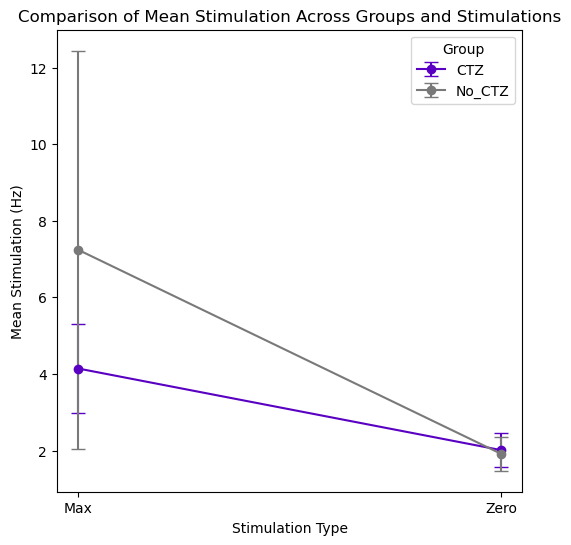

Initial mean_df shape: (356, 6)
mean_df columns: Index(['Group', 'Stimulation', 'mean_stimulation', 'cid', 'LaminarLabel',
       'recordingname'],
      dtype='object')
After filtering by groups, mean_df shape: (356, 6)
After filtering by stimulations, mean_df shape: (178, 6)
After filtering by laminar labels, mean_df shape: (42, 6)


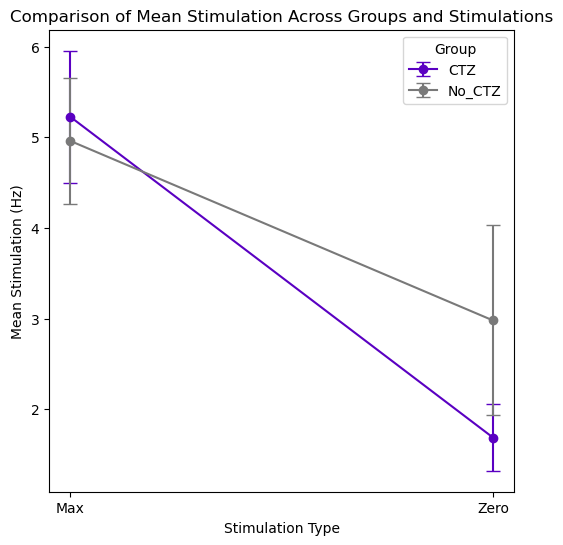

Initial mean_df shape: (356, 6)
mean_df columns: Index(['Group', 'Stimulation', 'mean_stimulation', 'cid', 'LaminarLabel',
       'recordingname'],
      dtype='object')
After filtering by groups, mean_df shape: (356, 6)
After filtering by stimulations, mean_df shape: (178, 6)
After filtering by laminar labels, mean_df shape: (110, 6)


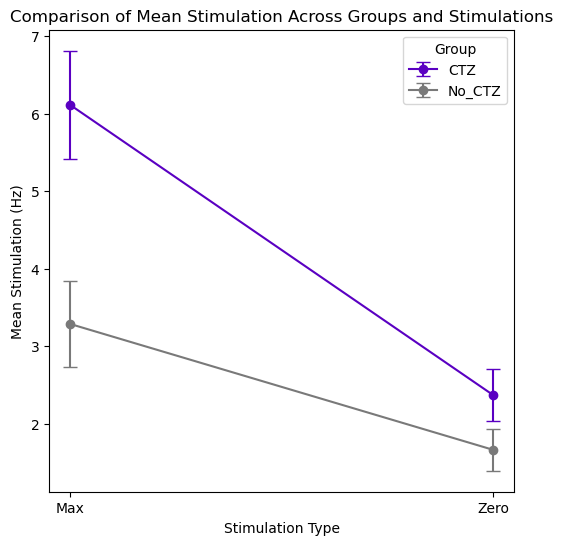

Initial mean_df shape: (356, 6)
mean_df columns: Index(['Group', 'Stimulation', 'mean_stimulation', 'cid', 'LaminarLabel',
       'recordingname'],
      dtype='object')
After filtering by groups, mean_df shape: (356, 6)
After filtering by stimulations, mean_df shape: (178, 6)


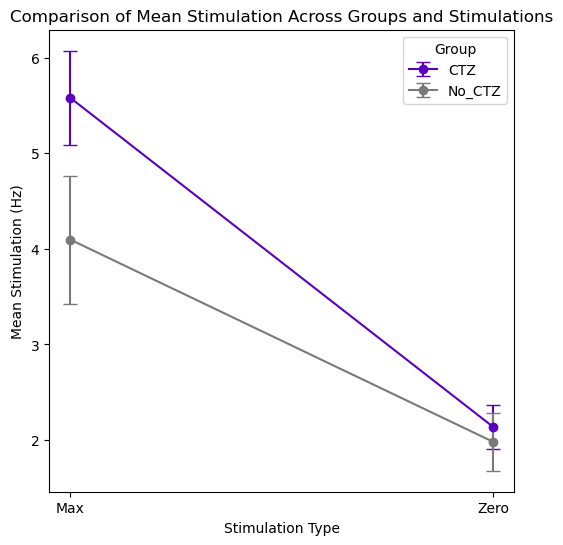

In [160]:
SG_stats_df, _= whisker_df_manager.plot_mean_sem_line2(mean_df_filtered, groups=['CTZ', 'No_CTZ'], stimulations=['Zero','Max'], remove_outliers_option=False, laminar_labels=['SG'], ylim=None, directory='/Volumes/MannySSD/figures/laminaranalysis', file_name='mean_stimulations_lineplot_SG_MUA')
L4_stats_df, _= whisker_df_manager.plot_mean_sem_line2(mean_df_filtered, groups=['CTZ', 'No_CTZ'], stimulations=['Zero','Max'],remove_outliers_option=False, laminar_labels=['L4'], ylim=None, directory='/Volumes/MannySSD/figures/laminaranalysis', file_name='mean_stimulations_lineplot_L4_MUA')
IG_stats_df, _= whisker_df_manager.plot_mean_sem_line2(mean_df_filtered, groups=['CTZ', 'No_CTZ'], stimulations=['Zero','Max'],remove_outliers_option=False, laminar_labels=['IG'], ylim=None, directory='/Volumes/MannySSD/figures/laminaranalysis', file_name='mean_stimulations_lineplot_IG_MUA')
alllayer_stats_df, _= whisker_df_manager.plot_mean_sem_line2(mean_df_filtered, groups=['CTZ', 'No_CTZ'], stimulations=['Zero','Max'], remove_outliers_option=False, laminar_labels=None, ylim=None, directory='/Volumes/MannySSD/figures/laminaranalysis', file_name='mean_stimulations_lineplot_alllayers_MUA')

Initial mean_df shape: (356, 6)
mean_df columns: Index(['Group', 'Stimulation', 'mean_stimulation', 'cid', 'LaminarLabel',
       'recordingname'],
      dtype='object')
After filtering by groups, mean_df shape: (356, 6)
After filtering by stimulations, mean_df shape: (178, 6)
After filtering by laminar labels, mean_df shape: (26, 6)


/opt/anaconda3/envs/spiketurnpike_postanalysis/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/spiketurnpike_postanalysis/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


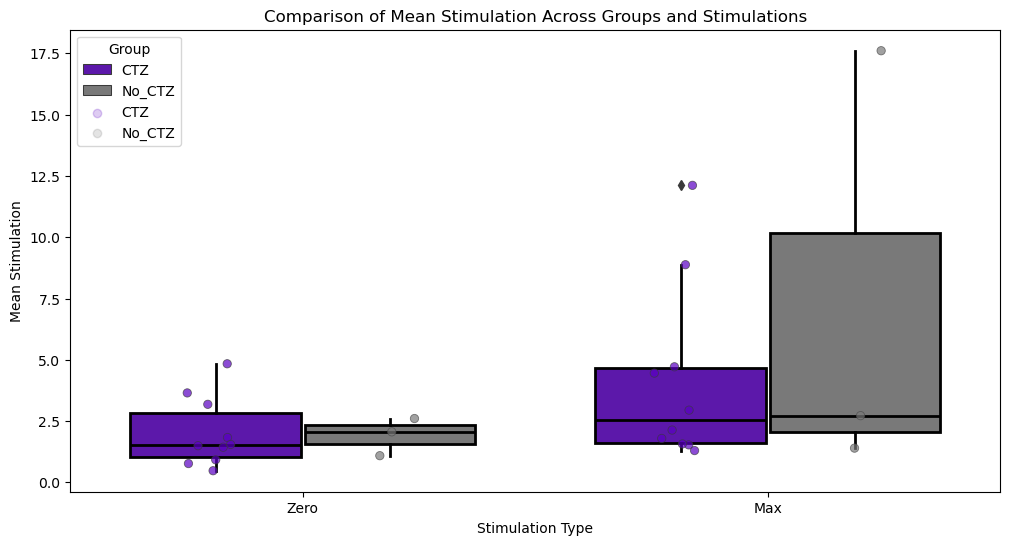

Initial mean_df shape: (356, 6)
mean_df columns: Index(['Group', 'Stimulation', 'mean_stimulation', 'cid', 'LaminarLabel',
       'recordingname'],
      dtype='object')
After filtering by groups, mean_df shape: (356, 6)
After filtering by stimulations, mean_df shape: (178, 6)
After filtering by laminar labels, mean_df shape: (42, 6)


/opt/anaconda3/envs/spiketurnpike_postanalysis/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/spiketurnpike_postanalysis/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


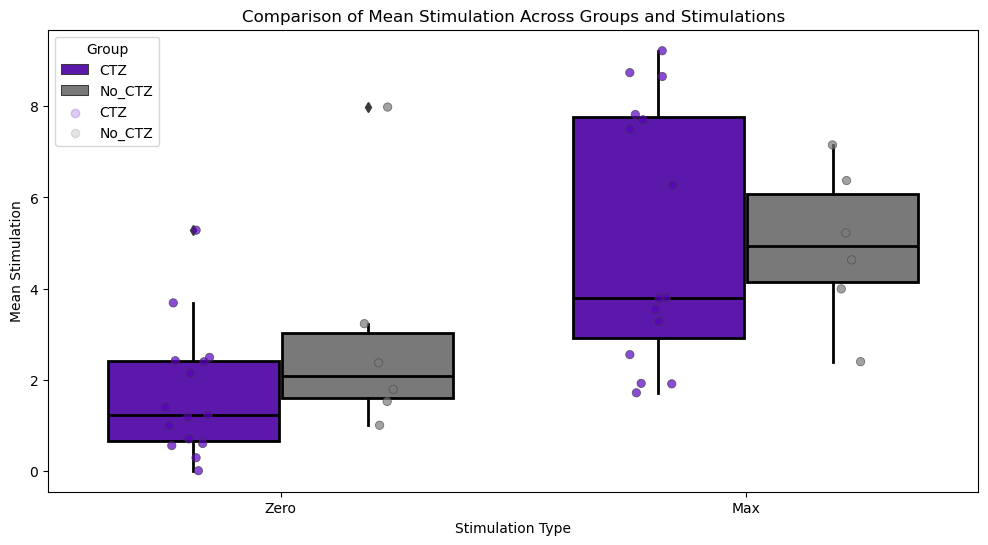

Initial mean_df shape: (356, 6)
mean_df columns: Index(['Group', 'Stimulation', 'mean_stimulation', 'cid', 'LaminarLabel',
       'recordingname'],
      dtype='object')
After filtering by groups, mean_df shape: (356, 6)
After filtering by stimulations, mean_df shape: (178, 6)
After filtering by laminar labels, mean_df shape: (110, 6)


/opt/anaconda3/envs/spiketurnpike_postanalysis/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/spiketurnpike_postanalysis/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


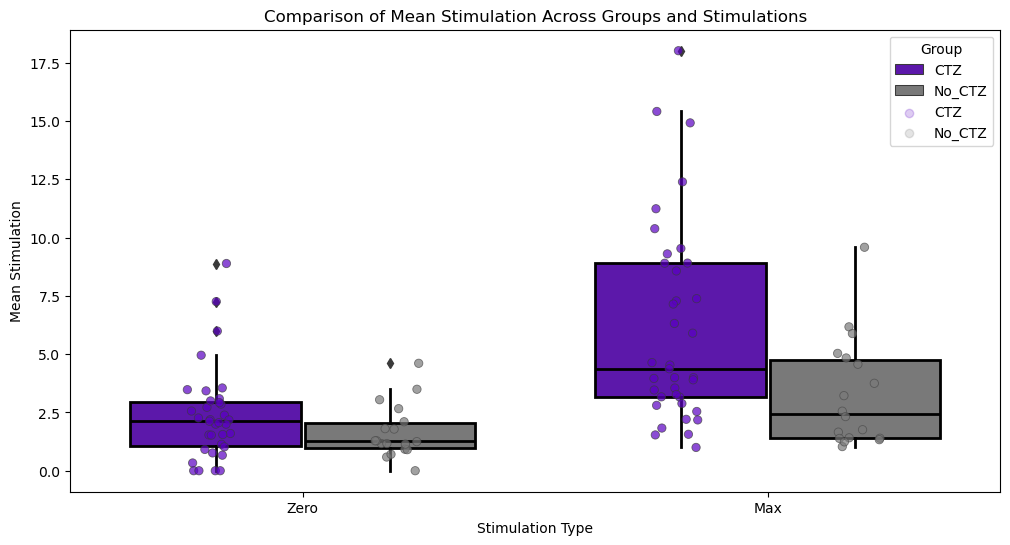

Initial mean_df shape: (356, 6)
mean_df columns: Index(['Group', 'Stimulation', 'mean_stimulation', 'cid', 'LaminarLabel',
       'recordingname'],
      dtype='object')
After filtering by groups, mean_df shape: (356, 6)
After filtering by stimulations, mean_df shape: (178, 6)


/opt/anaconda3/envs/spiketurnpike_postanalysis/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/spiketurnpike_postanalysis/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


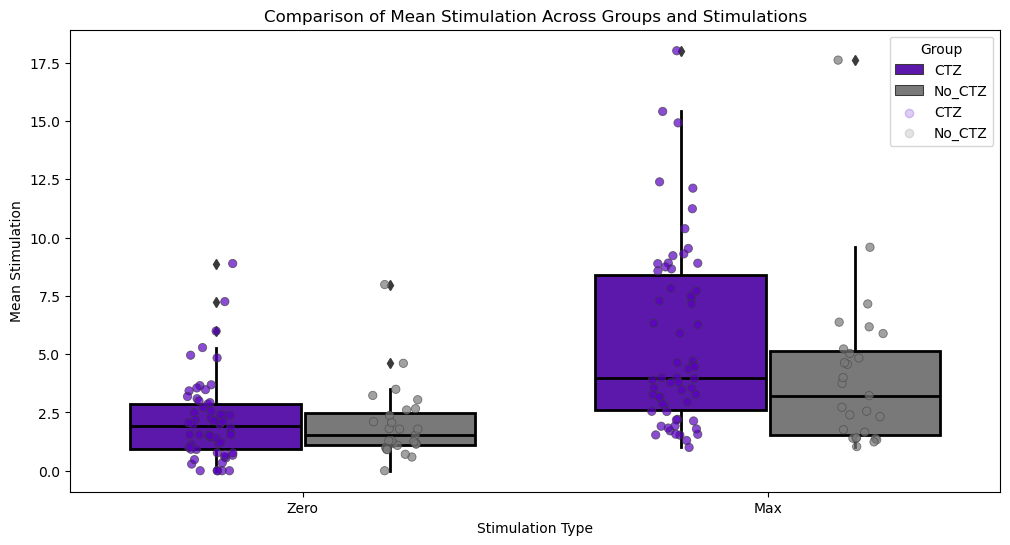

In [161]:
SG_stats_df, _= whisker_df_manager.plot_mean_stimulation_box_and_strip2(mean_df_filtered, groups=['CTZ', 'No_CTZ'], stimulations=['Zero','Max'], remove_outliers_option=False, laminar_labels=['SG'], ylim=None, directory='/Volumes/MannySSD/figures/laminaranalysis', file_name='mean_stimulations_boxplot_SG_MUA')
L4_stats_df, _= whisker_df_manager.plot_mean_stimulation_box_and_strip2(mean_df_filtered, groups=['CTZ', 'No_CTZ'], stimulations=['Zero','Max'],remove_outliers_option=False, laminar_labels=['L4'], ylim=None, directory='/Volumes/MannySSD/figures/laminaranalysis', file_name='mean_stimulations_boxplot_L4_MUA')
IG_stats_df, _= whisker_df_manager.plot_mean_stimulation_box_and_strip2(mean_df_filtered, groups=['CTZ', 'No_CTZ'], stimulations=['Zero','Max'],remove_outliers_option=False, laminar_labels=['IG'], ylim=None, directory='/Volumes/MannySSD/figures/laminaranalysis', file_name='mean_stimulations_boxplot_IG_MUA')
alllayer_stats_df, _= whisker_df_manager.plot_mean_stimulation_box_and_strip2(mean_df_filtered, groups=['CTZ', 'No_CTZ'], stimulations=['Zero','Max'], remove_outliers_option=False, laminar_labels=None, ylim=None, directory='/Volumes/MannySSD/figures/laminaranalysis', file_name='mean_stimulations_boxplot_alllayers_MUA')


### stats 

In [162]:
SG_stats_df

,Stimulation,Test Used,Test Statistic,p-value,N Group1,N Group2,Normality p-value Group1,Normality p-value Group2,mean Group1,SD Group1,median Group1,range_min Group1,range_max Group1,mean Group2,SD Group2,median Group2,range_min Group2,range_max Group2
0,Zero,Mann-Whitney U,13.0,0.811189,10,3,0.142932,0.688466,0.002014,0.001414,0.001522,0.000475,0.004838,0.001919,0.000768,0.002063,0.001089,0.002604
1,Max,Mann-Whitney U,14.0,0.937063,10,3,0.009295,0.140657,0.004143,0.003636,0.002540,0.001297,0.012116,0.007242,0.009001,0.002722,0.001397,0.017608


In [163]:
L4_stats_df

,Stimulation,Test Used,Test Statistic,p-value,N Group1,N Group2,Normality p-value Group1,Normality p-value Group2,mean Group1,SD Group1,median Group1,range_min Group1,range_max Group1,mean Group2,SD Group2,median Group2,range_min Group2,range_max Group2
0,Zero,Mann-Whitney U,28.5,0.212763,15,6,0.074688,0.027999,0.001689,0.001416,0.001223,0.000000,0.005281,0.002981,0.002568,0.002077,0.000998,0.007984
1,Max,Mann-Whitney U,45.0,1.000000,15,6,0.035315,0.975210,0.005227,0.002821,0.003801,0.001711,0.009221,0.004960,0.001702,0.004926,0.002395,0.007152


In [164]:
IG_stats_df

,Stimulation,Test Used,Test Statistic,p-value,N Group1,N Group2,Normality p-value Group1,Normality p-value Group2,mean Group1,SD Group1,median Group1,range_min Group1,range_max Group1,mean Group2,SD Group2,median Group2,range_min Group2,range_max Group2
0,Zero,Mann-Whitney U,386.0,0.185283,35,18,0.000490,0.049172,0.002369,0.001972,0.002123,0.000000,0.008886,0.001661,0.001146,0.001266,0.000000,0.004606
1,Max,Mann-Whitney U,480.0,0.008592,37,18,0.001171,0.008531,0.006110,0.004260,0.004373,0.000998,0.018010,0.003284,0.002330,0.002437,0.001035,0.009583


In [165]:
alllayer_stats_df

,Stimulation,Test Used,Test Statistic,p-value,N Group1,N Group2,Normality p-value Group1,Normality p-value Group2,mean Group1,SD Group1,median Group1,range_min Group1,range_max Group1,mean Group2,SD Group2,median Group2,range_min Group2,range_max Group2
0,Zero,Mann-Whitney U,851.5,0.706746,60,27,0.000021,0.000069,0.002140,0.001762,0.001913,0.000000,0.008886,0.001983,0.001573,0.001521,0.000000,0.007984
1,Max,Mann-Whitney U,1058.0,0.049077,62,27,0.000030,0.000023,0.005579,0.003876,0.003992,0.000998,0.018010,0.004096,0.003480,0.003219,0.001035,0.017608


### calculte PSTHs for RS SUA Laminar analysis, create the mean PSTH, then filter based on modulation index

In [153]:
mean_df, detailed_df, _ = whisker_df_manager.calculate_all_psths(is_single_unit=1.0, cell_type='RS', stim_responsivity=None, time_window=(0,500), normalize=True, filter_empty_trials=True)

Processing Group: CTZ, Recording: ctz_2303_1, CID: cid172
Processing Group: CTZ, Recording: ctz_2303_1, CID: cid225
Processing Group: CTZ, Recording: ctz_2303_1, CID: cid441
Processing Group: CTZ, Recording: ctz_2303_1, CID: cid514
Processing Group: CTZ, Recording: ctz_2303_1, CID: cid548
Processing Group: CTZ, Recording: ctz_2303_1, CID: cid590
Processing Group: CTZ, Recording: ctz_2303_1, CID: cid629
Processing Group: CTZ, Recording: ctz_2303_1, CID: cid641
Processing Group: CTZ, Recording: ctz_2303_2, CID: cid208
Processing Group: CTZ, Recording: ctz_2303_2, CID: cid359
Processing Group: CTZ, Recording: ctz_2303_2, CID: cid437
Processing Group: CTZ, Recording: ctz_2303_2, CID: cid473
Processing Group: CTZ, Recording: ctz_2303_2, CID: cid476
Processing Group: CTZ, Recording: ctz_2303_2, CID: cid491
Processing Group: CTZ, Recording: ctz_2303_2, CID: cid720
Processing Group: CTZ, Recording: ctz_2303_2, CID: cid724
Processing Group: CTZ, Recording: ctz_2303_2, CID: cid809
Processing Gro

### calculte PSTHs for RS SUA Laminar analysis, create the mean PSTH, then filter based on modulation index

In [154]:
_ = whisker_df_manager.add_modulation_label_column('basic_metrics') # Add ModulationLabel column to basic_metrics DataFrame
def filter_mean_df_by_modulation_label(mean_df, basic_metrics_df):
    """
    Filters mean_df to retain only entries with 'positive' ModulationLabel in basic_metrics_df.
    
    Args:
    mean_df (pd.DataFrame): DataFrame containing mean stimulation data.
    basic_metrics_df (pd.DataFrame): DataFrame containing modulation label and other metrics.
    
    Returns:
    pd.DataFrame: Filtered mean_df with only 'positive' ModulationLabel entries.
    """
    # Merge mean_df with basic_metrics_df on the shared columns
    merged_df = mean_df.merge(basic_metrics_df, how='inner', 
                              left_on=['cid', 'LaminarLabel', 'recordingname', 'Group'], 
                              right_on=['cid', 'LaminarLabel', 'recordingname', 'groupname'])
    
    # Filter to retain only entries where ModulationLabel is 'positive'
    filtered_df = merged_df[merged_df['ModulationLabel'] == 'positive']
    
    # Drop columns from basic_metrics_df that were added during the merge
    filtered_df = filtered_df[mean_df.columns]
    
    return filtered_df

# Example usage
mean_df_filtered = filter_mean_df_by_modulation_label(mean_df, whisker_df_manager.dataframes['basic_metrics'])
mean_df_filtered

Added ModulationLabel column to 'basic_metrics' DataFrame.


,Group,Stimulation,mean_stimulation,cid,LaminarLabel,recordingname
0,CTZ,Zero,0.001774,cid172,IG,ctz_2303_1
1,CTZ,Low,0.000798,cid172,IG,ctz_2303_1
2,CTZ,Mid,0.001552,cid172,IG,ctz_2303_1
3,CTZ,Max,0.001109,cid172,IG,ctz_2303_1
4,CTZ,Zero,0.000399,cid225,SG,ctz_2303_1
...,...,...,...,...,...,...
607,No_CTZ,Max,0.002028,cid697,IG,veh_3142_2
608,No_CTZ,Zero,0.000434,cid182,IG,veh_3143_1
609,No_CTZ,Low,0.000399,cid182,IG,veh_3143_1
610,No_CTZ,Mid,0.001035,cid182,IG,veh_3143_1


### create the RS MUA and SUA combined plots using the filtered data and run stats


Initial mean_df shape: (364, 6)
mean_df columns: Index(['Group', 'Stimulation', 'mean_stimulation', 'cid', 'LaminarLabel',
       'recordingname'],
      dtype='object')
After filtering by groups, mean_df shape: (364, 6)
After filtering by stimulations, mean_df shape: (182, 6)
After filtering by laminar labels, mean_df shape: (48, 6)


/opt/anaconda3/envs/spiketurnpike_postanalysis/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/spiketurnpike_postanalysis/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


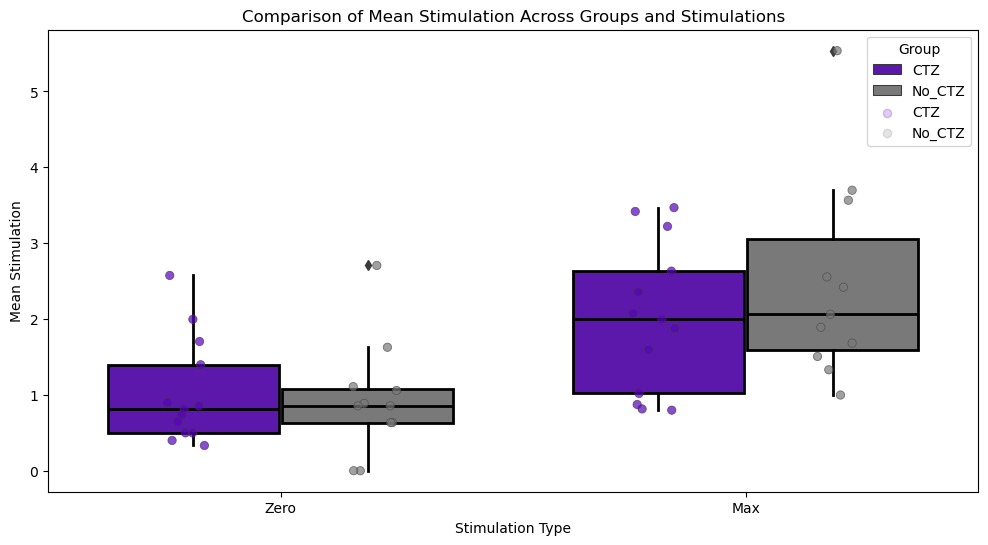

Initial mean_df shape: (364, 6)
mean_df columns: Index(['Group', 'Stimulation', 'mean_stimulation', 'cid', 'LaminarLabel',
       'recordingname'],
      dtype='object')
After filtering by groups, mean_df shape: (364, 6)
After filtering by stimulations, mean_df shape: (182, 6)
After filtering by laminar labels, mean_df shape: (40, 6)


/opt/anaconda3/envs/spiketurnpike_postanalysis/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/spiketurnpike_postanalysis/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


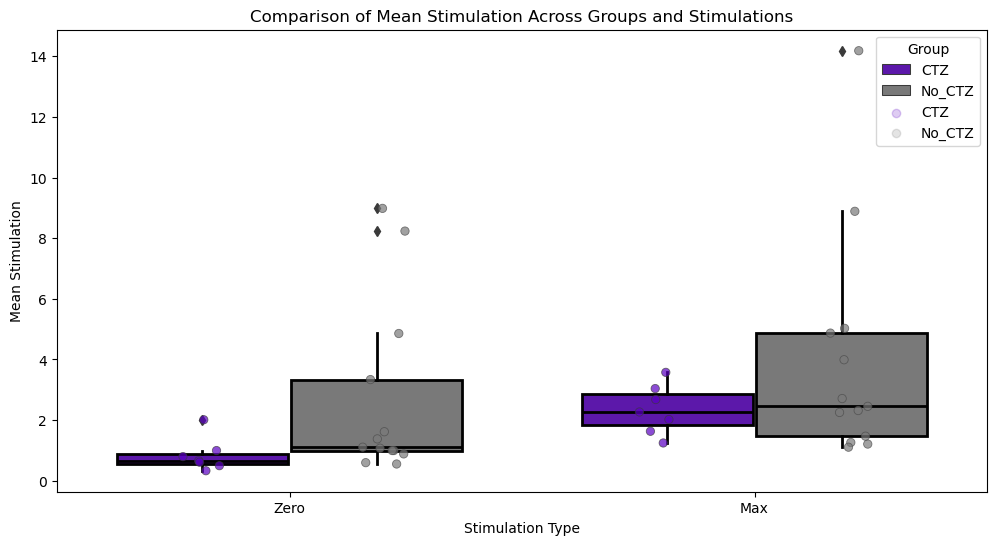

Initial mean_df shape: (364, 6)
mean_df columns: Index(['Group', 'Stimulation', 'mean_stimulation', 'cid', 'LaminarLabel',
       'recordingname'],
      dtype='object')
After filtering by groups, mean_df shape: (364, 6)
After filtering by stimulations, mean_df shape: (182, 6)
After filtering by laminar labels, mean_df shape: (94, 6)


/opt/anaconda3/envs/spiketurnpike_postanalysis/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/spiketurnpike_postanalysis/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


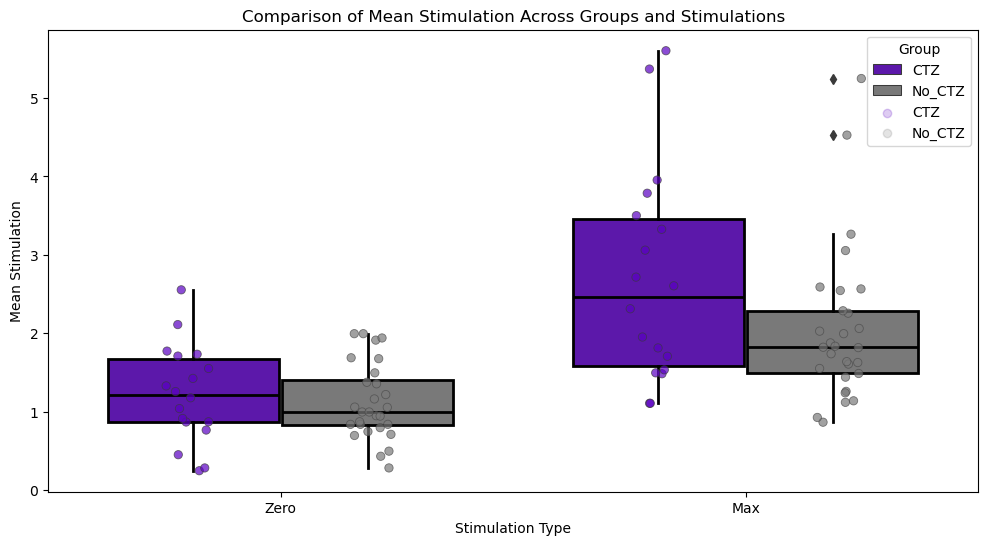

Initial mean_df shape: (364, 6)
mean_df columns: Index(['Group', 'Stimulation', 'mean_stimulation', 'cid', 'LaminarLabel',
       'recordingname'],
      dtype='object')
After filtering by groups, mean_df shape: (364, 6)
After filtering by stimulations, mean_df shape: (182, 6)


/opt/anaconda3/envs/spiketurnpike_postanalysis/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/spiketurnpike_postanalysis/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


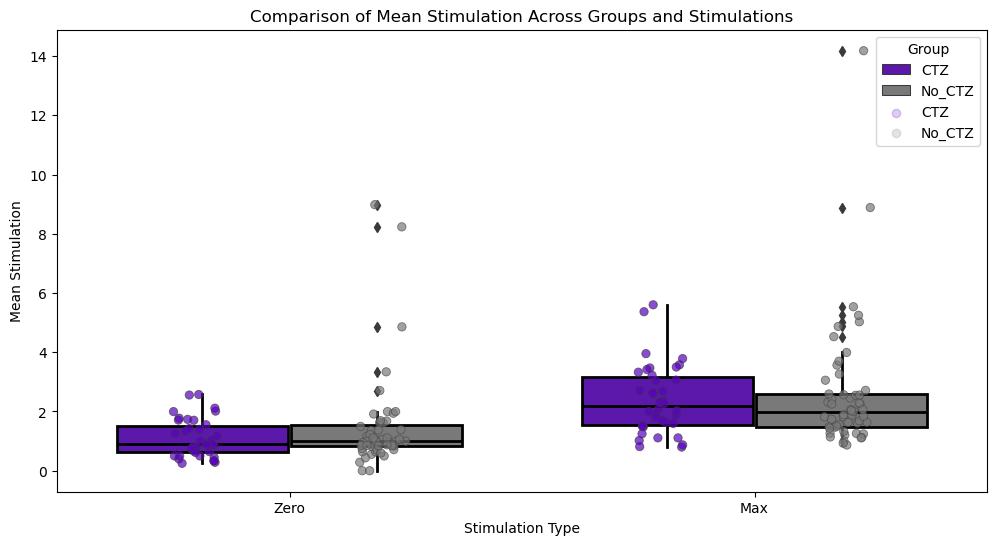

In [155]:
SG_stats_df, _= whisker_df_manager.plot_mean_stimulation_box_and_strip2(mean_df_filtered, groups=['CTZ', 'No_CTZ'], stimulations=['Zero', 'Max'], remove_outliers_option=False, laminar_labels=['SG'], ylim=None, directory='/Volumes/MannySSD/figures/laminaranalysis', file_name='mean_stimulations_boxplot_SG_RS_SUAMUA')
L4_stats_df, _= whisker_df_manager.plot_mean_stimulation_box_and_strip2(mean_df_filtered, groups=['CTZ', 'No_CTZ'], stimulations=['Zero', 'Max'],remove_outliers_option=False, laminar_labels=['L4'], ylim=None, directory='/Volumes/MannySSD/figures/laminaranalysis', file_name='mean_stimulations_boxplot_L4_RS_SUAMUA')
IG_stats_df, _= whisker_df_manager.plot_mean_stimulation_box_and_strip2(mean_df_filtered, groups=['CTZ', 'No_CTZ'], stimulations=['Zero', 'Max'],remove_outliers_option=False, laminar_labels=['IG'], ylim=None, directory='/Volumes/MannySSD/figures/laminaranalysis', file_name='mean_stimulations_boxplot_IG_RS_SUAMUA')
alllayer_stats_df, _= whisker_df_manager.plot_mean_stimulation_box_and_strip2(mean_df_filtered, groups=['CTZ', 'No_CTZ'], stimulations=['Zero','Max'], remove_outliers_option=False, laminar_labels=None, ylim=None, directory='/Volumes/MannySSD/figures/laminaranalysis', file_name='mean_stimulations_boxplot_alllayers_RS_SUAMUA')


### stats for RS MUA and SUA

In [76]:
SG_stats_df

,Stimulation,Test Used,Test Statistic,p-value,N Group1,N Group2,Normality p-value Group1,Normality p-value Group2,mean Group1,SD Group1,median Group1,range_min Group1,range_max Group1,mean Group2,SD Group2,median Group2,range_min Group2,range_max Group2
0,Zero,Mann-Whitney U,150.5,0.632065,21,13,0.000008,0.000049,0.123657,0.195887,0.025948,0.001996,0.652695,0.064333,0.107037,0.027944,0.000000,0.403194
1,Max,Mann-Whitney U,123.0,0.644938,21,13,0.000002,0.000222,0.350917,0.596468,0.107784,0.003992,2.071856,0.256717,0.356691,0.149701,0.017964,1.323353


In [77]:
L4_stats_df

,Stimulation,Test Used,Test Statistic,p-value,N Group1,N Group2,Normality p-value Group1,Normality p-value Group2,mean Group1,SD Group1,median Group1,range_min Group1,range_max Group1,mean Group2,SD Group2,median Group2,range_min Group2,range_max Group2
0,Zero,Mann-Whitney U,131.5,0.678613,18,16,0.000136,0.000297,0.115325,0.163512,0.019960,0.000000,0.596806,0.093064,0.122884,0.043912,0.003992,0.397206
1,Max,Mann-Whitney U,166.5,0.447740,18,16,0.001200,0.000714,0.598359,0.699172,0.238523,0.017964,2.157685,0.399701,0.480356,0.151697,0.019960,1.395210


In [78]:
IG_stats_df

,Stimulation,Test Used,Test Statistic,p-value,N Group1,N Group2,Normality p-value Group1,Normality p-value Group2,mean Group1,SD Group1,median Group1,range_min Group1,range_max Group1,mean Group2,SD Group2,median Group2,range_min Group2,range_max Group2
0,Zero,Mann-Whitney U,1168.0,0.035305,42,44,7.261432e-09,8.913443e-09,0.173320,0.272314,0.052894,0.000000,1.475050,0.057975,0.084300,0.020958,0.000000,0.419162
1,Max,Mann-Whitney U,1236.0,0.007117,42,44,3.364198e-07,1.829965e-09,0.601749,0.751669,0.378244,0.001996,3.774451,0.266422,0.414263,0.084830,0.003992,2.213573


In [79]:
alllayer_stats_df

,Stimulation,Test Used,Test Statistic,p-value,N Group1,N Group2,Normality p-value Group1,Normality p-value Group2,mean Group1,SD Group1,median Group1,range_min Group1,range_max Group1,mean Group2,SD Group2,median Group2,range_min Group2,range_max Group2
0,Zero,Mann-Whitney U,3383.5,0.122589,81,73,1.343442e-12,1.211423e-11,0.147557,0.232402,0.025948,0.000000,1.475050,0.066798,0.097476,0.023952,0.000000,0.419162
1,Max,Mann-Whitney U,3553.0,0.031027,81,73,1.038896e-10,1.771320e-11,0.535965,0.703225,0.211577,0.001996,3.774451,0.293905,0.418289,0.109780,0.003992,2.213573
